# HDDM-NN TUTORIAL

Welcome to the HDMM_NN Tutorial! For an overview of what HDDM is about, as well as installation instructions, 
visit the github page of this tutorial.

# SECTION 0.0: COLAB PREP

### INSTALLATION COLAB: 1 MOUNT YOUR GOOGLE DRIVE


In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

ModuleNotFoundError: No module named 'google.colab'

### INSTALLATION COLAB: 2 SWITCH TO TUTORIAL FOLDER

In [ ]:
%cd gdrive/'My Drive'/hddmnn_tutorial

### INSTALLATION COLAB: 3 INSTALL SUPPORT LIBRARIES

In [ ]:
!pip uninstall tensorflow  # tf 2.3.0 is loaded by default --> very slow on our networks
!pip install tensorflow-gpu==1.15 # tf 1.15 ~ 4 times faster (feel free to test this out)
!pip install pymc
!pip install kabuki

### INSTALLATION COLAB: 4 INSTALL HDDM

In [ ]:
!pip install -U --no-deps git+https://github.com/madslupe/hddm@nn_likelihood

# SECTION 0.1: IMPORTS (ANY SETUP)

In [2]:
# MODULE IMPORTS ----

# 
import hddm

# Make simulators visible
import sys
sys.path.append('simulators')

# Data management
import pandas as pd
import numpy as np
import pickle

# Plotting
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

# Stats functionality
from statsmodels.distributions.empirical_distribution import ECDF

# CUSTOM IMPORTS (LOCAL FILES) --------
import cddm_data_simulation as cds
import boundary_functions as bf

from helper_functions import simulator
from helper_functions import model_plot
from helper_functions import caterpillar_plot
from helper_functions import posterior_pair_plot
# from helper_functions import hddm_preprocess_hierarchical
from helper_functions import simulator_condition_effects
from helper_functions import make_parameter_sets
from helper_functions import _make_trace_plotready_condition
from helper_functions import hddm_preprocess
from helper_functions import simulator_hierarchical
from helper_functions import posterior_predictive_plot
# --------------------------------------

# Section 1: A look into DDM variations
Let's simulate some data from the angle model and check the resulting (choice, reaction) time data.
You can change the number of samples (n_samples), and the parameters of the model (v, a, w, ndt, theta). 
If you are outside of the valid range for any parameter you will be warned. First, let's begin with the angle model, in which the decision bound $a$ is a line making an angle $\theta$ with the $y$ axis.

## Angle model
In the angle model, we have 5 parameters:
- $a$, a boundary scalar. $a$ reflects how much relative evidence one would need to reach a certain choice. The higher $a$ is, the more evidence is needed in favor of one option over the other, before a choice is taken. An example of a way to expect higher $a$ value would be to tell the participant to 'be as prudent and accurate as possible'.
- $v$, drift, or evidence for/against a certain choice. Note that as a task becomes more difficult, $v$ could decrease.
- $w$, bias, accounts for an a priori preference towards a choice compared to the other (a reason for this might be an imbalance or otherwise detected pattern in the stimulus set
- $t$, non-decision time, a 'lag' before the participant begins processing task relevant information.
- $\theta$, the angle parameter, which gives the degree of 'collapse of the bounds'.

The **bound** is defined as: $b(t) = a - \left( t * \frac{\sin(\theta)}{\cos(\theta))} \right)$.  (We will see examples, this defines simply a *linear collapse*)

### make_parameter_sets (model, n_parameter_sets, param_dict)
Parameters:
- **model**: string, 'ddm', 'angle' or 'weibull_cdf'
- **n_parameter_sets**: integer, the number of parameter sets desired.
- **param_dict**: a dictionary containing any specific parameters. For example, `param_dict = {'v': [1]}` will make all the parameter sets have $v$ = 1. Can be used in combination with list comprehension and `np.linspace` to produce jumps. For example, `{'v' = [i for i in np.linspace(0.5, 1.5, 5)]}` causes $v$ to increase from 0.5 to 1.5 in 5 steps.

Returns:
A `pandas` frame consisting of the parameter sets. To access the $n$-th parameter set as an array, call `values[n]`.


In [13]:
# LETS START WITH MAKING SOME PARAMETERS FOR OUR MODEL OF CHOICE

angle_params = make_parameter_sets(model = 'angle',
                                   n_parameter_sets = 5,
                                   param_dict = {'v': [i for i in np.linspace(0.5, 1.5, 5)]})

In [14]:
angle_params.values[0]

array([0.5       , 0.59329684, 0.34458691, 1.13056398, 0.79738038])

### simulator(model, theta, n_samples)
Parameters:
- **model**: string, 'ddm', 'angle' or 'weibull_cdf'
- **theta**: an array in the output of `make_parameter_sets`. Automatically handles theta/alpha/beta in the case of angle/weibull models. 
- **n_samples**: integer.

Returns:
A 3-tupule of:
0. An array of time data
1. An array of choice data
2. Metadata

In [15]:
simulations = simulator(theta = angle_params.values[0],
                        model = 'angle', 
                        n_samples = 2000)

In [16]:
# Look into the output
simulations

(array([[1.196564 ],
        [1.3665643],
        [1.3085642],
        ...,
        [1.3555642],
        [1.225564 ],
        [1.4195638]], dtype=float32),
 array([[ 1],
        [ 1],
        [ 1],
        ...,
        [-1],
        [-1],
        [-1]], dtype=int32),
 {'v': 0.5,
  'a': 0.5932968258857727,
  'w': 0.34458690881729126,
  'ndt': 1.1305639743804932,
  's': 1.0,
  'theta': 0.797380379392292,
  'delta_t': 0.0010000000474974513,
  'max_t': 20.0,
  'n_samples': 2000,
  'simulator': 'ddm_flexbound',
  'boundary_fun_type': 'angle',
  'possible_choices': [-1, 1]})

Now that we have our simulated data, we look to visualise it.
## Plotting a sample dataset
### model_plot(ground_truths, posterior_samples, cols, model_gy, datatype, n_plots, max_t, show_model)

Parameters:

- **ground_truths**: arrays of ground truth parameters
- **posterior_samples**: posterior data. For now, leave this as `None` since we are only plotting our simulated data.
- **cols**: integer, number of columns of plots. Only relevant when plotting multiple plots.
- **n_plots**: integer, number of plots
- **model_gt**: string, 'ddm', 'angle' or 'weibull_cdf'. The model from which the ground truth data came from.
- **datatype**: string, 'single_subject', 'hierarchical' or 'condition'
- **max_t**: float, maximum reaction time shown
- **show_model**: bool, whether or not the parameter lines are shown

Return:

Plot of the appropriate information.

IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

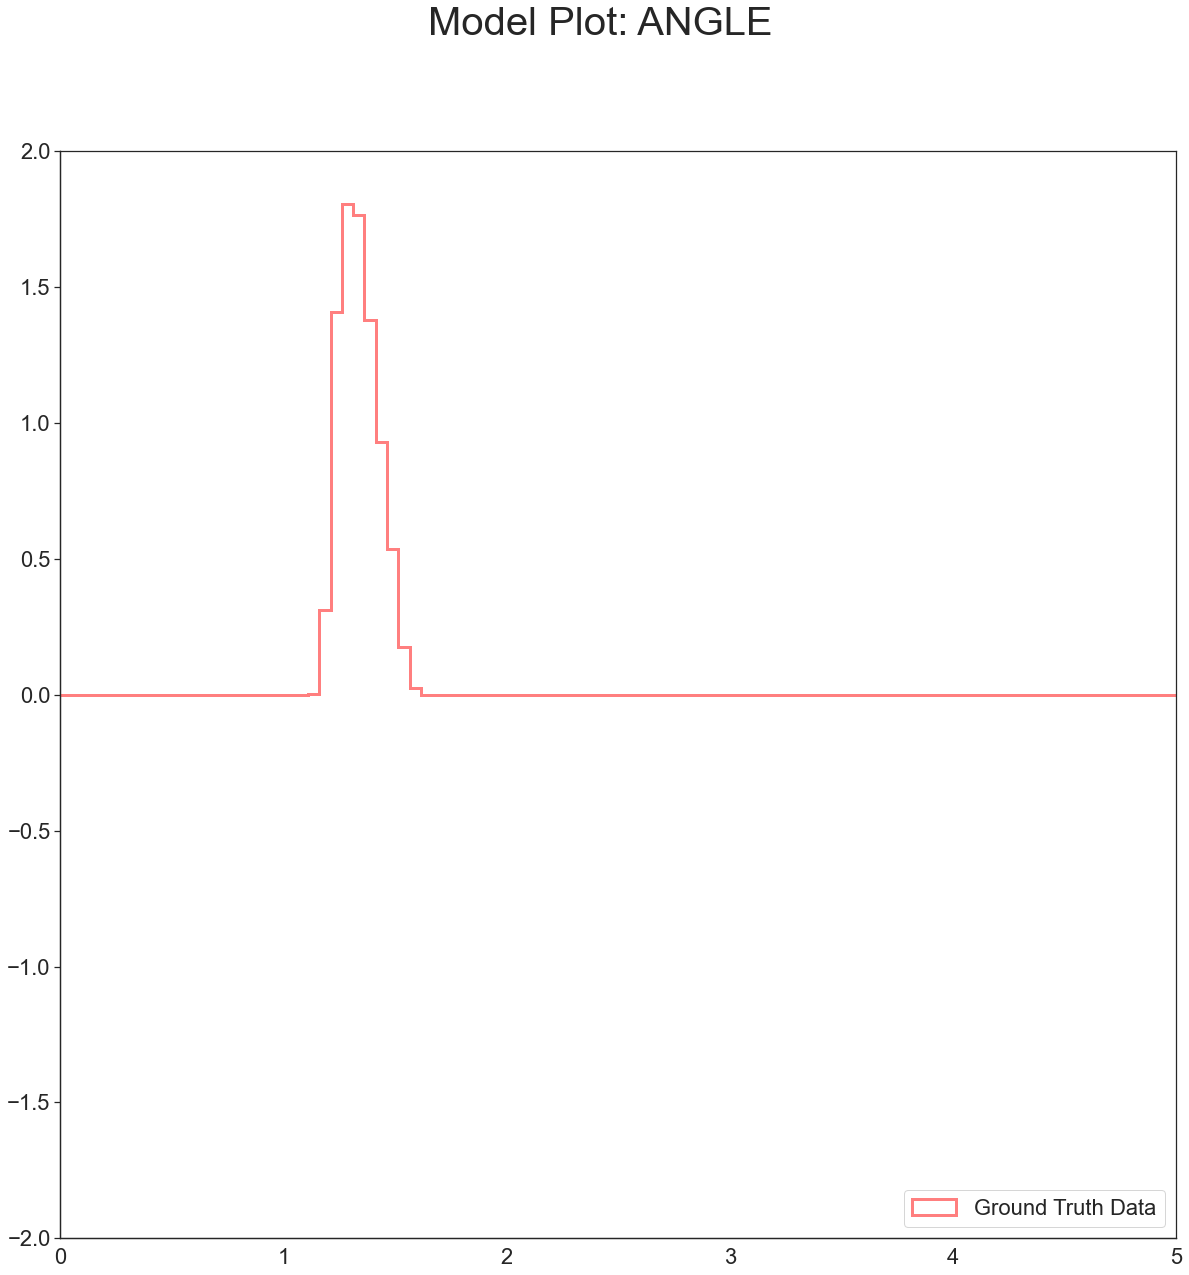

In [17]:
# Model Plots (Only data)
model_plot(ground_truths_parameters = angle_params.values[0],
           posterior_samples = None,
           cols = 1, 
           model_gt = 'angle',
           datatype = 'single_subject',
           n_plots = 1,
           max_t = 5,
           show_model = False)

### The Effect of varying parameters

#### varying $a$

We look to investigate the ground truth data distribution when one parameter is changed very slightly. First, let's look at what happens for the angle model when $a$ varies from 0.5 to 1.5 in ten steps.

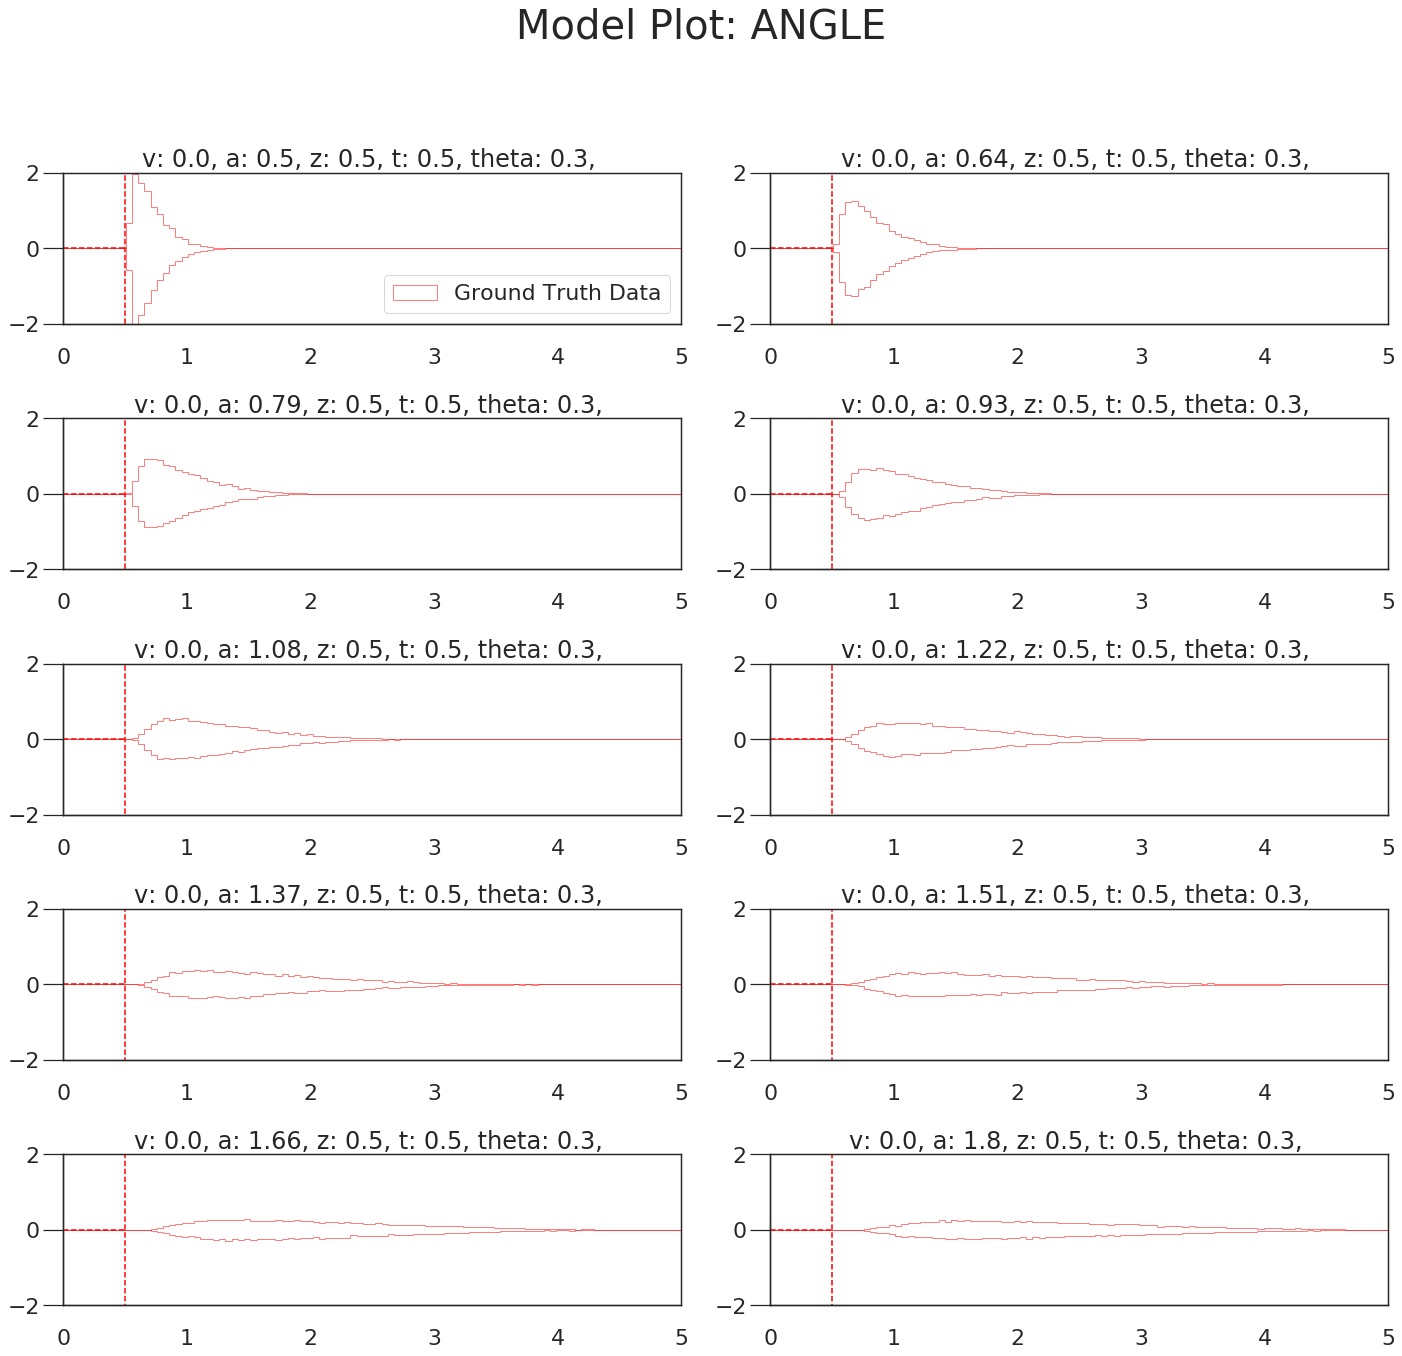

In [14]:
# Plotting the data
angle_params = make_parameter_sets(model = 'angle',
                                   n_parameter_sets = 10,
                                   param_dict = {'a': [i for i in np.linspace(0.5, 1.8, 10)],
                                                 'v': [0],
                                                 'z': [0.5],
                                                 'theta': [0.3],
                                                 't': [0.5]})

# Model Plots (Only data)
model_plot(ground_truths_parameters = angle_params.values,
           cols = 2, 
           model_gt = 'angle',
           n_plots = 10,
           max_t = 5,
           show_model = False)

Note that as $a$ increases, the data distribution becomes flatter and wider, or the participant is more likely to take very long before reaching a choice. This makes sense because as $a$ increases, more evidence is required before a choice is made, leading to long reaction times. For small $a$ values, little evidence is required and thus most of the reaction time is short. 

Now let us fix the other parameters and vary $\theta$ instead, to see how this affects the **choice/reaction-time** distributions.

#### varying $\theta$ 

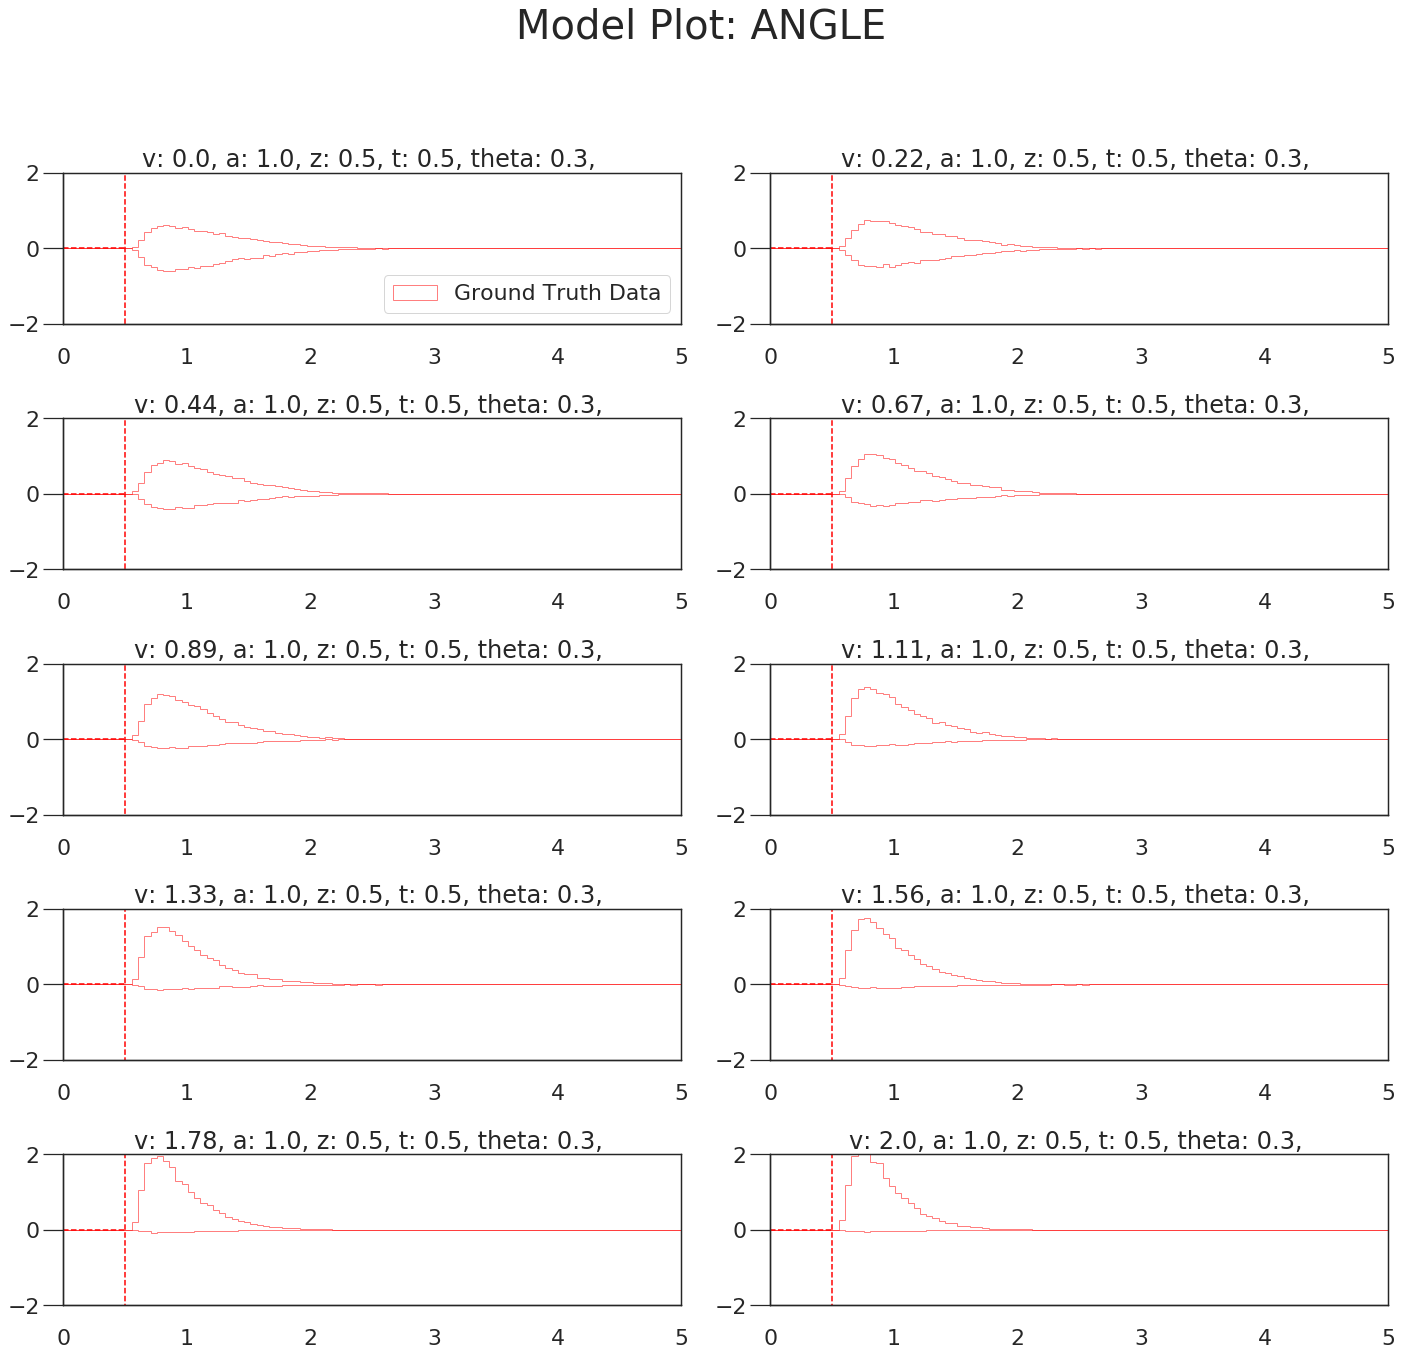

In [21]:
# Plotting the data
angle_params = make_parameter_sets(model = 'angle',
                                   n_parameter_sets = 10,
                                   param_dict = {'a': [1.0],
                                                 'v': [0.5],
                                                 'z': [0.55],
                                                 'theta': [i for i in np.linspace(0.2, 1.0, 10)],
                                                 't': [0.5]})

# Model Plots (Only data)
model_plot(ground_truths_parameters = angle_params.values,
           cols = 2, 
           model_gt = 'angle',
           n_plots = 10,
           max_t = 5,
           show_model = False)

### Adding the ground truth model visually

We can include the ground truth model itself pictorially to aid intuition.

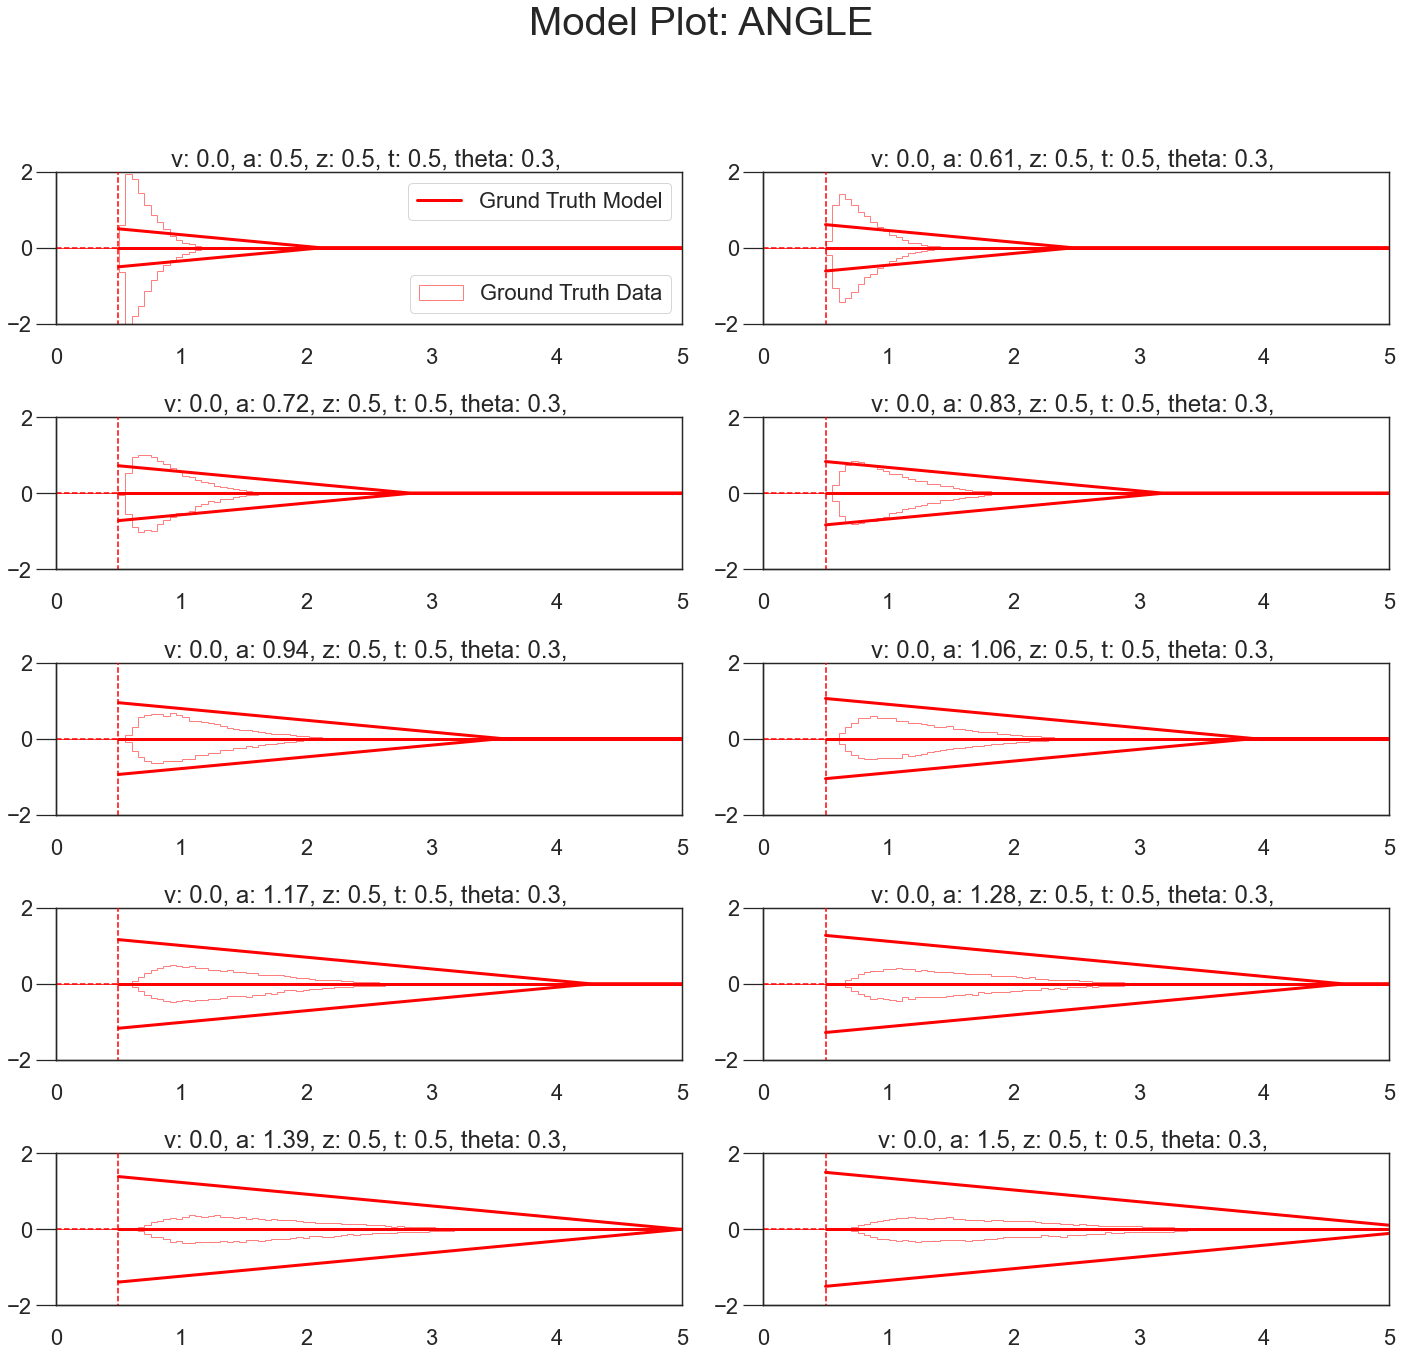

In [44]:
# Model Plot (Data + Model)
model_plot(ground_truths_parameters = angle_params.values,
           cols = 2, 
           model_gt = 'angle',
           n_plots = 10,
           max_t = 5,
           show_model = True)

If you are interested, you can use this code to investigate the effects of the other parameters.

## WEIBULL CDF MODEL
In the **weibull cdf** model, we have $6$ parameters:
- $a$, a boundary scalar. $a$ reflects how much relative evidence one would need to reach a certain choice. The higher $a$ is, the more evidence is needed in favor of one option over the other, before a choice is taken. An example of a way to expect higher $a$ value would be to tell the participant to 'be as prudent and accurate as possible'.
- $v$, drift, or evidence for/against a certain choice. Note that as a task becomes more difficult, $v$ could decrease.
- $w$, bias, accounts for an a priori preference towards a choice compared to the other (a reason for this might be an imbalance or otherwise detected pattern in the stimulus set
- $t$, non-decision time, a 'lag' before the participant begins processing task relevant information.
- $\alpha$ and $\beta$, two parameters which jointly define the 'shape of the bounds'.

The **bound** is defined as, $b(t) = a * \left( \exp{ (- \frac{t}{\beta}^{\alpha}}) \right)$

Let us quickly look into the effects of $\alpha$ and $\beta$.

KeyboardInterrupt: 

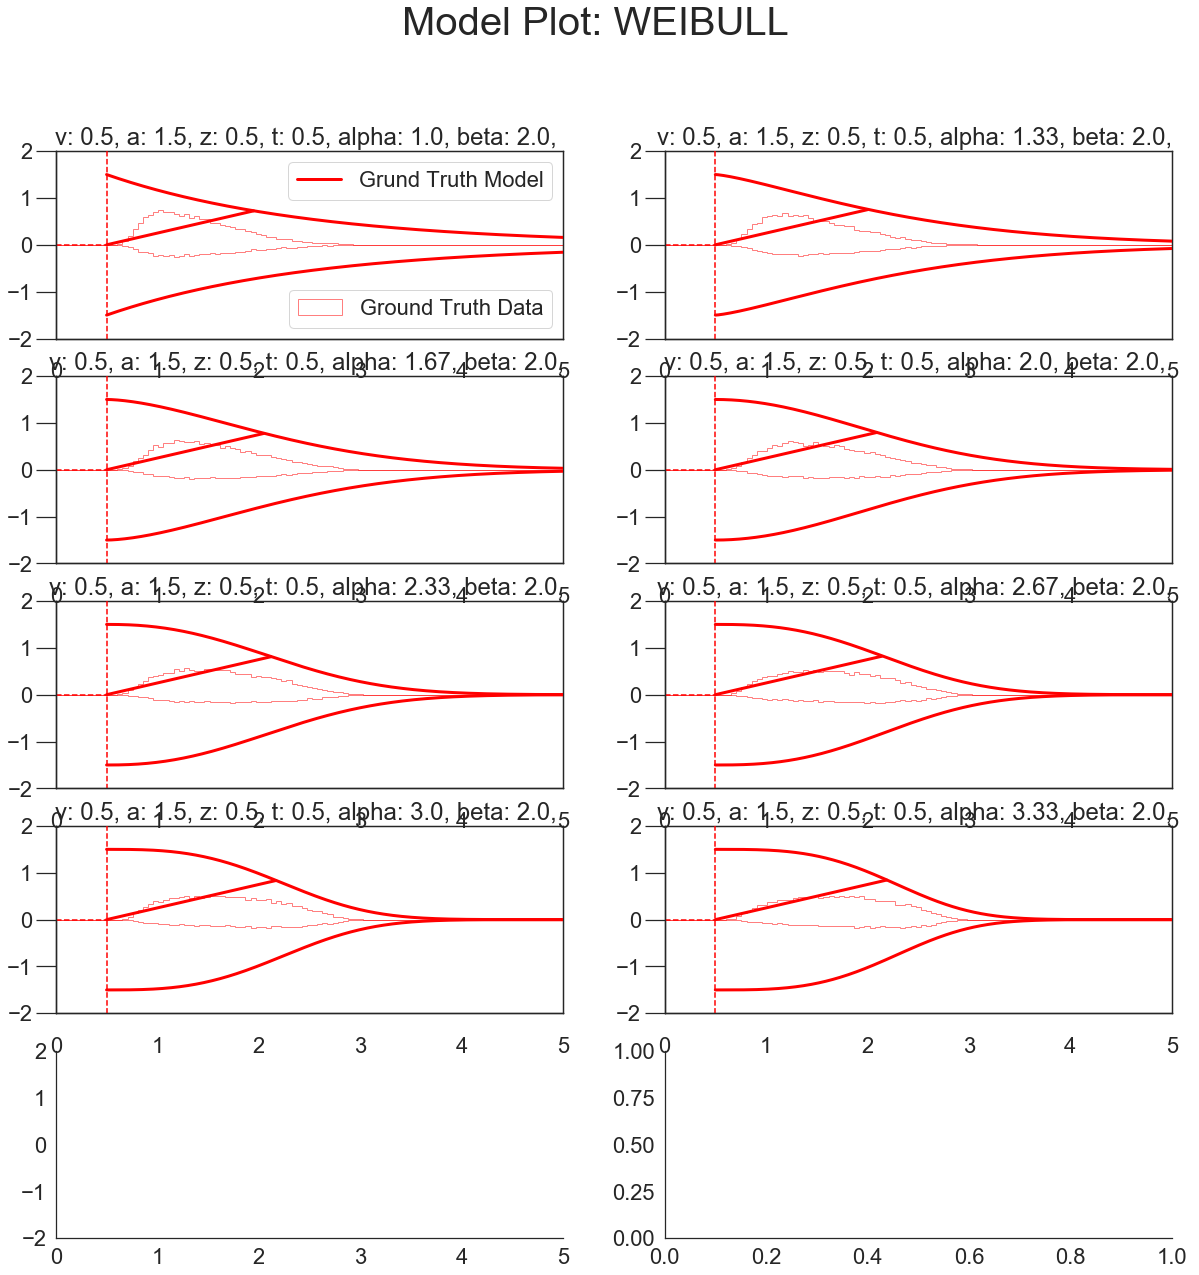

In [2]:
# Plotting the data
weibull_params = make_parameter_sets(model = 'weibull_cdf',
                                     n_parameter_sets = 10,
                                     param_dict = {'a': [1.5],
                                                   'v': [0.5],
                                                   'z': [0.5],
                                                   'alpha': [i for i in np.linspace(1, 4, 10)],
                                                   'beta': [2],
                                                   't': [0.5]})

#Model Plots (Only data)
model_plot(ground_truths_parameters = weibull_params.values,
           cols = 2, 
           model_gt = 'weibull_cdf',
           n_plots = 10,
           max_t = 5,
           show_model = True)

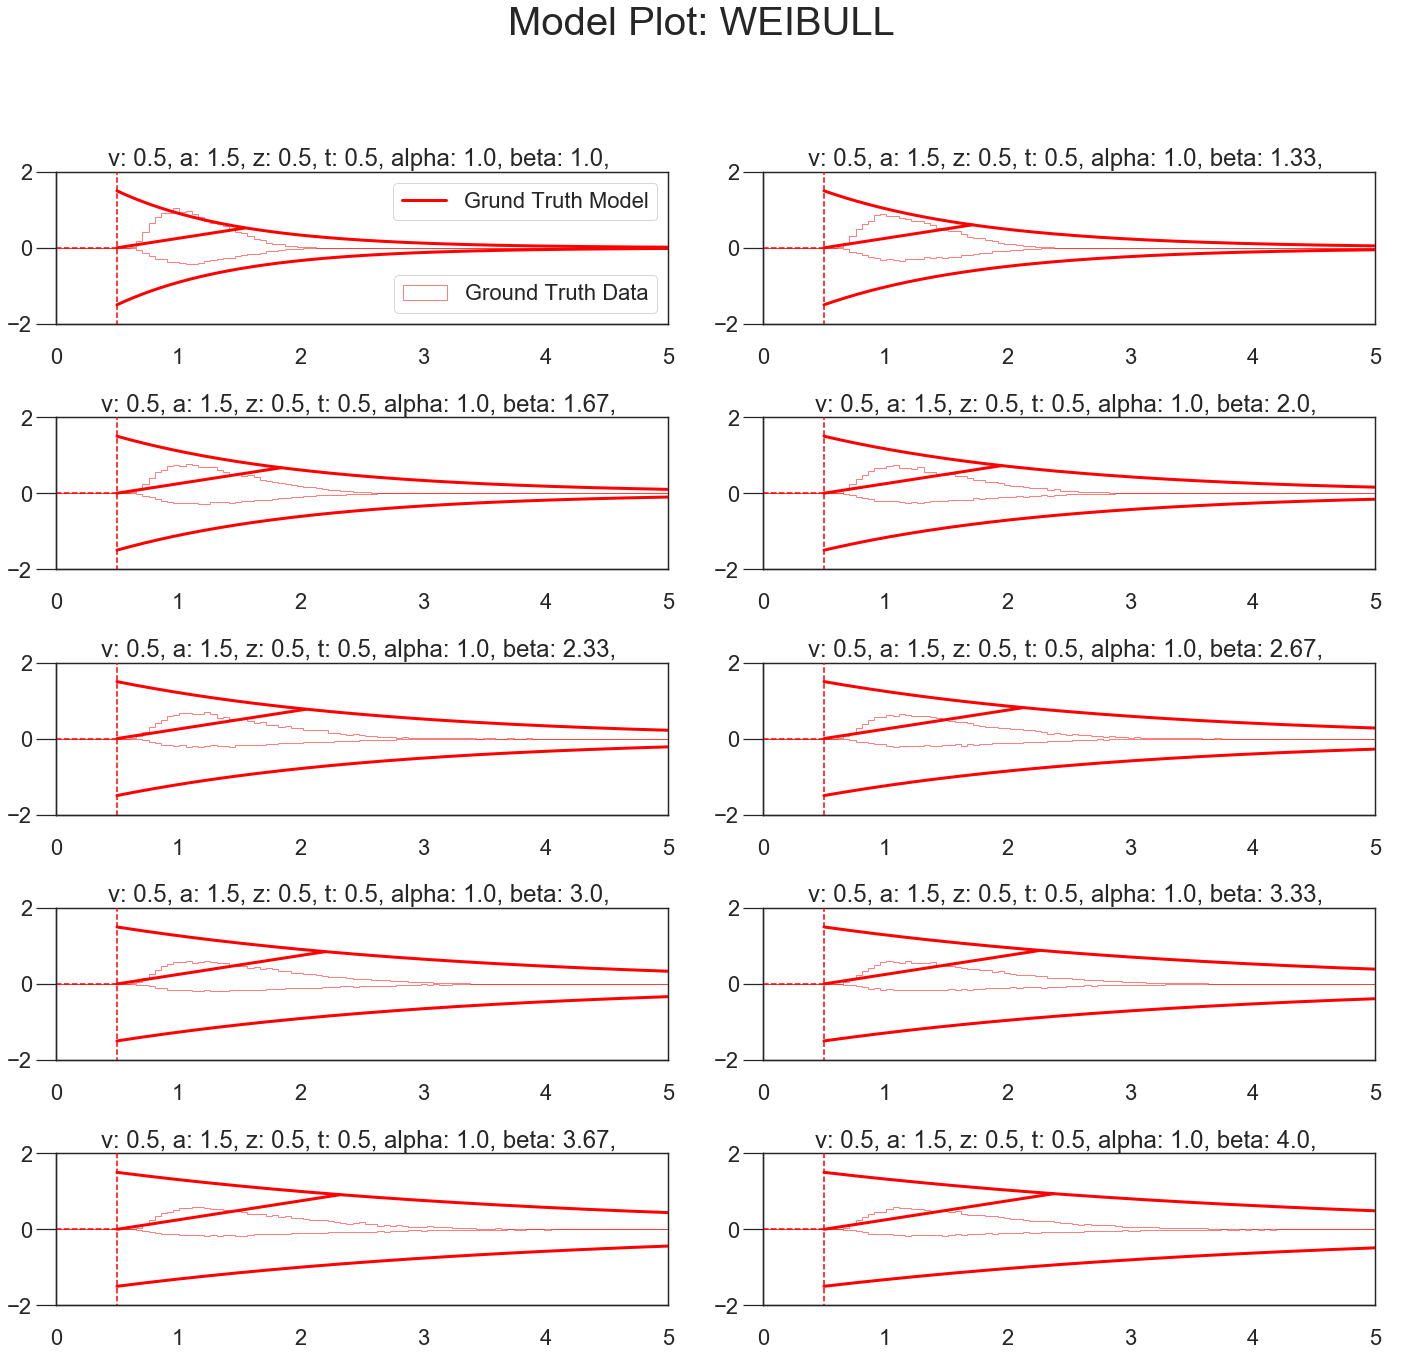

In [35]:
# Plotting the data
weibull_params = make_parameter_sets(model = 'weibull_cdf',
                                   n_parameter_sets = 10,
                                   param_dict = {'a': [1.5],
                                                 'v': [0.5],
                                                 'z': [0.5],
                                                 'alpha': [1],
                                                 'beta': [i for i in np.linspace(1, 4, 10)],
                                                 't': [0.5]})

#Model Plots (Only data)
model_plot(ground_truths_parameters = weibull_params.values,
           cols = 2, 
           model_gt = 'weibull_cdf',
           n_plots = 10,
           max_t = 5,
           show_model = True)

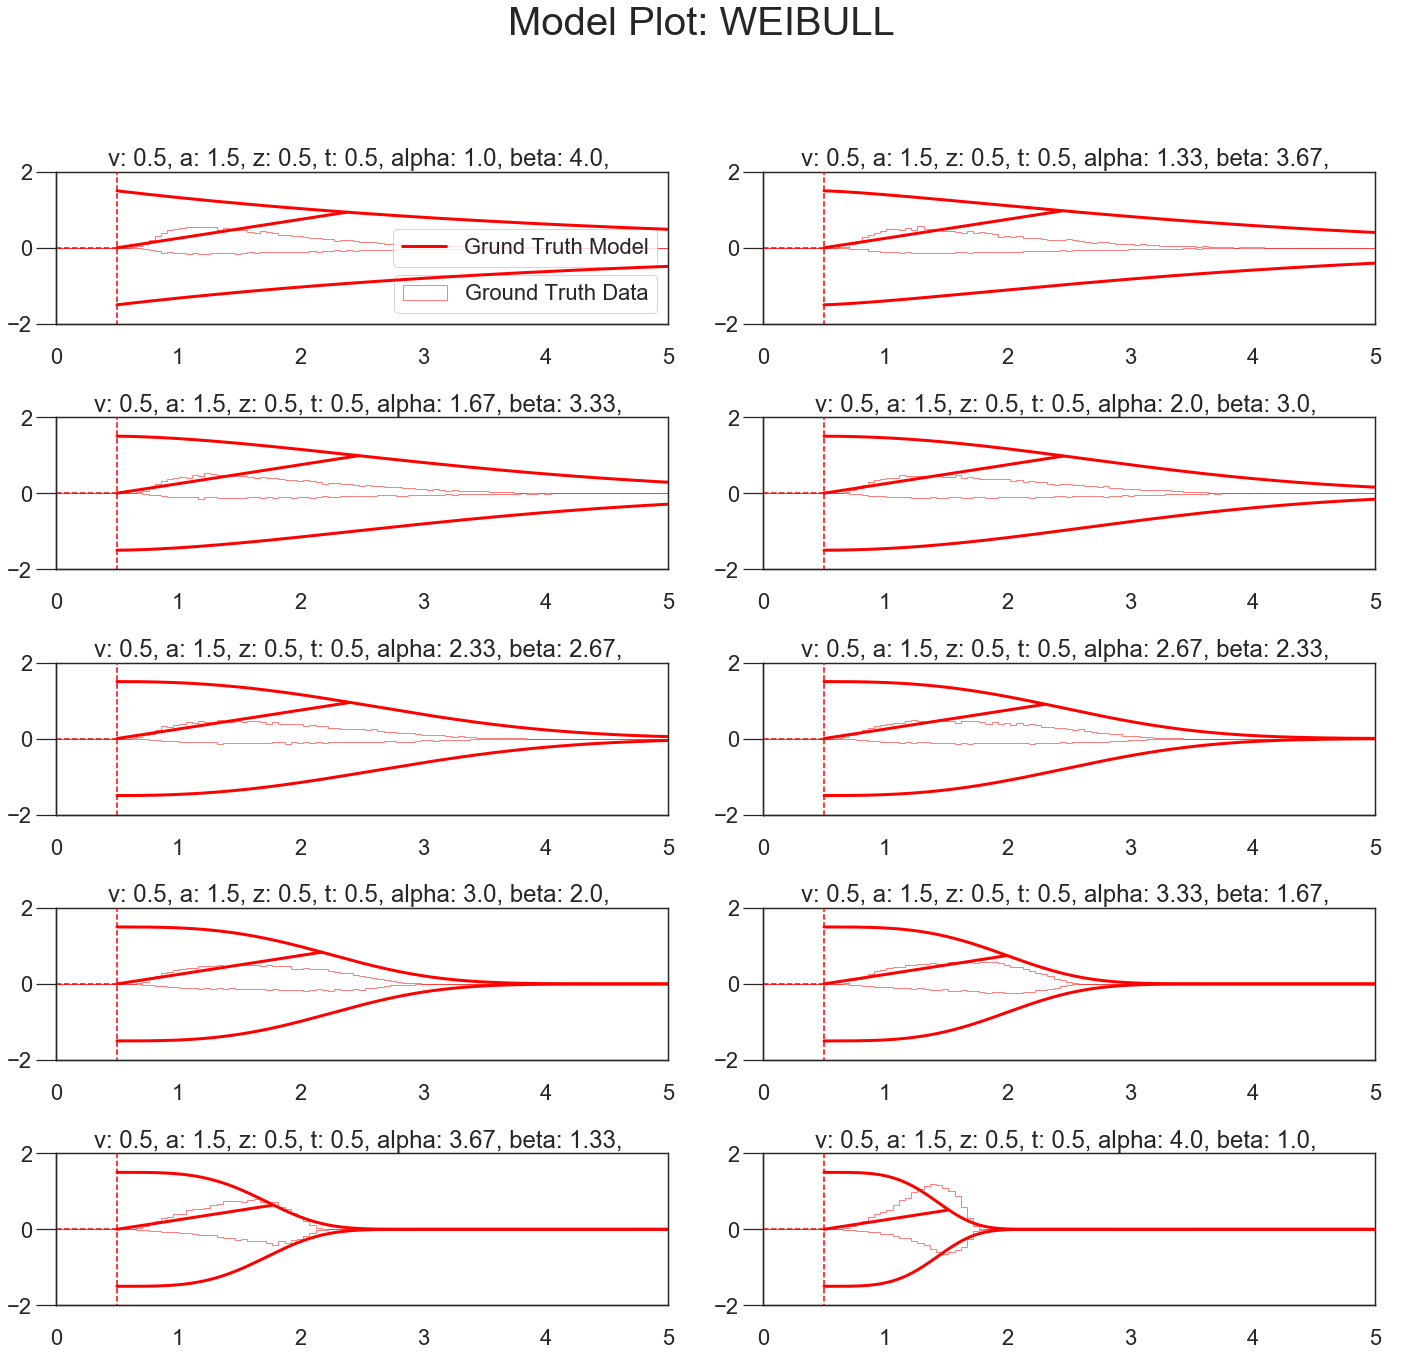

In [36]:
# Plotting the data
weibull_params = make_parameter_sets(model = 'weibull_cdf',
                                   n_parameter_sets = 10,
                                   param_dict = {'a': [1.5],
                                                 'v': [0.5],
                                                 'z': [0.5],
                                                 'alpha': [i for i in np.linspace(1, 4, 10)],
                                                 'beta': [i for i in np.linspace(4, 1, 10)],
                                                 't': [0.5]})

#Model Plots (Only data)
model_plot(ground_truths_parameters = weibull_params.values,
           cols = 2, 
           model_gt = 'weibull_cdf',
           n_plots = 10,
           max_t = 5,
           show_model = True)

### Pre-Section 2: Estimation for Single Subjects (collapsed data)

### LEVY

In [67]:
levy_params =  make_parameter_sets(model = 'levy',
                                   n_parameter_sets = 1)

simulations = simulator(theta = levy_params.values[0],
                        model = 'levy', 
                        n_samples = 3000)

hddm_data_levy_single_subject = hddm_preprocess(simulations)

In [68]:
hddm_data_levy_single_subject

rt  response  nn_response subj_idx
0     2.224583         1            1     none
1     2.074584         0           -1     none
2     1.385590         1            1     none
3     1.581590         0           -1     none
4     1.836588         0           -1     none
...        ...       ...          ...      ...
2995  2.409582         0           -1     none
2996  1.925586         0           -1     none
2997  1.494590         1            1     none
2998  1.928586         0           -1     none
2999  1.508590         0           -1     none

[3000 rows x 4 columns]

In [69]:
levy_params

v        a         z     alpha        t
0 -1.970689  0.99234  0.567027  1.488591  1.37859

In [70]:
# Defining a hddm model
# hddm_model_levy_single_subject = hddm.HDDMnn(hddm_data_levy_single_subject, 
#                                              model = 'levy',
#                                               informative = False, 
#                                               free = False, 
#                                               k = True,
#                                               include = ['z'],
#                                               is_group_model = False)

# Defining a hddm model
hddm_model_levy_single_subject = hddm.HDDMnn(hddm_data_levy_single_subject, 
                                             model = 'levy',
                                             informative = False,
                                             include = ['z', 'alpha'],
                                             is_group_model = False)

knodes
OrderedDict([('a_bottom', a), ('v_bottom', v), ('t_bottom', t), ('z_trans', z_trans), ('z_bottom', z), ('alpha_bottom', alpha)])
wfpt parents: 
OrderedDict([('a', a), ('v', v), ('t', t), ('sv', 0), ('sz', 0), ('st', 0), ('z', z), ('p_outlier', 0), ('alpha', alpha)])


In [71]:
nmcmc = 1000
hddm_model_levy_single_subject.sample(nmcmc, 
                                      burn = 100)

 [-----------------100%-----------------] 1000 of 1000 complete in 66.9 sec

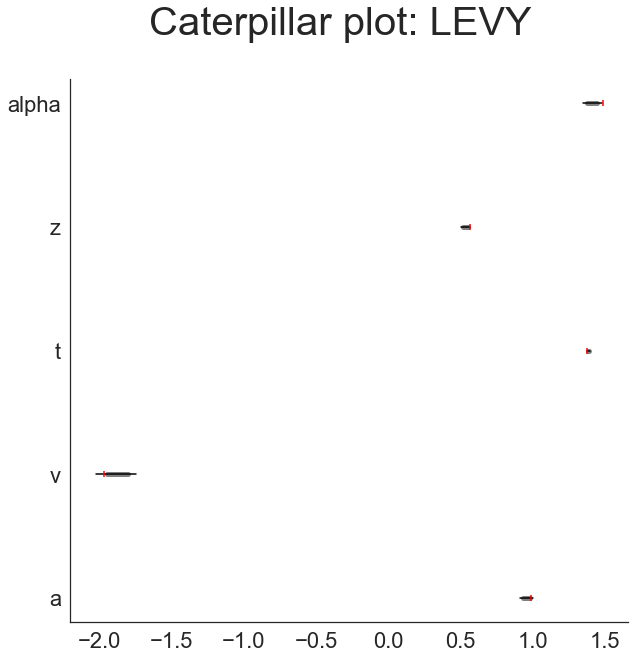

In [72]:
# Caterpillar Plot: (Parameters recovered ok?)
caterpillar_plot(posterior_samples = hddm_model_levy_single_subject.get_traces(),
                 ground_truths = levy_params.values[0], #weibull_params.values[0],
                 model = 'levy',
                 datatype = 'single_subject',
                 drop_sd = True)

In [72]:
simulations = simulator(theta = levy_params.values[0],
                        model = 'levy',
                        n_samples = 20000)

posterior_predictive_plot(posterior_samples = hddm_model_levy_single_subject.get_traces(), #hddm_model_weibull_single_subject.get_traces(),
                          ground_truths_parameters = levy_params.values[0], #weibull_params.values[0],
                          ground_truths_data = np.concatenate([simulations[0], simulations[1]], axis = 1), # None
                          n_plots = 1,
                          cols = 1,
                          model_fitted = 'levy',
                          model_gt = None, #'levy', #'weibull_cdf',
                          datatype = 'single_subject',
                          n_post_params = 200,
                          samples_by_param = 100,
                          xlimit = 10,
                          bin_size = 0.025, 
                          hist_linewidth = 3)

NameError: name 'levy_params' is not defined

In [66]:
hddm_model_levy_single_subject.gen_stats()

mean         std      2.5q       25q       50q       75q     97.5q  \
a      0.872675   0.0373132  0.806987  0.846866  0.870019  0.896763  0.955455   
v      -2.13943     0.10443  -2.33998  -2.20949  -2.13919  -2.07214  -1.93934   
t      0.859856  0.00549368  0.848149  0.856417  0.860184  0.863724  0.869551   
z      0.456327   0.0228041  0.413024  0.440446  0.455945  0.471337   0.50416   
alpha   1.35693    0.041303   1.27345    1.3301   1.35658   1.38547   1.43587   

            mc err  
a        0.0025578  
v       0.00755886  
t      0.000285478  
z       0.00163465  
alpha   0.00233298

### DDM

In [3]:
ddm_params = make_parameter_sets(model = 'ddm',
                                 n_parameter_sets = 1)

simulations = simulator(theta = ddm_params.values[0],
                        model = 'ddm',
                        n_samples = 3000)

hddm_data_ddm_single_subject = hddm_preprocess(simulations)

In [4]:
# Defining a hddm model
hddm_model_ddm_single_subject = hddm.HDDMnn(hddm_data_ddm_single_subject, 
                                                model = 'ddm',
                                                informative = False,
                                                include = ['z'],
                                                is_group_model = False)


hddm_model_ddm_analytic_single_subject = hddm.HDDMnn(hddm_data_ddm_single_subject, 
                                                         model = 'ddm_analytic',
                                                         informative = False,
                                                         include = ['z'],
                                                         is_group_model = False)

knodes
OrderedDict([('a_bottom', a), ('v_bottom', v), ('t_bottom', t), ('z_trans', z_trans), ('z_bottom', z)])
wfpt parents: 
OrderedDict([('a', a), ('v', v), ('t', t), ('sv', 0), ('sz', 0), ('st', 0), ('z', z), ('p_outlier', 0)])
knodes
OrderedDict([('a_bottom', a), ('v_bottom', v), ('t_bottom', t), ('z_trans', z_trans), ('z_bottom', z)])
wfpt parents: 
OrderedDict([('a', a), ('v', v), ('t', t), ('sv', 0), ('sz', 0), ('st', 0), ('z', z), ('p_outlier', 0)])


In [5]:
nmcmc = 300
hddm_model_ddm_single_subject.sample(nmcmc, 
                                     burn = 100)

 [-----------------100%-----------------] 300 of 300 complete in 21.2 sec

In [6]:
nmcmc = 300
hddm_model_ddm_analytic_single_subject.sample(nmcmc, 
                                              burn = 100)

 [-----------------100%-----------------] 300 of 300 complete in 19.6 sec

In [7]:
simulations = simulator(theta = ddm_params.values[0],
                        model = 'ddm',
                        n_samples = 20000)

/Users/afengler/opt/miniconda3/envs/hddm_dev/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/afengler/opt/miniconda3/envs/hddm_dev/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


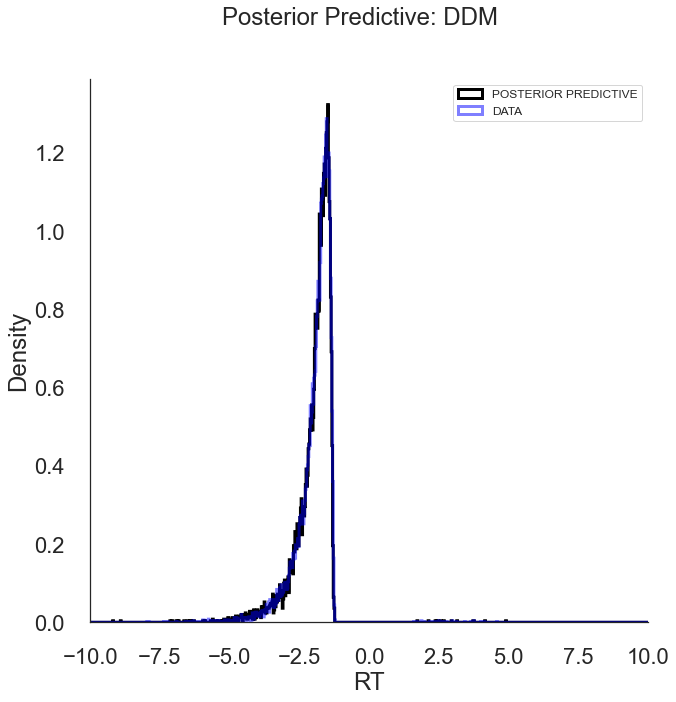

In [8]:
posterior_predictive_plot(posterior_samples = hddm_model_ddm_single_subject.get_traces(), #hddm_model_weibull_single_subject.get_traces(),
                          ground_truths_parameters = ddm_params.values[0], #weibull_params.values[0],
                          ground_truths_data = np.concatenate([simulations[0], simulations[1]], axis = 1), # None
                          n_plots = 1,
                          cols = 1,
                          model_fitted = 'ddm',
                          model_gt = None, #'ddm', #'weibull_cdf',
                          datatype = 'single_subject',
                          n_post_params = 100,
                          samples_by_param = 100,
                          xlimit = 10,
                          bin_size = 0.025, 
                          hist_linewidth = 3)

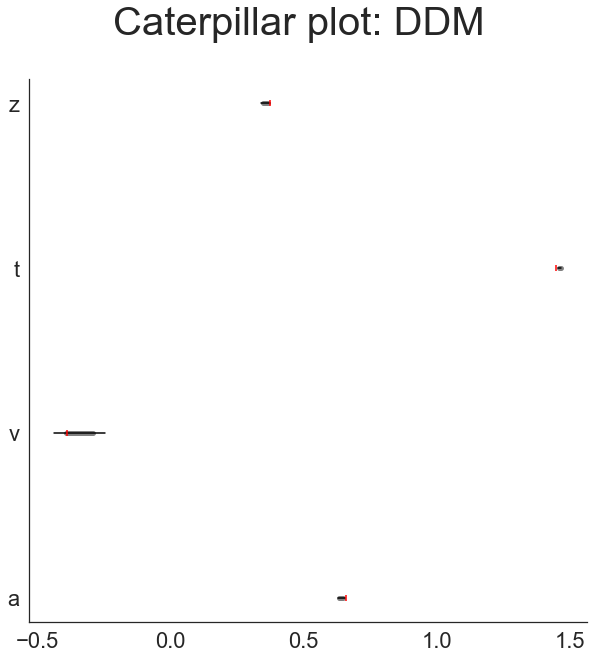

In [87]:
# Caterpillar Plot: (Parameters recovered ok?)
caterpillar_plot(posterior_samples = hddm_model_ddm_single_subject.get_traces(),
                 ground_truths = ddm_params.values[0], #weibull_params.values[0],
                 model = 'ddm',
                 datatype = 'single_subject',
                 drop_sd = True)

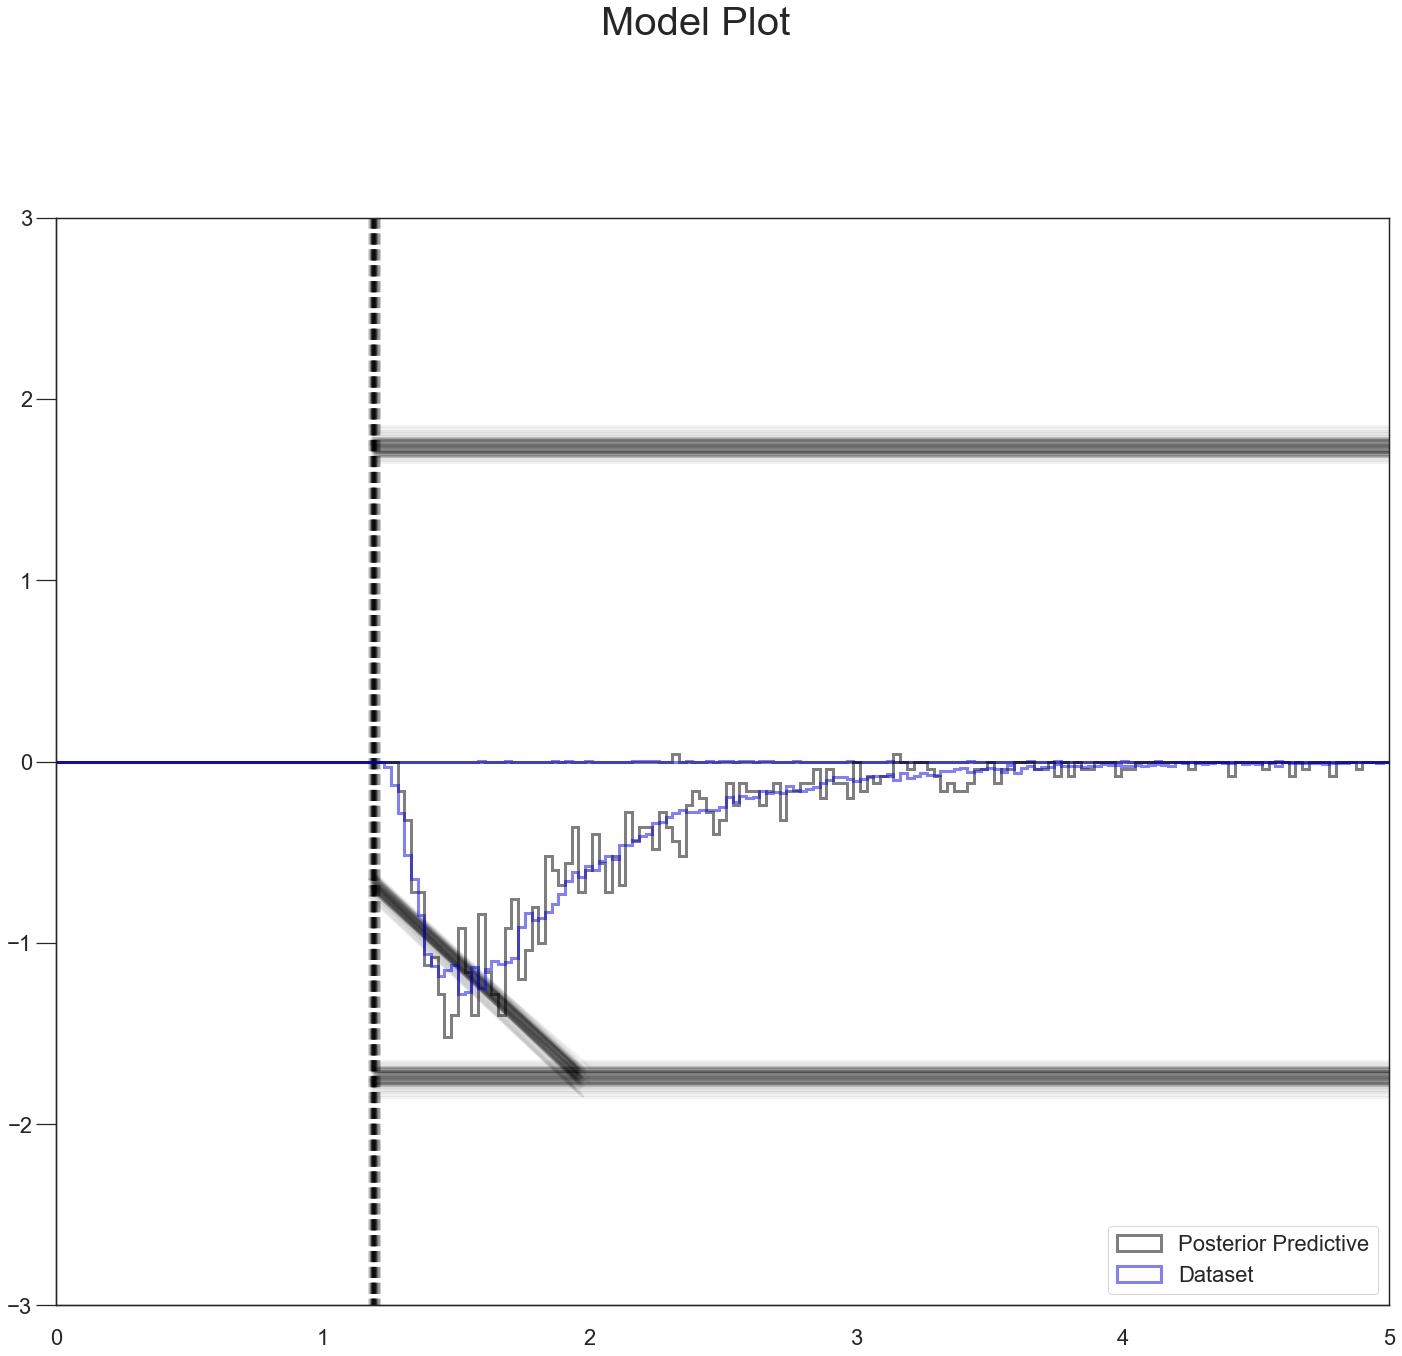

In [9]:
model_plot(ground_truths_parameters = None,
           ground_truths_data = np.concatenate([simulations[0], simulations[1]], axis = 1),
           posterior_samples = hddm_model_ddm_single_subject.get_traces(),
           model_gt = None,
           model_fitted = 'ddm',
           n_post_params = 100,
           cols = 1,
           n_plots = 1,
           max_t = 5, 
           show_model = True,
           input_hddm_trace = True,
           datatype = 'single_subject',
           ylimit = 3,
           posterior_linewidth = 3,
           gt_linewidth = 1,
           hist_linewidth = 3,)

/Users/afengler/opt/miniconda3/envs/hddm_dev/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/afengler/opt/miniconda3/envs/hddm_dev/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


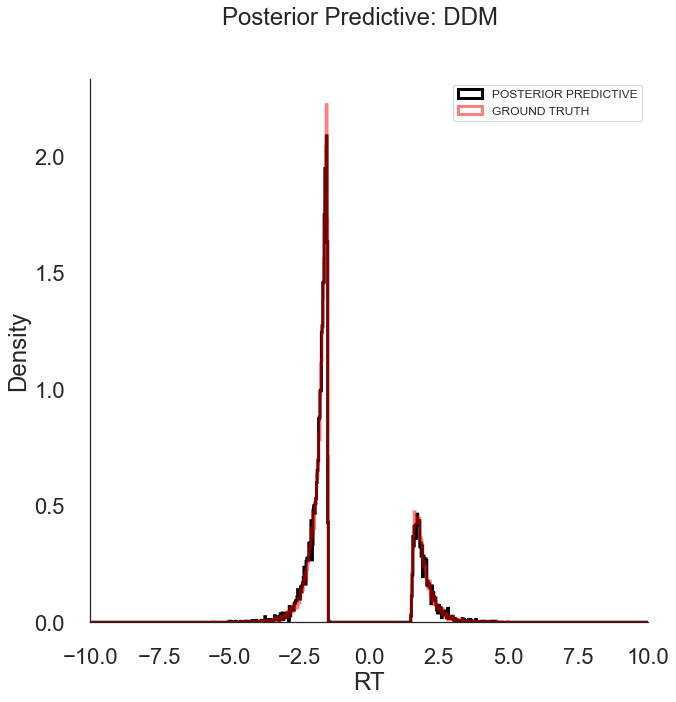

In [88]:
posterior_predictive_plot(posterior_samples = hddm_model_ddm_analytic_single_subject.get_traces(), #hddm_model_weibull_single_subject.get_traces(),
                          ground_truths_parameters = ddm_params.values[0], #weibull_params.values[0],
                          ground_truths_data = np.concatenate([simulations[0], simulations[1]], axis = 1), # None
                          n_plots = 1,
                          cols = 1,
                          model_fitted = 'ddm',
                          model_gt = 'ddm', #'weibull_cdf',
                          datatype = 'single_subject',
                          n_post_params = 100,
                          samples_by_param = 100,
                          xlimit = 10,
                          bin_size = 0.025, 
                          hist_linewidth = 3)

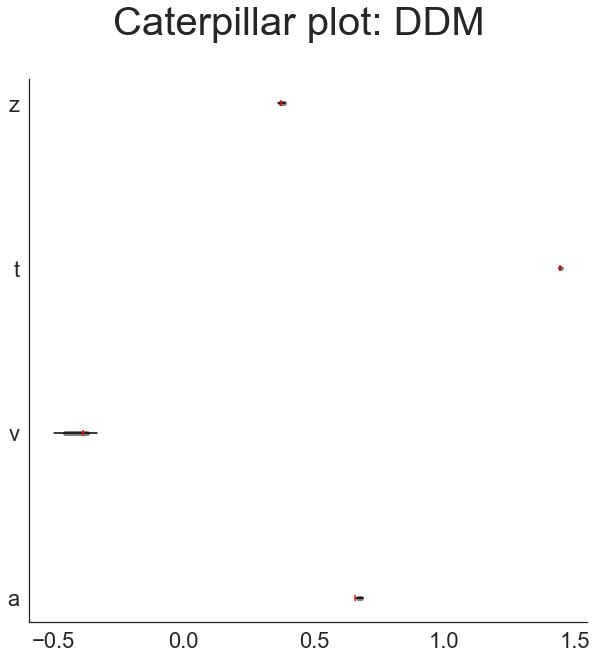

In [89]:
# Caterpillar Plot: (Parameters recovered ok?)
caterpillar_plot(posterior_samples = hddm_model_ddm_analytic_single_subject.get_traces(),
                 ground_truths = ddm_params.values[0], #weibull_params.values[0],
                 model = 'ddm',
                 datatype = 'single_subject',
                 drop_sd = True)

In [90]:
# Defining a hddm model
hddm_model_ddm_hddm_single_subject = hddm.HDDM(hddm_data_ddm_single_subject,
                                               informative = False,
                                               include = ['z'],
                                               is_group_model = False,
                                               p_outlier = 0.0)

In [91]:
nmcmc = 1000
hddm_model_ddm_hddm_single_subject.sample(nmcmc, 
                                          burn = 100)

 [-----------------100%-----------------] 1000 of 1000 complete in 20.9 sec

In [92]:
ddm_hddm_trace = hddm_model_ddm_hddm_single_subject.get_traces()
ddm_hddm_trace['a'] = ddm_hddm_trace['a'] / 2

In [20]:
ddm_hddm_trace

a         v         t   z_trans
0    1.261760  0.614616  1.693058 -0.388112
1    1.262844  0.600204  1.683011 -0.452928
2    1.258495  0.617040  1.686200 -0.444242
3    1.260578  0.613060  1.684522 -0.435203
4    1.261183  0.629273  1.686838 -0.417543
..        ...       ...       ...       ...
895  1.237920  0.600991  1.693507 -0.363835
896  1.247082  0.620599  1.699340 -0.405486
897  1.253863  0.606516  1.697525 -0.401529
898  1.260562  0.625456  1.694125 -0.409490
899  1.262452  0.611046  1.688998 -0.396013

[900 rows x 4 columns]

/Users/afengler/opt/miniconda3/envs/hddm_dev/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/afengler/opt/miniconda3/envs/hddm_dev/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


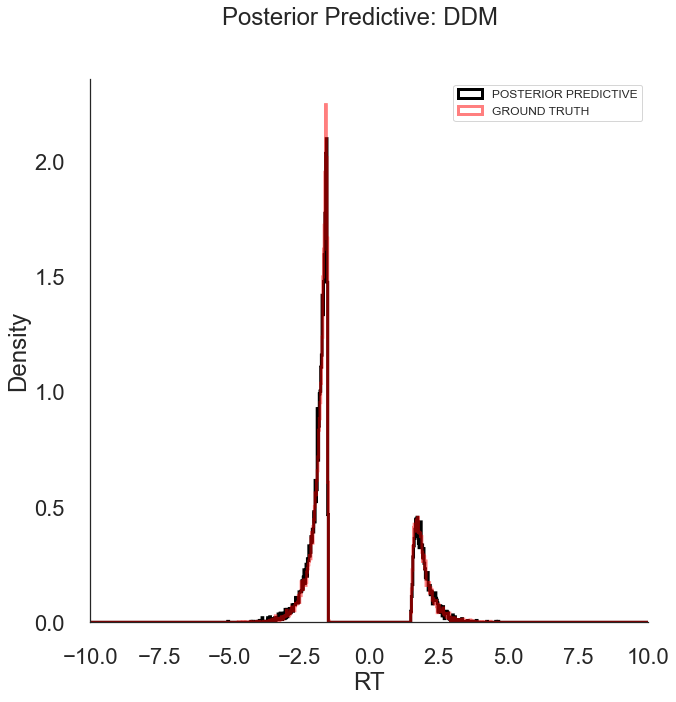

In [93]:
posterior_predictive_plot(posterior_samples = ddm_hddm_trace, #hddm_model_weibull_single_subject.get_traces(),
                          ground_truths_parameters = ddm_params.values[0], #weibull_params.values[0],
                          ground_truths_data = np.concatenate([simulations[0], simulations[1]], axis = 1), # None
                          n_plots = 1,
                          cols = 1,
                          model_fitted = 'ddm',
                          model_gt = 'ddm', #'weibull_cdf',
                          datatype = 'single_subject',
                          n_post_params = 100,
                          samples_by_param = 100,
                          xlimit = 10,
                          bin_size = 0.025, 
                          hist_linewidth = 3)

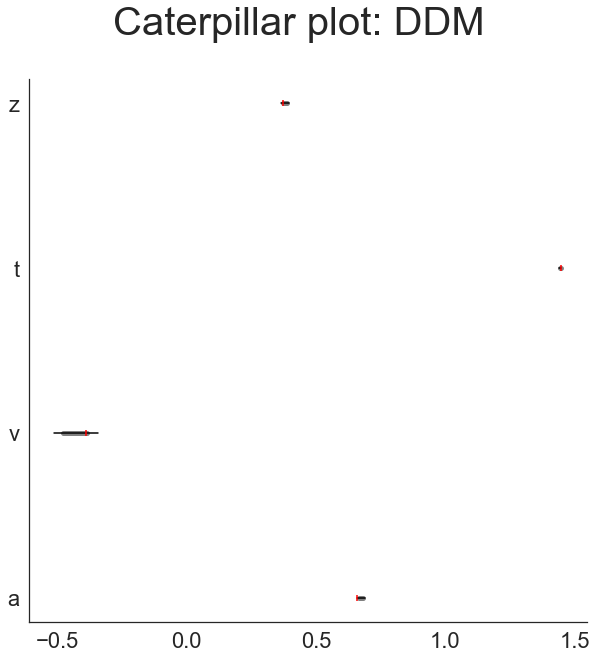

In [94]:
# Caterpillar Plot: (Parameters recovered ok?)
caterpillar_plot(posterior_samples = ddm_hddm_trace,
                 ground_truths = ddm_params.values[0], #weibull_params.values[0],
                 model = 'ddm',
                 datatype = 'single_subject',
                 drop_sd = True)

In [20]:
hddm_model_ddm_hddm_single_subject.gen_stats()

mean          std      2.5q       25q       50q       75q     97.5q  \
a   1.99906  0.000945685   1.99648   1.99869   1.99939   1.99976   1.99998   
v -0.565112    0.0237555 -0.611862 -0.580828 -0.566002 -0.549567 -0.514938   
t  0.254554   0.00409425  0.246532  0.251707  0.254715  0.257343  0.262271   
z   0.43255   0.00720844  0.419017  0.427561  0.432193  0.437611  0.446604   

        mc err  
a  5.57358e-05  
v   0.00104566  
t  0.000201566  
z  0.000380085

In [95]:
hddm_model_ddm_analytic_single_subject.dic

3121.607503255208

In [96]:
hddm_model_ddm_single_subject.dic

3183.6488205295136

In [97]:
hddm_model_ddm_hddm_single_subject.dic

3147.6020018973163

### DDM SDV

In [23]:
ddm_sdv_params =  make_parameter_sets(model = 'ddm_sdv',
                                      n_parameter_sets = 1)

simulations = simulator(theta = ddm_sdv_params.values[0],
                        model = 'ddm_sdv', 
                        n_samples = 3000)

hddm_data_ddm_sdv_single_subject = hddm_preprocess(simulations)

In [24]:
# Defining a hddm model
hddm_model_ddm_sdv_single_subject = hddm.HDDMnn(hddm_data_ddm_sdv_single_subject, 
                                                model = 'ddm_sdv',
                                                informative = False,
                                                include = ['z', 'sv'],
                                                is_group_model = False)


hddm_model_ddm_sdv_analytic_single_subject = hddm.HDDMnn(hddm_data_ddm_sdv_single_subject, 
                                                         model = 'ddm_sdv_analytic',
                                                         informative = False,
                                                         include = ['z', 'sv'],
                                                         is_group_model = False)

knodes
OrderedDict([('a_bottom', a), ('v_bottom', v), ('t_bottom', t), ('z_trans', z_trans), ('z_bottom', z), ('sv_bottom', sv)])
wfpt parents: 
OrderedDict([('a', a), ('v', v), ('t', t), ('sv', sv), ('sz', 0), ('st', 0), ('z', z), ('p_outlier', 0)])
knodes
OrderedDict([('a_bottom', a), ('v_bottom', v), ('t_bottom', t), ('z_trans', z_trans), ('z_bottom', z), ('sv_bottom', sv)])
wfpt parents: 
OrderedDict([('a', a), ('v', v), ('t', t), ('sv', sv), ('sz', 0), ('st', 0), ('z', z), ('p_outlier', 0)])


In [46]:
nmcmc = 1000
hddm_model_ddm_sdv_single_subject.sample(nmcmc, 
                                         burn = 100)

 [-----------------100%-----------------] 1001 of 1000 complete in 74.0 sec

In [47]:
nmcmc = 1000
hddm_model_ddm_sdv_analytic_single_subject.sample(nmcmc, 
                                                  burn = 100)

 [-----------------100%-----------------] 1000 of 1000 complete in 66.2 sec

In [51]:
simulations = simulator(theta = ddm_sdv_params.values[0],
                        model = 'ddm_sdv',
                        n_samples = 20000)

/Users/afengler/opt/miniconda3/envs/hddm_dev/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/afengler/opt/miniconda3/envs/hddm_dev/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


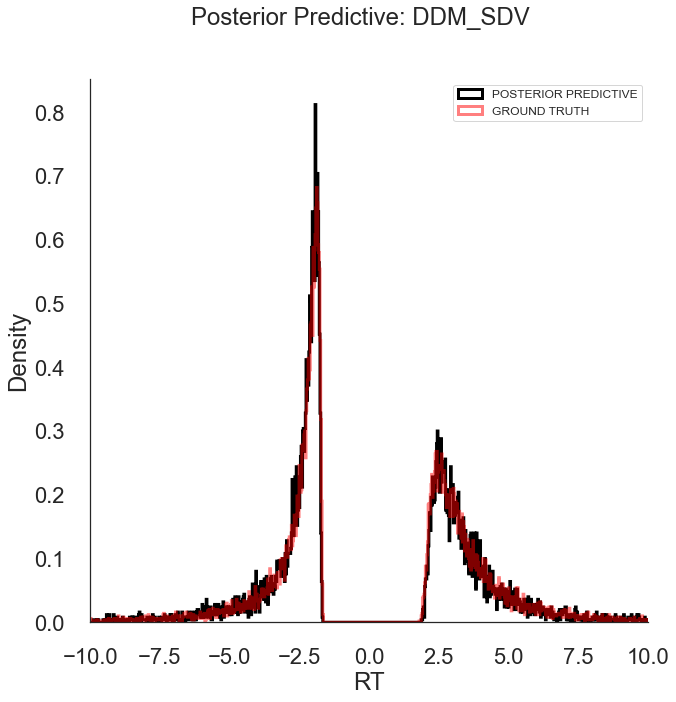

In [52]:
posterior_predictive_plot(posterior_samples = hddm_model_ddm_sdv_single_subject.get_traces(), #hddm_model_weibull_single_subject.get_traces(),
                          ground_truths_parameters = ddm_sdv_params.values[0], #weibull_params.values[0],
                          ground_truths_data = np.concatenate([simulations[0], simulations[1]], axis = 1), # None
                          n_plots = 1,
                          cols = 1,
                          model_fitted = 'ddm_sdv',
                          model_gt = 'ddm_sdv', #'weibull_cdf',
                          datatype = 'single_subject',
                          n_post_params = 100,
                          samples_by_param = 100,
                          xlimit = 10,
                          bin_size = 0.025, 
                          hist_linewidth = 3)

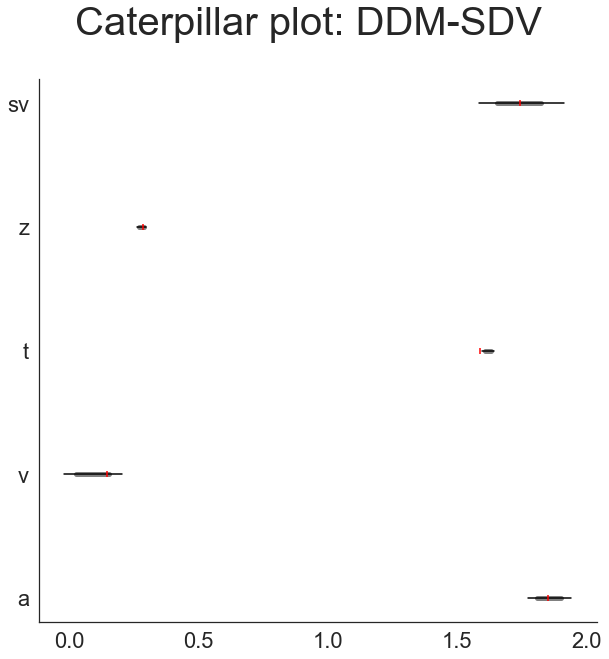

In [53]:
# Caterpillar Plot: (Parameters recovered ok?)
caterpillar_plot(posterior_samples = hddm_model_ddm_sdv_single_subject.get_traces(),
                 ground_truths = ddm_sdv_params.values[0], #weibull_params.values[0],
                 model = 'ddm_sdv',
                 datatype = 'single_subject',
                 drop_sd = True)

/Users/afengler/opt/miniconda3/envs/hddm_dev/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/afengler/opt/miniconda3/envs/hddm_dev/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


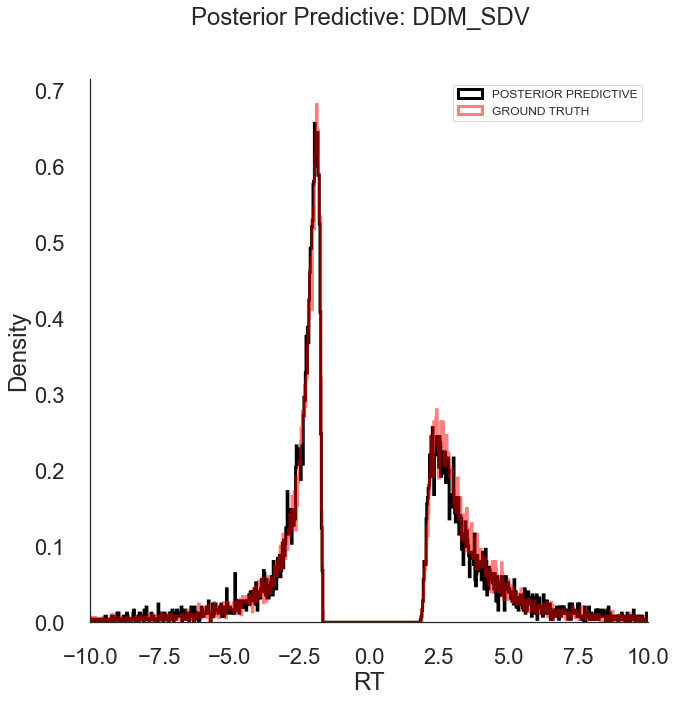

In [54]:
posterior_predictive_plot(posterior_samples = hddm_model_ddm_sdv_analytic_single_subject.get_traces(), #hddm_model_weibull_single_subject.get_traces(),
                          ground_truths_parameters = ddm_sdv_params.values[0], #weibull_params.values[0],
                          ground_truths_data = np.concatenate([simulations[0], simulations[1]], axis = 1), # None
                          n_plots = 1,
                          cols = 1,
                          model_fitted = 'ddm_sdv',
                          model_gt = 'ddm_sdv', #'weibull_cdf',
                          datatype = 'single_subject',
                          n_post_params = 100,
                          samples_by_param = 100,
                          xlimit = 10,
                          bin_size = 0.025, 
                          hist_linewidth = 3)

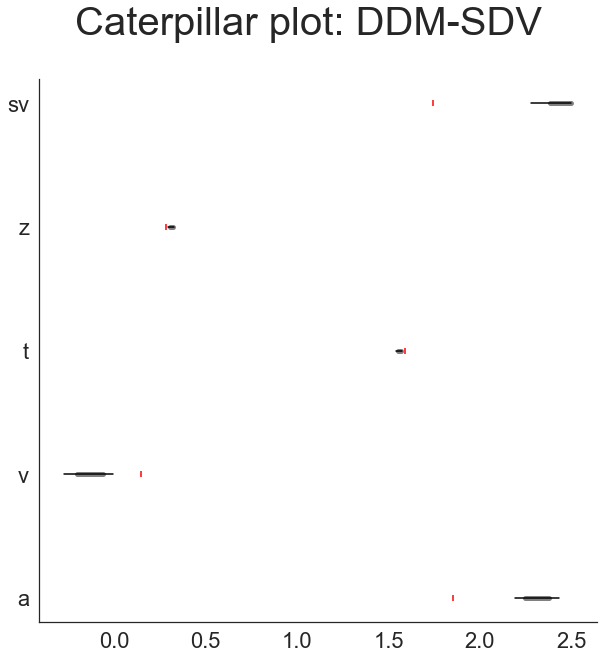

In [55]:
# Caterpillar Plot: (Parameters recovered ok?)
caterpillar_plot(posterior_samples = hddm_model_ddm_sdv_analytic_single_subject.get_traces(),
                 ground_truths = ddm_sdv_params.values[0], #weibull_params.values[0],
                 model = 'ddm_sdv',
                 datatype = 'single_subject',
                 drop_sd = True)

In [65]:
# Defining a hddm model
hddm_model_ddm_sdv_hddm_single_subject = hddm.HDDM(hddm_data_ddm_sdv_single_subject,
                                                   informative = False,
                                                   include = ['z', 'sv'],
                                                   is_group_model = False,
                                                   p_outlier = 0.0)

In [66]:
nmcmc = 1000
hddm_model_ddm_sdv_hddm_single_subject.sample(nmcmc, 
                                              burn = 100)

 [-----------------100%-----------------] 1000 of 1000 complete in 27.8 sec

In [67]:
ddm_sdv_hddm_trace = hddm_model_ddm_sdv_hddm_single_subject.get_traces()
ddm_sdv_hddm_trace['a'] = ddm_sdv_hddm_trace['a'] / 2

/Users/afengler/opt/miniconda3/envs/hddm_dev/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/afengler/opt/miniconda3/envs/hddm_dev/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


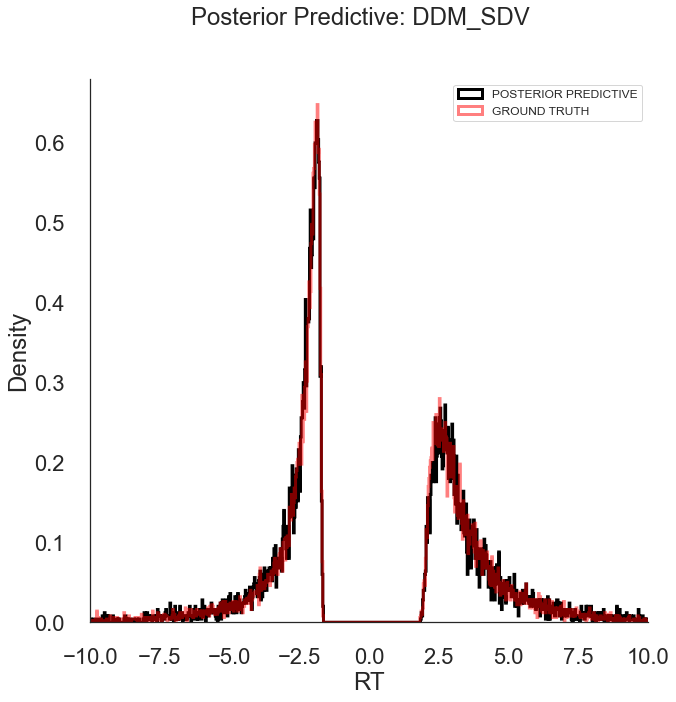

In [68]:
posterior_predictive_plot(posterior_samples = ddm_sdv_hddm_trace, #hddm_model_weibull_single_subject.get_traces(),
                          ground_truths_parameters = ddm_sdv_params.values[0], #weibull_params.values[0],
                          ground_truths_data = np.concatenate([simulations[0], simulations[1]], axis = 1), # None
                          n_plots = 1,
                          cols = 1,
                          model_fitted = 'ddm_sdv',
                          model_gt = 'ddm_sdv', #'weibull_cdf',
                          datatype = 'single_subject',
                          n_post_params = 100,
                          samples_by_param = 100,
                          xlimit = 10,
                          bin_size = 0.025, 
                          hist_linewidth = 3)

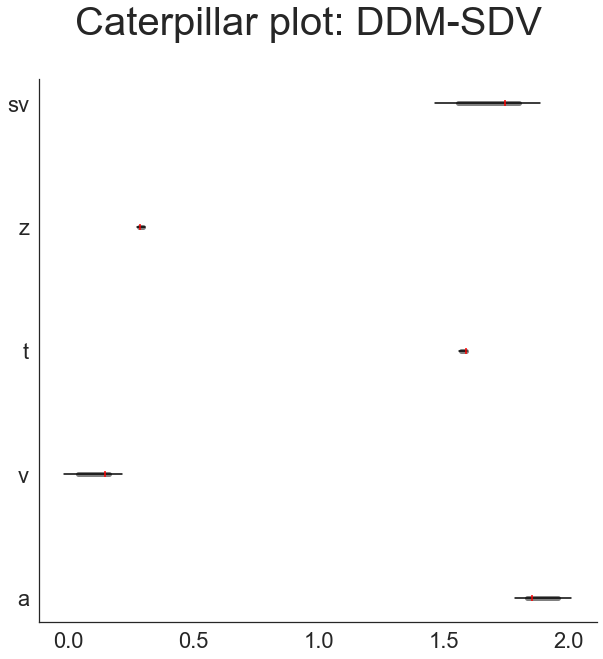

In [69]:
# Caterpillar Plot: (Parameters recovered ok?)
caterpillar_plot(posterior_samples = ddm_sdv_hddm_trace,
                 ground_truths = ddm_sdv_params.values[0], #weibull_params.values[0],
                 model = 'ddm_sdv',
                 datatype = 'single_subject',
                 drop_sd = True)

In [70]:
hddm_model_ddm_sdv_analytic_single_subject.dic

11932.420128038193

In [71]:
hddm_model_ddm_sdv_single_subject.dic

11974.834214409722

In [73]:
hddm_model_ddm_sdv_hddm_single_subject.dic

11965.191891239458

### Angle


In [5]:
angle_params =  make_parameter_sets(model = 'angle',
                                   n_parameter_sets = 1)

simulations = simulator(theta = angle_params.values[0],
                        model = 'angle', 
                        n_samples = 1000)

hddm_data_angle_single_subject = hddm_preprocess(simulations)

In [6]:
hddm_data_angle_single_subject

rt  response  nn_response subj_idx
0    2.081854         0           -1     none
1    2.351851         0           -1     none
2    1.791858         1            1     none
3    1.845857         0           -1     none
4    1.904856         0           -1     none
..        ...       ...          ...      ...
995  1.727858         0           -1     none
996  1.998855         0           -1     none
997  1.626858         0           -1     none
998  2.003855         0           -1     none
999  2.285851         0           -1     none

[1000 rows x 4 columns]

In [7]:
# Defining a hddm model
hddm_model_angle_single_subject = hddm.HDDMnn(hddm_data_angle_single_subject, 
                                              model = 'angle',
                                              informative = False, 
                                              include = ['z', 'theta'],
                                              is_group_model = False)

knodes
OrderedDict([('a_bottom', a), ('v_bottom', v), ('t_bottom', t), ('z_trans', z_trans), ('z_bottom', z), ('theta_bottom', theta)])
wfpt parents: 
OrderedDict([('a', a), ('v', v), ('t', t), ('sv', 0), ('sz', 0), ('st', 0), ('z', z), ('p_outlier', 0), ('theta', theta)])


In [8]:
nmcmc = 1000
hddm_model_angle_single_subject.sample(nmcmc, 
                                      burn = 100)

 [-----------------100%-----------------] 1000 of 1000 complete in 54.6 sec

In [21]:
simulations = simulator(theta = angle_params.values[0],
                        model = 'angle',
                        n_samples = 20000)

posterior_predictive_plot(posterior_samples = hddm_model_angle_single_subject.get_traces(), #hddm_model_weibull_single_subject.get_traces(),
                          ground_truths_parameters = angle_params.values[0], #weibull_params.values[0],
                          ground_truths_data = np.concatenate([simulations[0], simulations[1]], axis = 1), # None
                          n_plots = 1,
                          cols = 1,
                          model_fitted = 'angle',
                          model_gt = 'angle', #'weibull_cdf',
                          datatype = 'single_subject',
                          n_post_params = 200,
                          samples_by_param = 100,
                          xlimit = 10,
                          bin_size = 0.025, 
                          hist_linewidth = 3)

AttributeError: 'Uniform' object has no attribute 'trace'

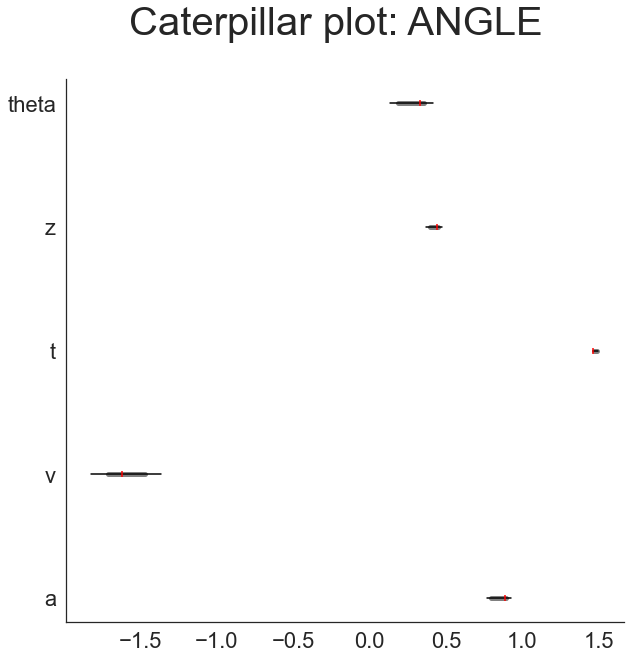

In [11]:
# Caterpillar Plot: (Parameters recovered ok?)
caterpillar_plot(posterior_samples = hddm_model_angle_single_subject.get_traces(),
                 ground_truths = angle_params.values[0], #weibull_params.values[0],
                 model = 'angle',
                 datatype = 'single_subject',
                 drop_sd = True)

### Weibull

In [55]:
weibull_params =  make_parameter_sets(model = 'weibull_cdf_concave',
                                      n_parameter_sets = 1)

simulations = simulator(theta = weibull_params.values[0],
                        model = 'weibull_cdf', 
                        n_samples = 1000)

hddm_data_weibull_single_subject = hddm_preprocess(simulations)

In [56]:
weibull_params

v         a         z         t     alpha     beta
0  0.032521  1.027969  0.515009  0.502549  2.461436  1.19171

In [57]:
# Defining a hddm model
hddm_model_weibull_single_subject = hddm.HDDMnn(hddm_data_weibull_single_subject, 
                                              model = 'weibull',
                                              informative = False, 
                                              include = ['z', 'alpha', 'beta'],
                                              is_group_model = False)

knodes
OrderedDict([('a_bottom', a), ('v_bottom', v), ('t_bottom', t), ('z_trans', z_trans), ('z_bottom', z), ('alpha_bottom', alpha), ('beta_bottom', beta)])
wfpt parents: 
OrderedDict([('a', a), ('v', v), ('t', t), ('sv', 0), ('sz', 0), ('st', 0), ('z', z), ('p_outlier', 0), ('alpha', alpha), ('beta', beta)])


In [58]:
# Defining a hddm model
hddm_model_weibull_concave_single_subject = hddm.HDDMnn(hddm_data_weibull_single_subject, 
                                                        model = 'weibull_cdf_concave',
                                                        informative = False, 
                                                        include = ['z', 'alpha', 'beta'],
                                                        is_group_model = False)

knodes
OrderedDict([('a_bottom', a), ('v_bottom', v), ('t_bottom', t), ('z_trans', z_trans), ('z_bottom', z), ('alpha_bottom', alpha), ('beta_bottom', beta)])
wfpt parents: 
OrderedDict([('a', a), ('v', v), ('t', t), ('sv', 0), ('sz', 0), ('st', 0), ('z', z), ('p_outlier', 0), ('alpha', alpha), ('beta', beta)])


In [59]:
nmcmc = 1000
hddm_model_weibull_single_subject.sample(nmcmc, 
                                         burn = 100)

 [-----------------100%-----------------] 1000 of 1000 complete in 46.2 sec

In [60]:
nmcmc = 1000
hddm_model_weibull_concave_single_subject.sample(nmcmc, 
                                           burn = 100)

 [-----------------100%-----------------] 1001 of 1000 complete in 61.7 sec

In [61]:
simulations = simulator(theta = weibull_params.values[0],
                        model = 'weibull_cdf',
                        n_samples = 20000)

/Users/afengler/opt/miniconda3/envs/hddm_dev/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/afengler/opt/miniconda3/envs/hddm_dev/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


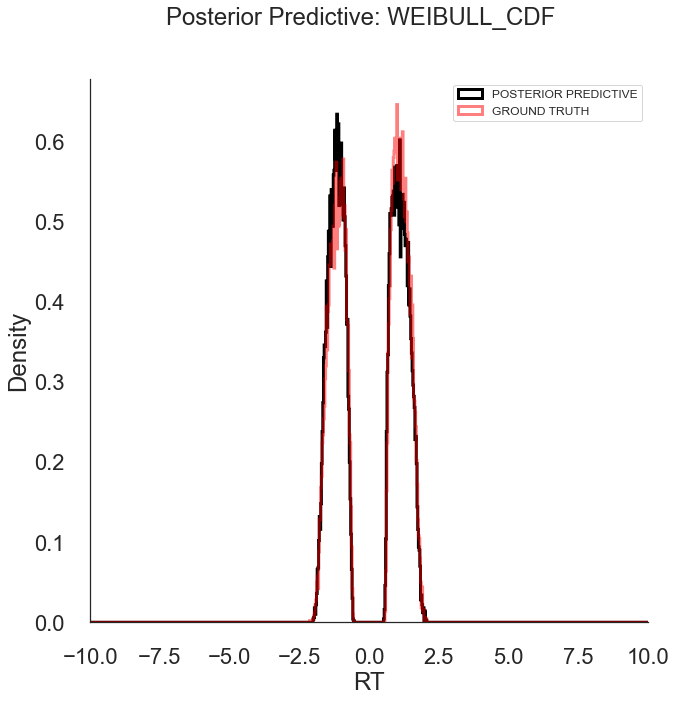

In [62]:
posterior_predictive_plot(posterior_samples = hddm_model_weibull_single_subject.get_traces(), #hddm_model_weibull_single_subject.get_traces(),
                          ground_truths_parameters = weibull_params.values[0], #weibull_params.values[0],
                          ground_truths_data = np.concatenate([simulations[0], simulations[1]], axis = 1), # None
                          n_plots = 1,
                          cols = 1,
                          model_fitted = 'weibull_cdf',
                          model_gt = 'weibull_cdf', #'weibull_cdf',
                          datatype = 'single_subject',
                          n_post_params = 200,
                          samples_by_param = 100,
                          xlimit = 10,
                          bin_size = 0.025, 
                          hist_linewidth = 3)

/Users/afengler/opt/miniconda3/envs/hddm_dev/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/afengler/opt/miniconda3/envs/hddm_dev/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


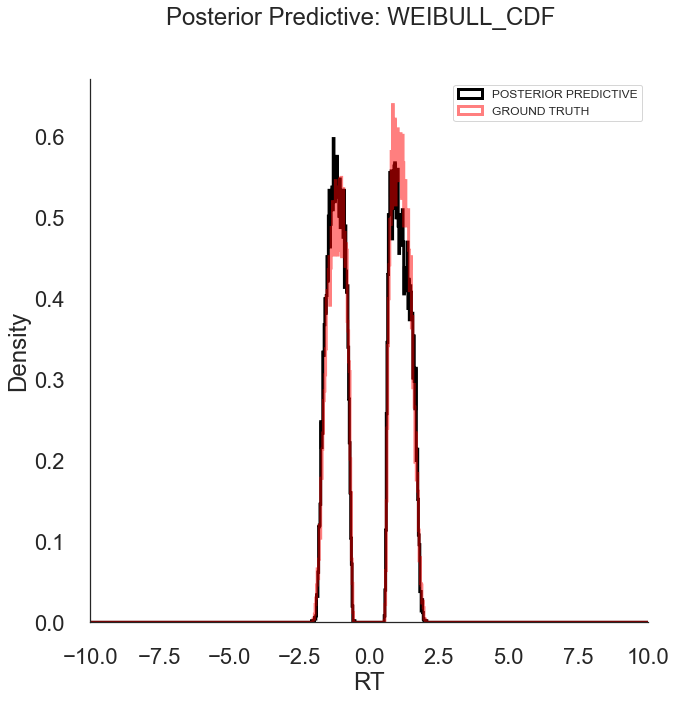

In [63]:
posterior_predictive_plot(posterior_samples = hddm_model_weibull_concave_single_subject.get_traces(), #hddm_model_weibull_single_subject.get_traces(),
                          ground_truths_parameters = weibull_params.values[0], #weibull_params.values[0],
                          ground_truths_data = np.concatenate([simulations[0], simulations[1]], axis = 1), # None
                          n_plots = 1,
                          cols = 1,
                          model_fitted = 'weibull_cdf',
                          model_gt = 'weibull_cdf', #'weibull_cdf',
                          datatype = 'single_subject',
                          n_post_params = 200,
                          samples_by_param = 100,
                          xlimit = 10,
                          bin_size = 0.025, 
                          hist_linewidth = 3)

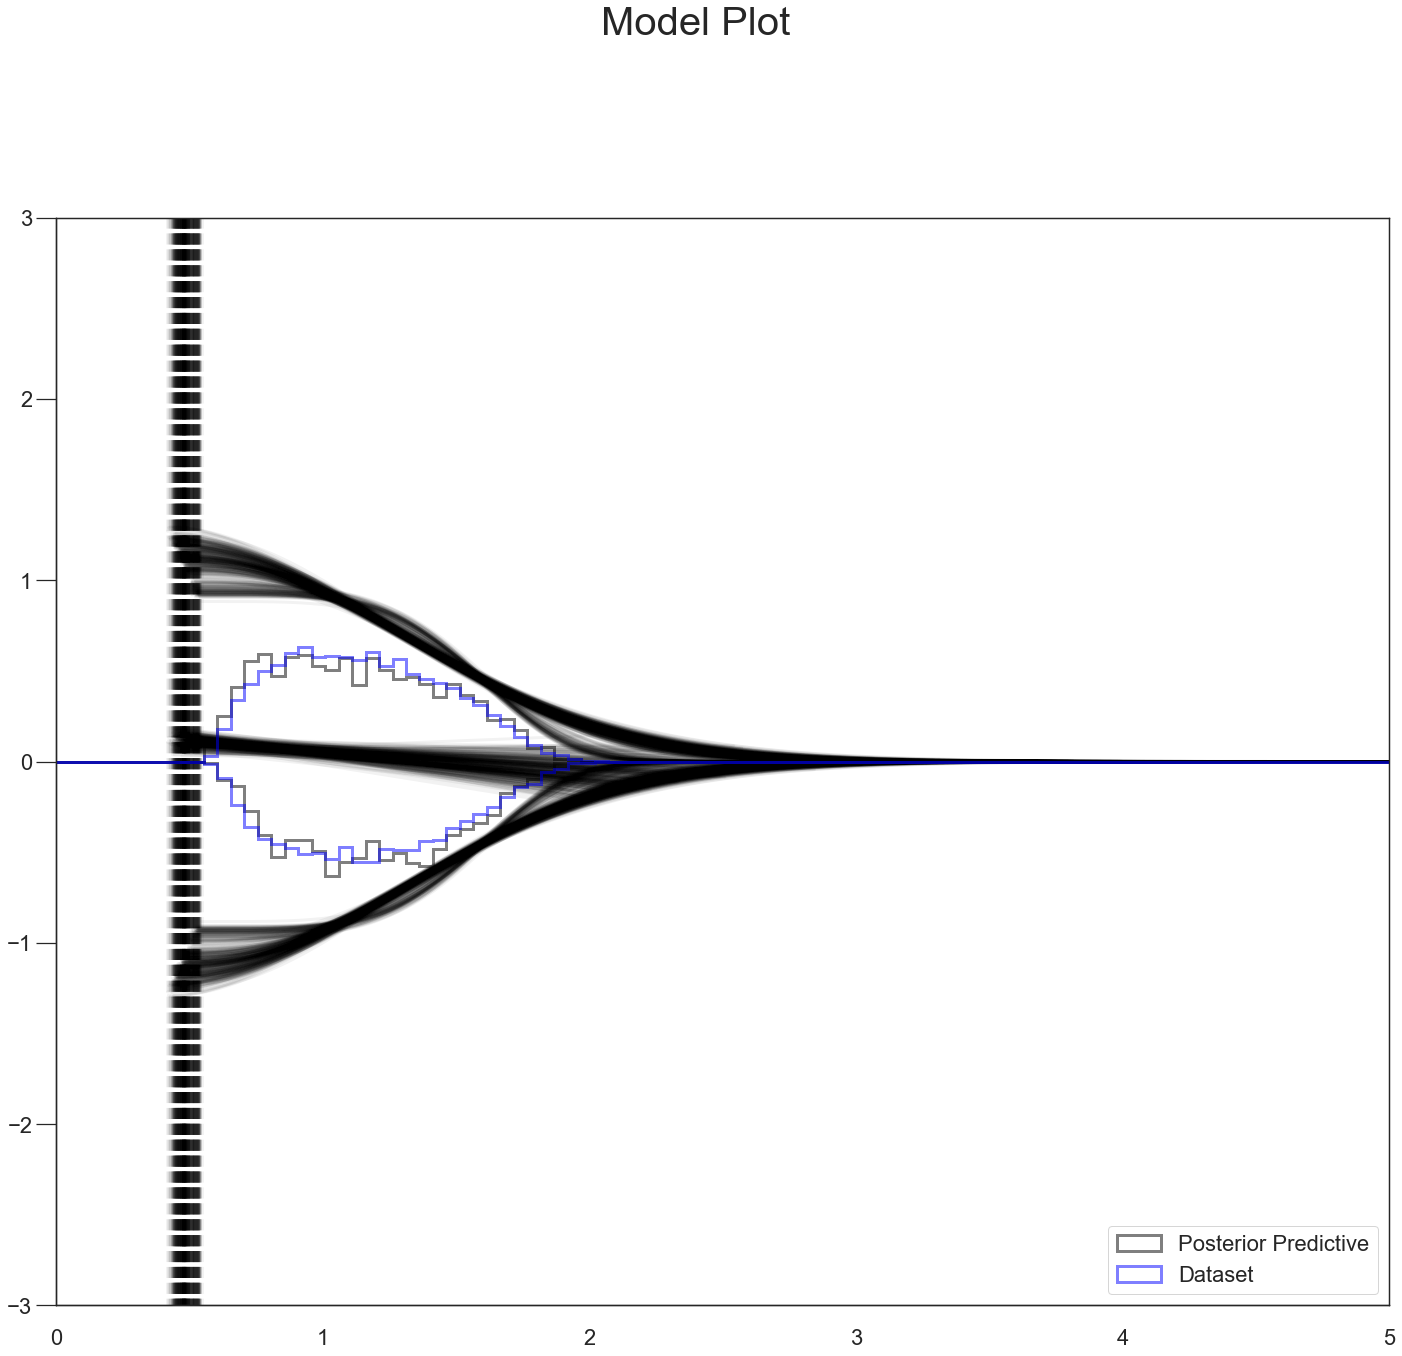

In [64]:
model_plot(ground_truths_parameters = None,
           ground_truths_data = np.concatenate([simulations[0], simulations[1]], axis = 1),
           posterior_samples = hddm_model_weibull_single_subject.get_traces(),
           model_gt = None,
           model_fitted = 'weibull_cdf',
           n_post_params = 400,
           cols = 1,
           n_plots = 1,
           max_t = 5, 
           show_model = True,
           input_hddm_trace = True,
           datatype = 'single_subject',
           ylimit = 3,
           posterior_linewidth = 3,
           gt_linewidth = 1,
           hist_linewidth = 3,)

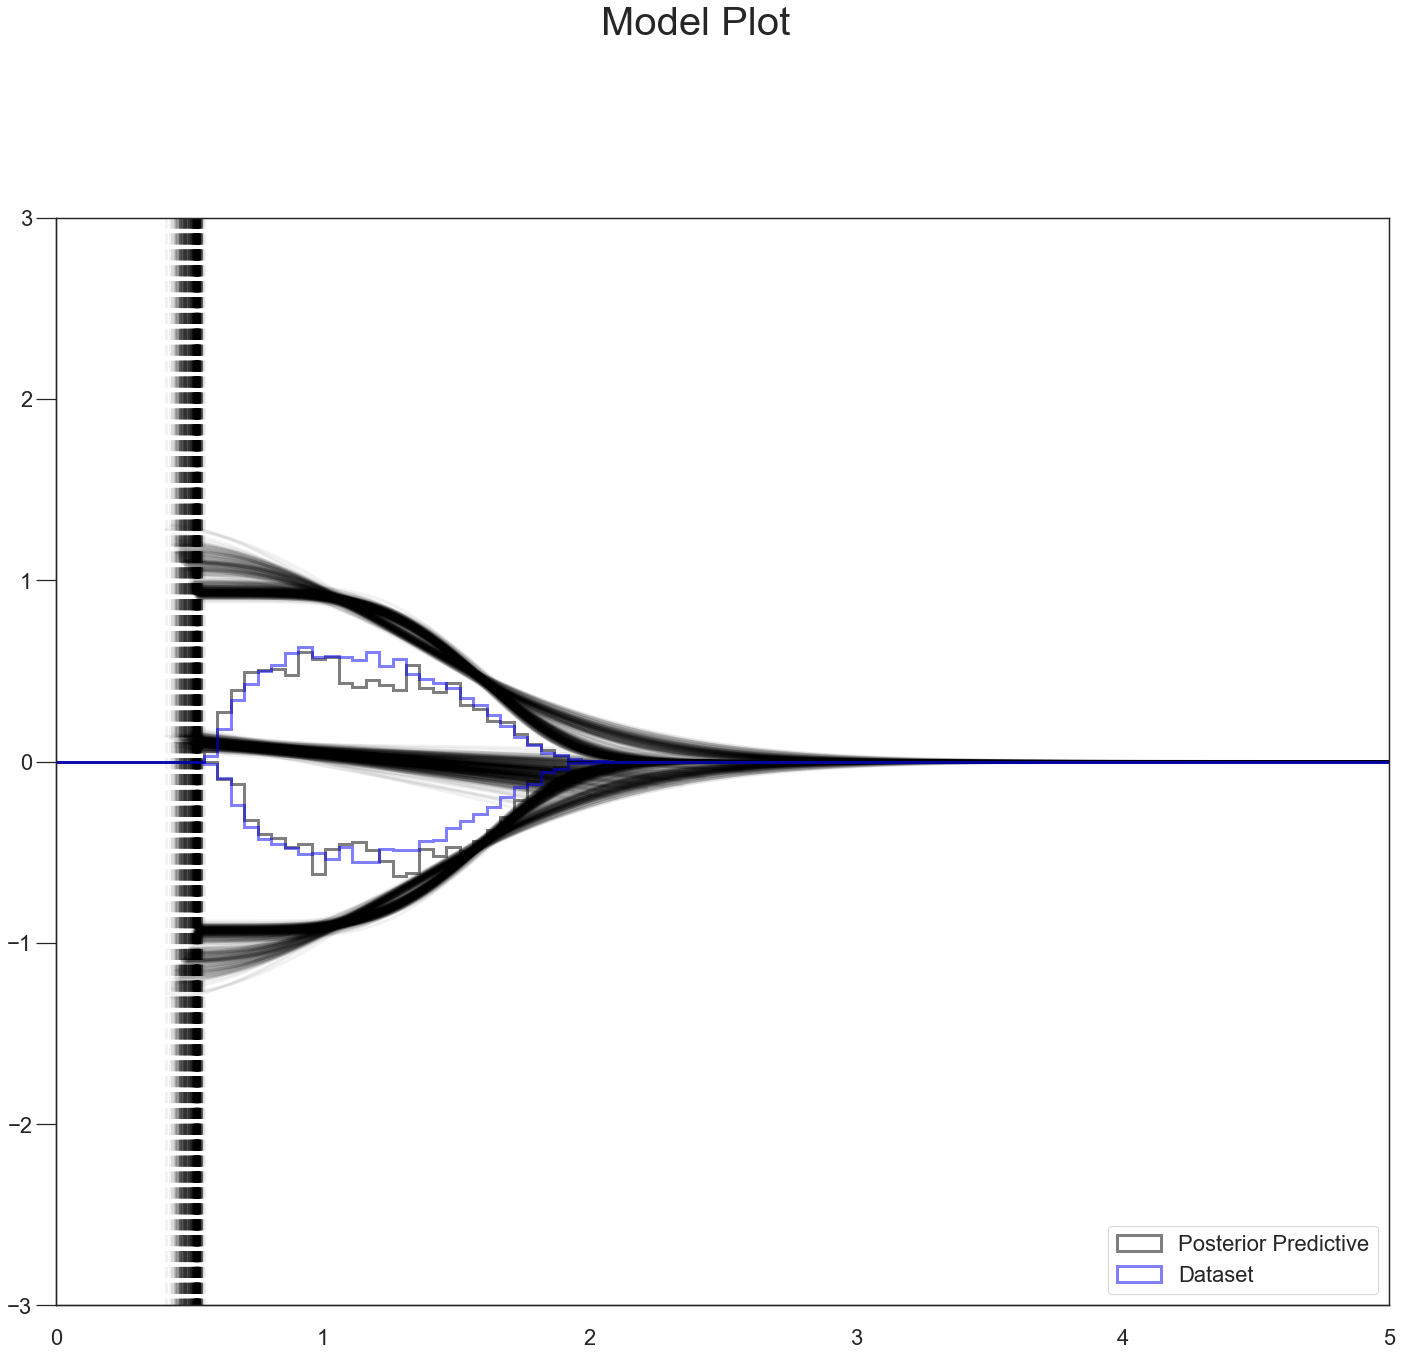

In [65]:
model_plot(ground_truths_parameters = None,
           ground_truths_data = np.concatenate([simulations[0], simulations[1]], axis = 1),
           posterior_samples = hddm_model_weibull_concave_single_subject.get_traces(),
           model_gt = None,
           model_fitted = 'weibull_cdf',
           n_post_params = 400,
           cols = 1,
           n_plots = 1,
           max_t = 5, 
           show_model = True,
           input_hddm_trace = True,
           datatype = 'single_subject',
           ylimit = 3,
           posterior_linewidth = 3,
           gt_linewidth = 1,
           hist_linewidth = 3,)

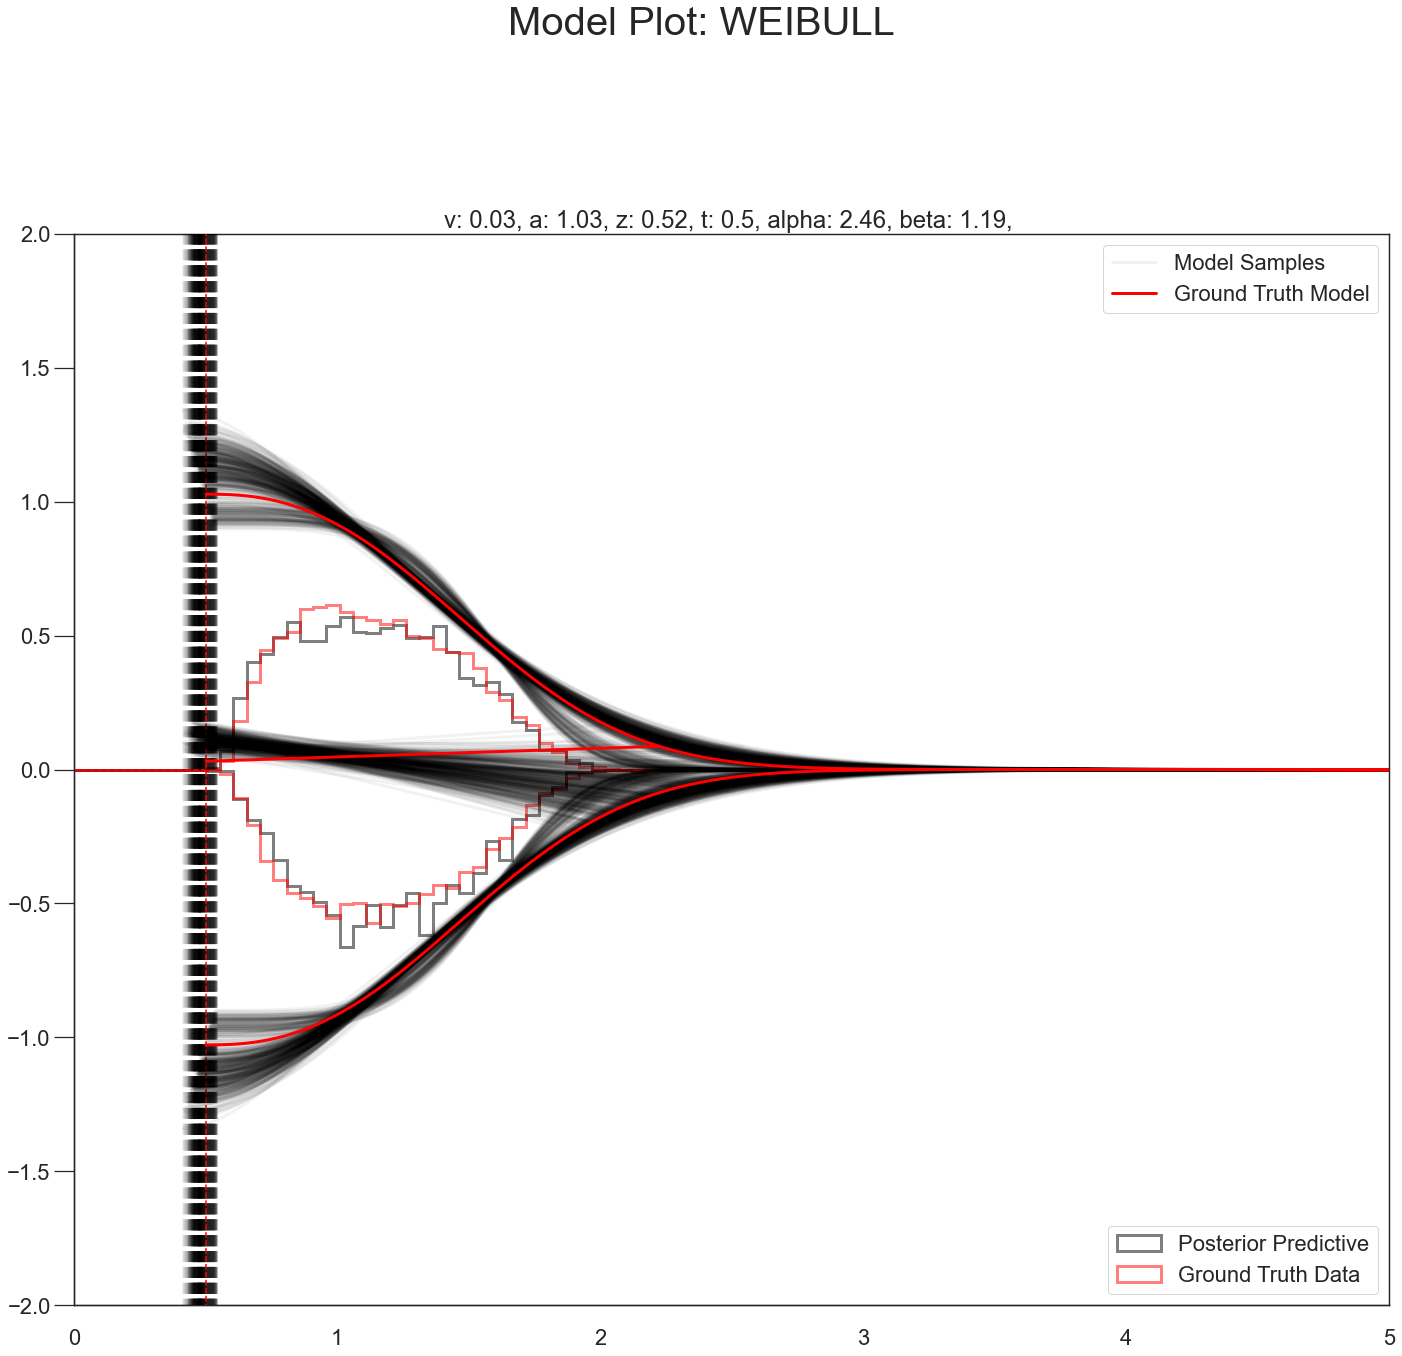

In [66]:
# Posterior Predictive: Do we generate meaningful data from the Posterior Model?
model_plot(ground_truths_parameters = weibull_params.values[0],
           ground_truths_data = None,
           posterior_samples =  hddm_model_weibull_single_subject.get_traces(),
           model_gt = 'weibull_cdf',
           model_fitted = 'weibull_cdf',
           n_post_params = 400,
           cols = 1,
           n_plots = 1,
           max_t = 5, 
           show_model = True,
           input_hddm_trace = True,
           datatype = 'single_subject')

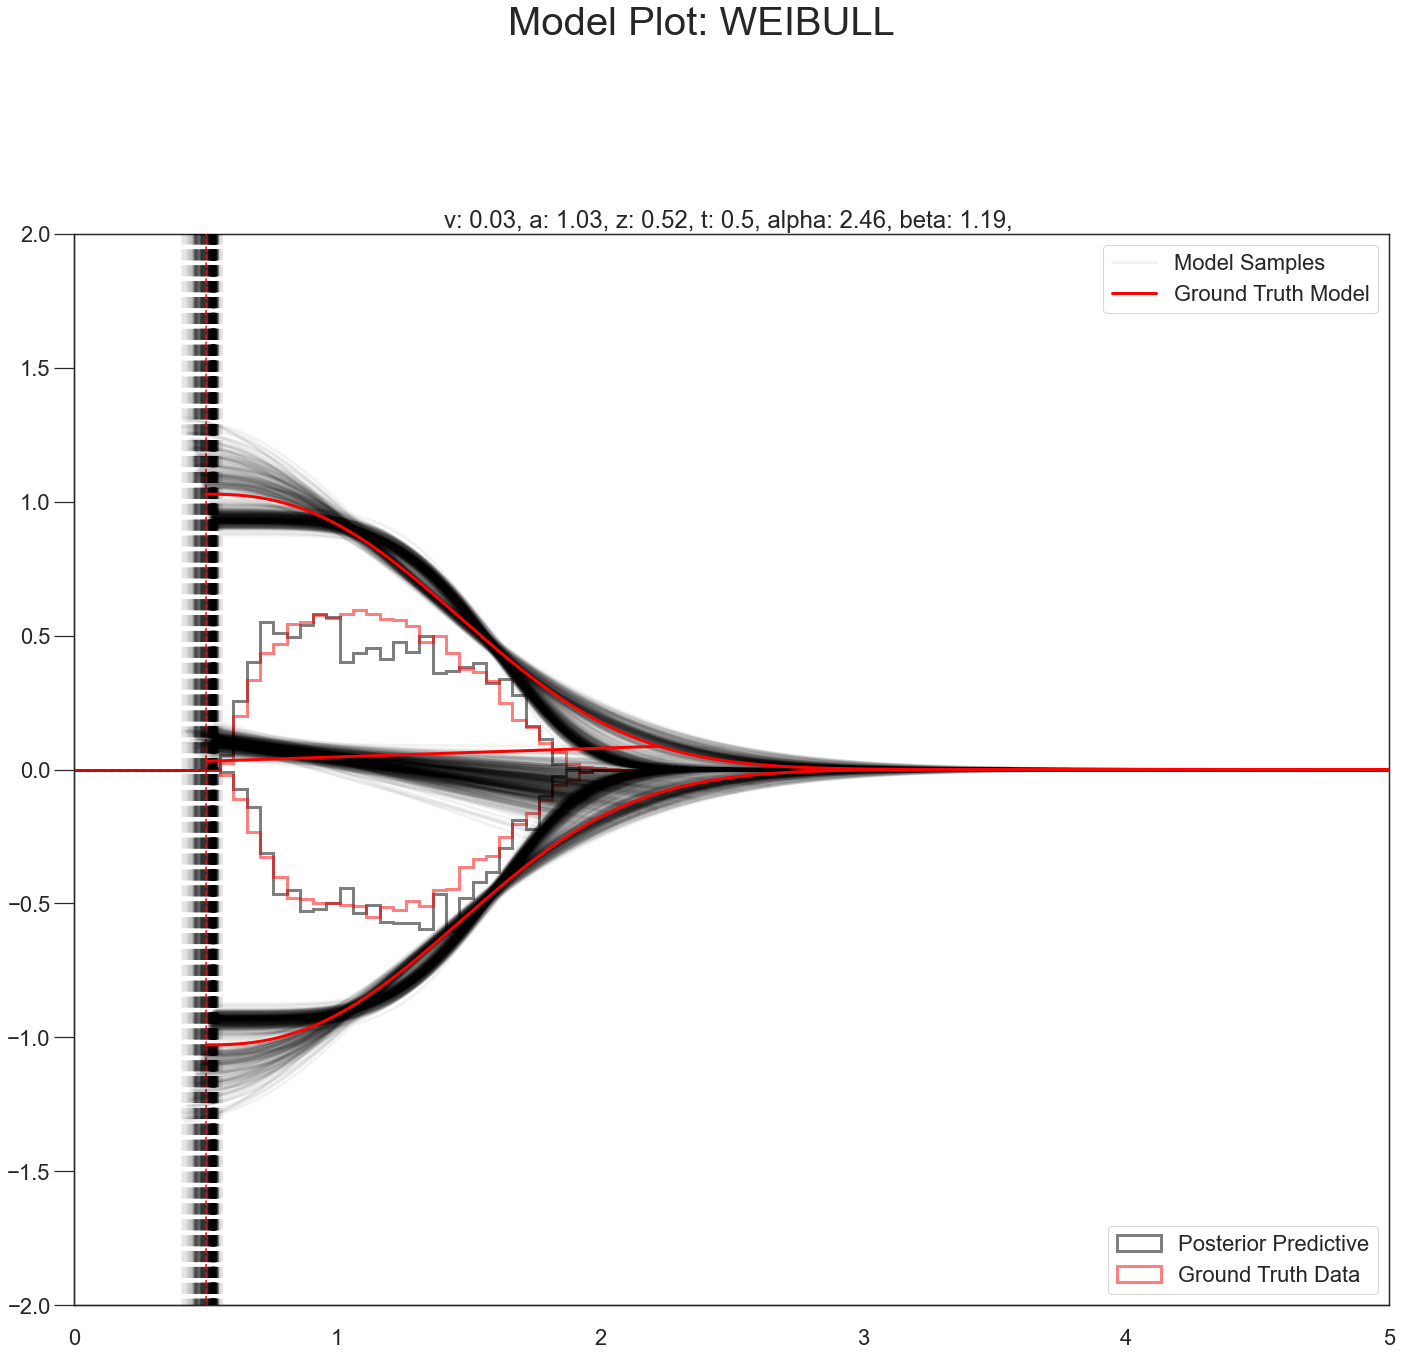

In [67]:
# Posterior Predictive: Do we generate meaningful data from the Posterior Model?
model_plot(ground_truths_parameters = weibull_params.values[0],
           ground_truths_data = None,
           posterior_samples =  hddm_model_weibull_concave_single_subject.get_traces(),
           model_gt = 'weibull_cdf',
           model_fitted = 'weibull_cdf',
           n_post_params = 400,
           cols = 1,
           n_plots = 1,
           max_t = 5, 
           show_model = True,
           input_hddm_trace = True,
           datatype = 'single_subject')

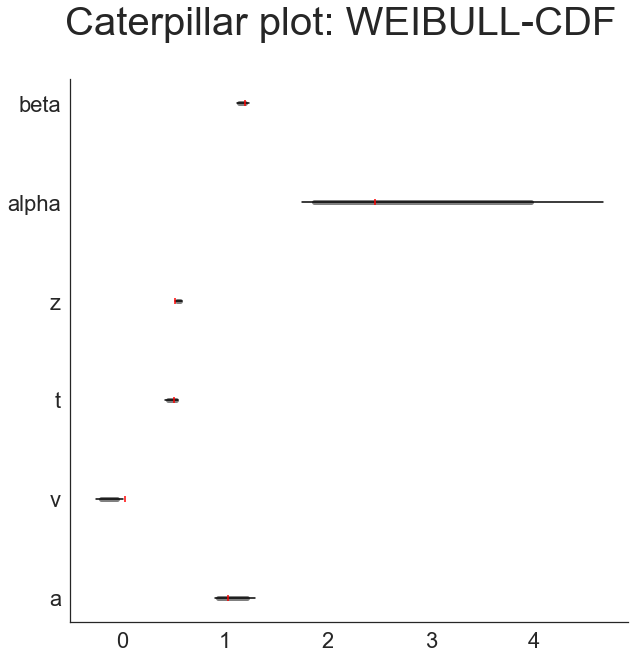

In [68]:
# Caterpillar Plot: (Parameters recovered ok?)
caterpillar_plot(posterior_samples = hddm_model_weibull_single_subject.get_traces(),
                 ground_truths = weibull_params.values[0], #weibull_params.values[0],
                 model = 'weibull_cdf',
                 datatype = 'single_subject',
                 drop_sd = True)

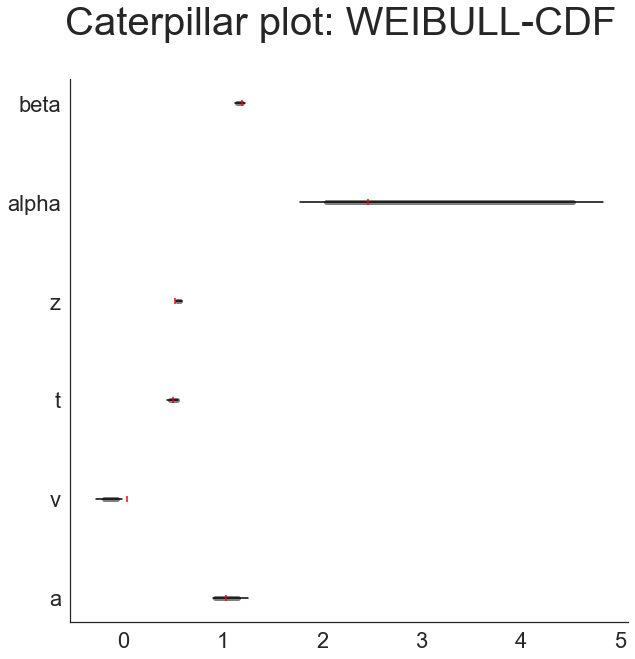

In [69]:
# Caterpillar Plot: (Parameters recovered ok?)
caterpillar_plot(posterior_samples = hddm_model_weibull_concave_single_subject.get_traces(),
                 ground_truths = weibull_params.values[0], #weibull_params.values[0],
                 model = 'weibull_cdf',
                 datatype = 'single_subject',
                 drop_sd = True)

In [70]:
hddm_model_weibull_single_subject.dic

1749.3931882052952

In [71]:
hddm_model_weibull_concave_single_subject.dic

1747.1476529947918

### Ornstein


In [44]:
ornstein_params =  make_parameter_sets(model = 'ornstein',
                                       n_parameter_sets = 1)

simulations = simulator(theta = ornstein_params.values[0],
                        model = 'ornstein', 
                        n_samples = 3000)

hddm_data_ornstein_single_subject = hddm_preprocess(simulations)

In [45]:
ornstein_params

v         a         z         g        t
0 -0.540255  1.230536  0.311096  0.246541  1.52061

In [46]:
# Defining a hddm model
# hddm_model_ornstein_single_subject = hddm.HDDMnn_ornstein(hddm_data_ornstein_single_subject, 
#                                                   #model = 'weibull',
#                                                   informative = False, 
#                                                   free = False, 
#                                                   k = True,
#                                                   include = ['z'],
#                                                   is_group_model = False)


# Defining a hddm model
hddm_model_ornstein_single_subject = hddm.HDDMnn(hddm_data_ornstein_single_subject, 
                                                 model = 'ornstein',
                                                 informative = False, 
                                                 include = ['z', 'g'],
                                                 is_group_model = False)

knodes
OrderedDict([('a_bottom', a), ('v_bottom', v), ('t_bottom', t), ('z_trans', z_trans), ('z_bottom', z), ('g_bottom', g)])
wfpt parents: 
OrderedDict([('a', a), ('v', v), ('t', t), ('sv', 0), ('sz', 0), ('st', 0), ('z', z), ('p_outlier', 0), ('g', g)])


In [47]:
nmcmc = 1000
hddm_model_ornstein_single_subject.sample(nmcmc,
                                          burn = 100)

 [-----------------100%-----------------] 1000 of 1000 complete in 75.0 sec

In [48]:
hddm_model_ornstein_single_subject.gen_stats()

mean        std       2.5q        25q       50q       75q     97.5q  \
a   1.25216  0.0404627     1.1665    1.22601   1.25458   1.28076    1.3273   
v -0.500362  0.0234483  -0.547073  -0.516132 -0.499244 -0.484368  -0.45573   
t   1.55508  0.0133093    1.52835    1.54616   1.55483   1.56427   1.58117   
z  0.282753  0.0114776   0.260879   0.275491  0.282786  0.290483  0.305835   
g  0.182722   0.127802 -0.0439675  0.0924598  0.169323  0.258426   0.45902   

       mc err  
a  0.00369989  
v  0.00124892  
t   0.0011795  
z  0.00096653  
g   0.0118571

/Users/afengler/opt/miniconda3/envs/hddm_dev/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/afengler/opt/miniconda3/envs/hddm_dev/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


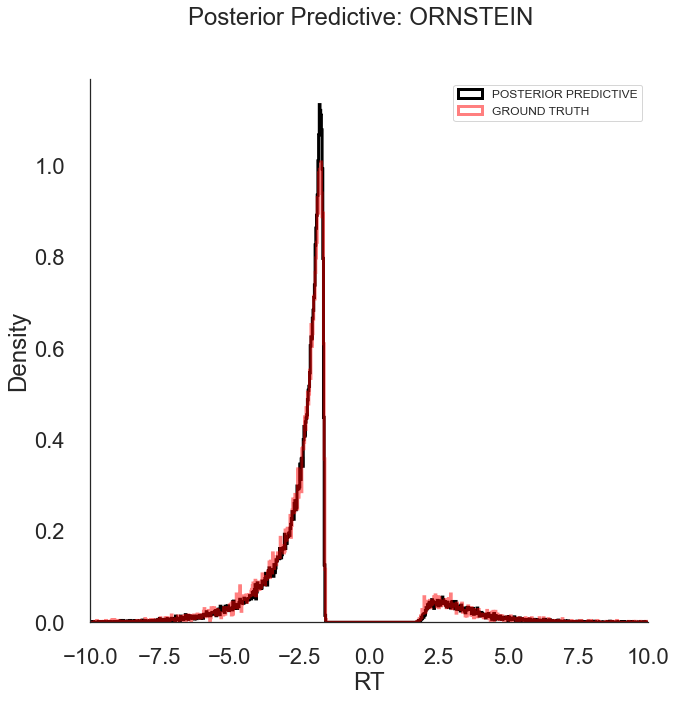

In [49]:
simulations = simulator(theta = ornstein_params.values[0],
                        model = 'ornstein',
                        n_samples = 20000)

posterior_predictive_plot(posterior_samples = hddm_model_ornstein_single_subject.get_traces(), #hddm_model_weibull_single_subject.get_traces(),
                          ground_truths_parameters = ornstein_params.values[0], #weibull_params.values[0],
                          ground_truths_data = np.concatenate([simulations[0], simulations[1]], axis = 1), # None
                          n_plots = 1,
                          cols = 1,
                          model_fitted = 'ornstein',
                          model_gt = 'ornstein', #'weibull_cdf',
                          datatype = 'single_subject',
                          n_post_params = 500,
                          samples_by_param = 100,
                          xlimit = 10,
                          bin_size = 0.025, 
                          hist_linewidth = 3)

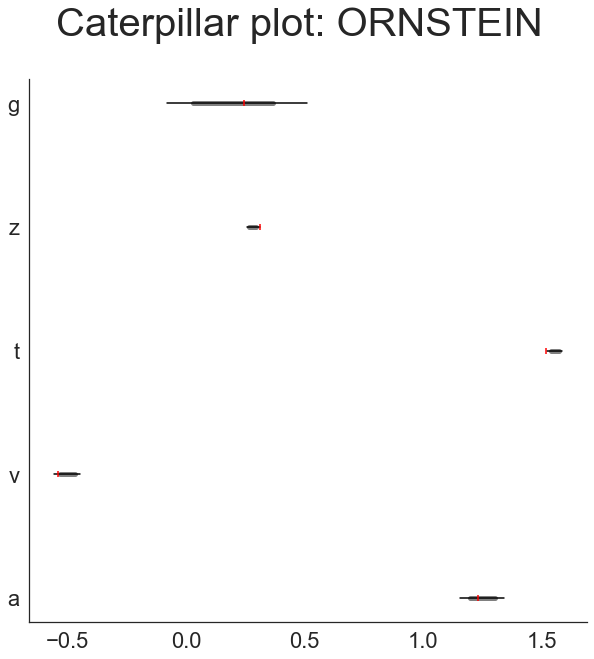

In [50]:
# Caterpillar Plot: (Parameters recovered ok?)
caterpillar_plot(posterior_samples = hddm_model_ornstein_single_subject.get_traces(),
                 ground_truths = ornstein_params.values[0], #weibull_params.values[0],
                 model = 'ornstein',
                 datatype = 'single_subject',
                 drop_sd = True)

In [ ]:
# model_plot(ground_truths_parameters = None,
#            ground_truths_data = np.concatenate([simulations[0], simulations[1]], axis = 1),
#            posterior_samples = hddm_model_ornstein_single_subject.get_traces(),
#            model_gt = None,
#            model_fitted = 'ornstein',
#            n_post_params = 200,
#            cols = 1,
#            n_plots = 1,
#            max_t = 5, 
#            show_model = True,
#            input_hddm_trace = True,
#            datatype = 'single_subject',
#            ylimit = 3,
#            posterior_linewidth = 3,
#            gt_linewidth = 1,
#            hist_linewidth = 3,)

In [ ]:
# # Posterior Predictive: Do we generate meaningful data from the Posterior Model?
# model_plot(ground_truths_parameters = ornstein_params.values[0],
#            ground_truths_data = None,
#            posterior_samples =  hddm_model_ornstein_single_subject.get_traces(),
#            model_gt = None, #'weibull_cdf',
#            model_fitted = 'ornstein',
#            n_post_params = 200,
#            cols = 1,
#            n_plots = 1,
#            max_t = 5, 
#            show_model = True,
#            input_hddm_trace = True,
#            datatype = 'single_subject')

# Section 2: Estimation for Single Subjects (collapsed data)

### WEIBULL MODEL

Now, we try to fit these models to data! Let's start with an simple dataset. In other words, we have one single participant who gave us 1000 datapoints (reaction times and choices) from some *two alternative forced choice* task paradigm.

In [42]:
# MAKE DATA AND PREPARE FOR HDDM
weibull_params = make_parameter_sets(model = 'weibull_cdf',
                                     n_parameter_sets = 1)

simulations = simulator(theta = weibull_params.values[0],
                        model = 'weibull_cdf',
                        n_samples = 1000)

hddm_data_weibull_single_subject = hddm_preprocess(simulations)

In [43]:
# A Look at the ground truth params
weibull_params

v         a         z         t     alpha      beta
0 -1.674229  0.962153  0.421615  1.740836  3.535754  4.836863

In [44]:
# A look at the dataset
hddm_data_weibull_single_subject.head()

rt  response  nn_response subj_idx
0  3.052841         0           -1     none
1  3.764871         0           -1     none
2  2.681827         0           -1     none
3  2.207833         0           -1     none
4  2.392831         0           -1     none

In [45]:
hddm_data_weibull_single_subject

rt  response  nn_response subj_idx
0    3.052841         0           -1     none
1    3.764871         0           -1     none
2    2.681827         0           -1     none
3    2.207833         0           -1     none
4    2.392831         0           -1     none
..        ...       ...          ...      ...
995  2.098835         0           -1     none
996  1.952836         0           -1     none
997  1.894836         0           -1     none
998  2.165834         0           -1     none
999  2.139834         0           -1     none

[1000 rows x 4 columns]

In [46]:
# Defining a hddm model
hddm_model_weibull_single_subject = hddm.HDDMnn(hddm_data_weibull_single_subject, 
                                                    model = 'weibull',
                                                    informative = False,
                                                    include = ['z', 'beta', 'alpha'],
                                                    is_group_model = False)

knodes
OrderedDict([('a_bottom', a), ('v_bottom', v), ('t_bottom', t), ('z_trans', z_trans), ('z_bottom', z), ('alpha_bottom', alpha), ('beta_bottom', beta)])
wfpt parents: 
OrderedDict([('a', a), ('v', v), ('t', t), ('sv', 0), ('sz', 0), ('st', 0), ('z', z), ('p_outlier', 0), ('alpha', alpha), ('beta', beta)])


In [48]:
nmcmc = 500
hddm_model_weibull_single_subject.sample(nmcmc, 
                                      burn = 100)

 [-----------------100%-----------------] 500 of 500 complete in 65.1 sec

In [51]:
# MAKE DATA AND PREPARE FOR HDDM
angle_params = make_parameter_sets(model = 'angle',
                                     n_parameter_sets = 1)

simulations = simulator(theta = angle_params.values[0],
                        model = 'angle',
                        n_samples = 1000)

hddm_data_angle_single_subject = hddm_preprocess(simulations)

In [53]:
# Defining a hddm model
hddm_model_angle_single_subject = hddm.HDDMnn(hddm_data_angle_single_subject, 
                                                  model = 'angle',
                                                  informative = False,
                                                  include = ['z', 'theta'],
                                                  is_group_model = False)

knodes
OrderedDict([('a_bottom', a), ('v_bottom', v), ('t_bottom', t), ('z_trans', z_trans), ('z_bottom', z), ('theta_bottom', theta)])
wfpt parents: 
OrderedDict([('a', a), ('v', v), ('t', t), ('sv', 0), ('sz', 0), ('st', 0), ('z', z), ('p_outlier', 0), ('theta', theta)])


In [55]:
nmcmc = 500
hddm_model_angle_single_subject.sample(nmcmc, 
                                      burn = 100)

 [-----------------100%-----------------] 501 of 500 complete in 71.2 sec

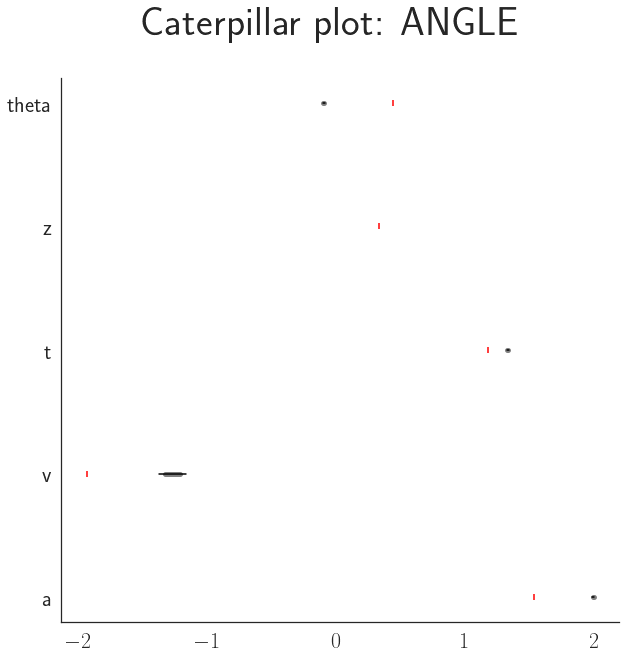

In [56]:
# Caterpillar Plot: (Parameters recovered ok?)
caterpillar_plot(posterior_samples = hddm_model_angle_single_subject.get_traces(),
                 ground_truths = angle_params.values[0], #weibull_params.values[0],
                 model = 'angle',
                 datatype = 'single_subject',
                 drop_sd = True)

/Users/afengler/opt/miniconda3/envs/hddm_dev/lib/python3.7/site-packages/numpy/lib/histograms.py:905: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


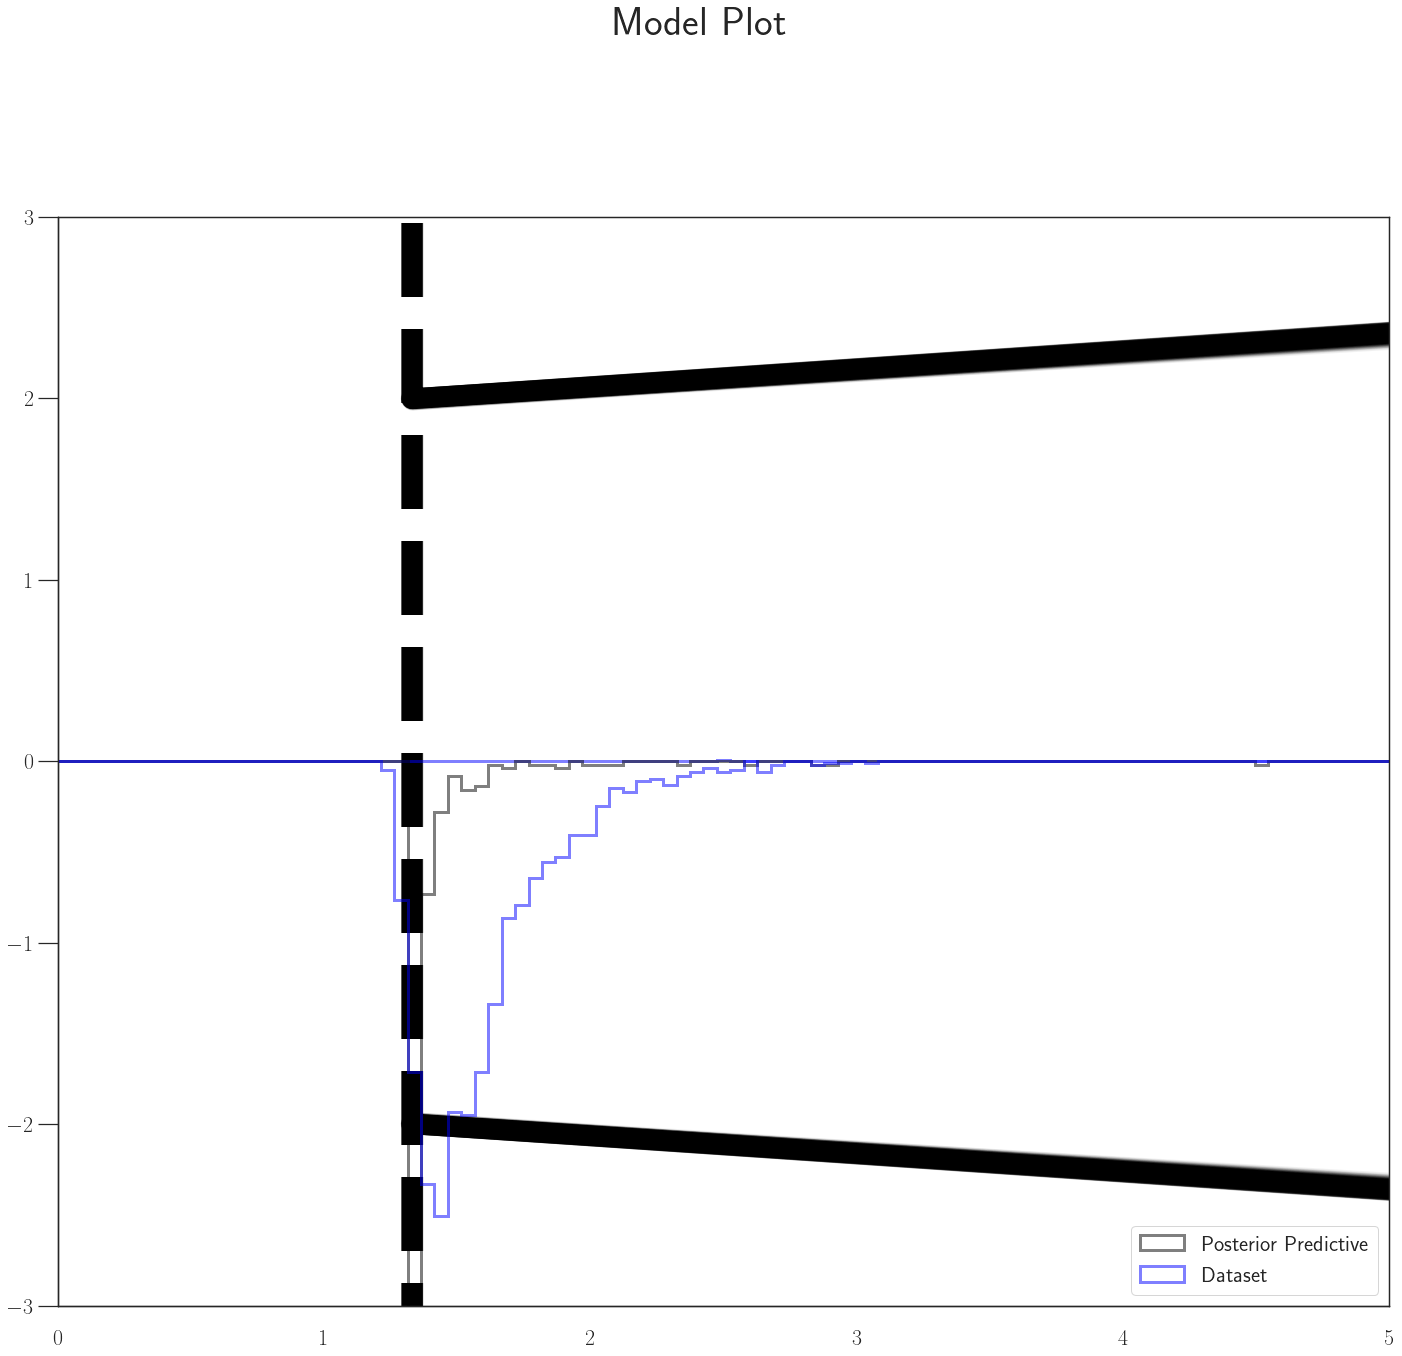

In [58]:
# Posterior Predictive: Do we generate meaningful data from the Posterior Model?
simulations = simulator(theta = angle_params.values[0],
                        model = 'angle', 
                        n_samples = 2000)

model_plot(ground_truths_parameters = None,
           ground_truths_data = np.concatenate([simulations[0], simulations[1]], axis = 1),
           posterior_samples = hddm_model_angle_single_subject.get_traces(),
           model_gt = None,
           model_fitted = 'angle',
           n_post_params = 100,
           cols = 1,
           n_plots = 1,
           max_t = 5, 
           show_model = True,
           input_hddm_trace = True,
           datatype = 'single_subject',
           ylimit = 3,
           posterior_linewidth = 20,
           gt_linewidth = 1,
           hist_linewidth = 3,)

In [10]:
# Defining a hddm model
hddm_model_ddm_single_subject = hddm.HDDMnn_new(hddm_data_weibull_single_subject, 
                                                model = 'ddm',
                                                informative = False,
                                                include = ['z'],
                                                is_group_model = False)

knodes
OrderedDict([('a_bottom', a), ('v_bottom', v), ('t_bottom', t), ('z_trans', z_trans), ('z_bottom', z)])
wfpt parents: 
OrderedDict([('a', a), ('v', v), ('t', t), ('sv', 0), ('sz', 0), ('st', 0), ('z', z), ('p_outlier', 0)])


In [11]:
nmcmc = 1000
hddm_model_ddm_single_subject.sample(nmcmc, 
                                      burn = 100)

 [-----------------100%-----------------] 1000 of 1000 complete in 34.9 sec

In [13]:
# Defining a hddm model
hddm_model_levy_single_subject = hddm.HDDMnn_new(hddm_data_weibull_single_subject, 
                                                model = 'levy',
                                                informative = False,
                                                include = ['z', 'alpha'],
                                                is_group_model = False)

knodes
OrderedDict([('a_bottom', a), ('v_bottom', v), ('t_bottom', t), ('z_trans', z_trans), ('z_bottom', z), ('alpha_bottom', alpha)])
wfpt parents: 
OrderedDict([('a', a), ('v', v), ('t', t), ('sv', 0), ('sz', 0), ('st', 0), ('z', z), ('p_outlier', 0), ('alpha', alpha)])


In [14]:
nmcmc = 1000
hddm_model_levy_single_subject.sample(nmcmc, 
                                      burn = 100)

 [-----------------100%-----------------] 1000 of 1000 complete in 41.2 sec

In [15]:
# Defining a hddm model
hddm_model_ornstein_single_subject = hddm.HDDMnn_new(hddm_data_weibull_single_subject, 
                                                     model = 'ornstein',
                                                     informative = False,
                                                     include = ['z', 'g'],
                                                     is_group_model = False)

knodes
OrderedDict([('a_bottom', a), ('v_bottom', v), ('t_bottom', t), ('z_trans', z_trans), ('z_bottom', z), ('g_bottom', g)])
wfpt parents: 
OrderedDict([('a', a), ('v', v), ('t', t), ('sv', 0), ('sz', 0), ('st', 0), ('z', z), ('p_outlier', 0), ('g', g)])


In [16]:
nmcmc = 1000
hddm_model_ornstein_single_subject.sample(nmcmc, 
                                          burn = 100)

 [-----------------100%-----------------] 1000 of 1000 complete in 62.3 sec

In [24]:
print('Weibull: ', hddm_model_weibull_single_subject.dic)
print('Angle: ', hddm_model_angle_single_subject.dic)
print('DDM: ', hddm_model_ddm_single_subject.dic)
print('Levy: ', hddm_model_levy_single_subject.dic)
print('Ornstein: ', hddm_model_ornstein_single_subject.dic)

Weibull:  1650.0247271050348
Angle:  1666.8027593315974
DDM:  1661.1956732855901
Levy:  -2062.0803738064233
Ornstein:  1663.9930677625866


In [ ]:
hddm_model_weibull_single_subject.dic

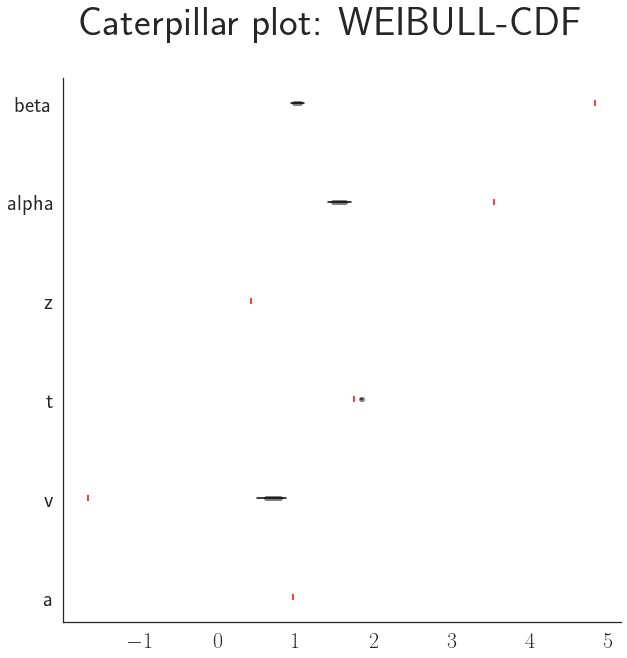

In [49]:
# Caterpillar Plot: (Parameters recovered ok?)
caterpillar_plot(posterior_samples = hddm_model_weibull_single_subject.get_traces(),
                 ground_truths = weibull_params.values[0],
                 model = 'weibull_cdf',
                 datatype = 'single_subject',
                 drop_sd = True)

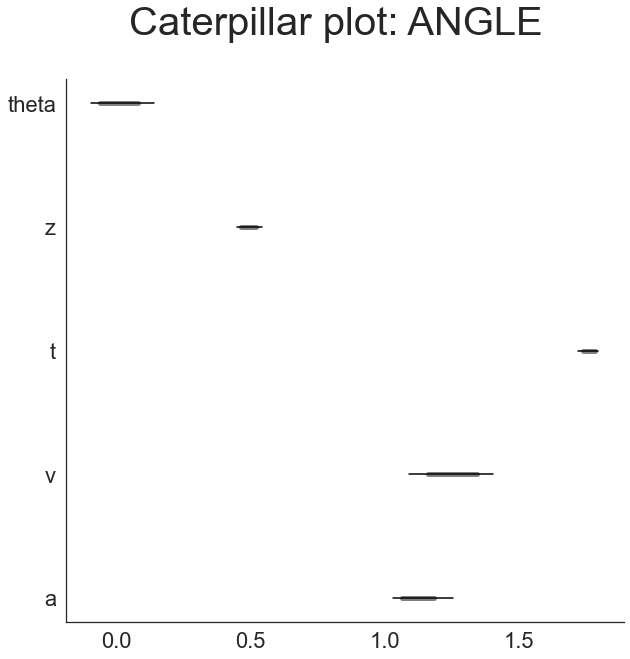

In [18]:
# Caterpillar Plot: (Parameters recovered ok?)
caterpillar_plot(posterior_samples = hddm_model_angle_single_subject.get_traces(),
                 ground_truths = None, #weibull_params.values[0],
                 model = 'angle',
                 datatype = 'single_subject',
                 drop_sd = True)

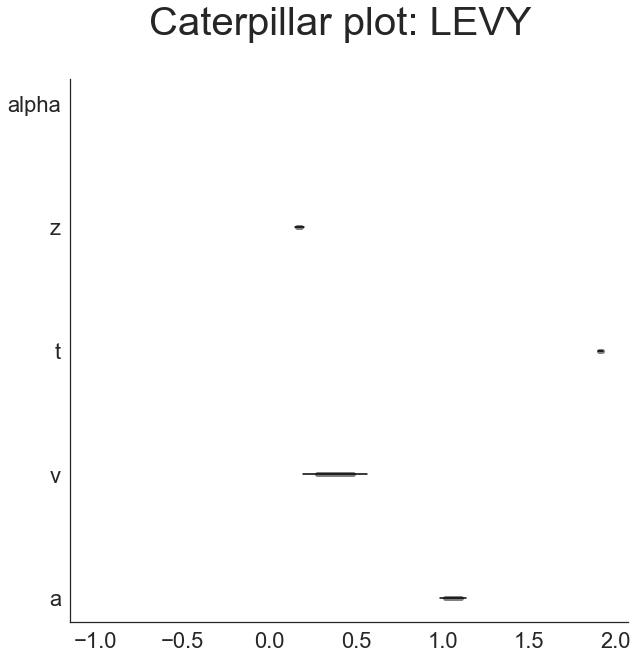

In [19]:
# Caterpillar Plot: (Parameters recovered ok?)
caterpillar_plot(posterior_samples = hddm_model_levy_single_subject.get_traces(),
                 ground_truths = None, #weibull_params.values[0],
                 model = 'levy',
                 datatype = 'single_subject',
                 drop_sd = True)

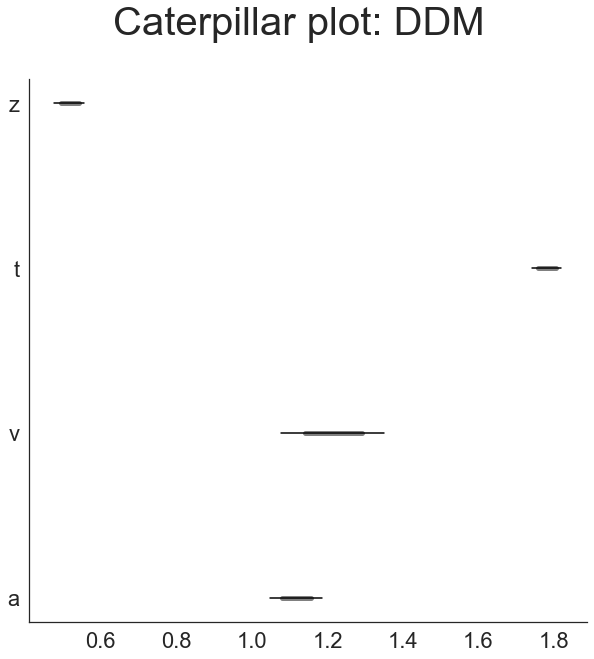

In [21]:
# Caterpillar Plot: (Parameters recovered ok?)
caterpillar_plot(posterior_samples = hddm_model_ddm_single_subject.get_traces(),
                 ground_truths = None, #weibull_params.values[0],
                 model = 'ddm',
                 datatype = 'single_subject',
                 drop_sd = True)

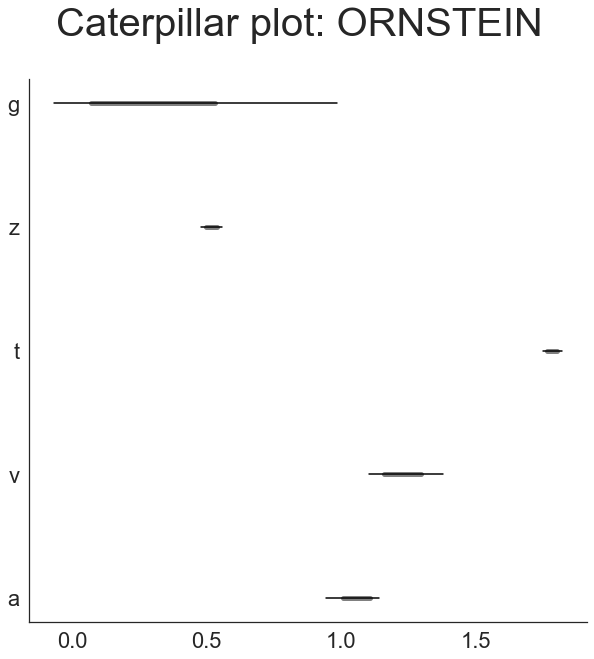

In [22]:
# Caterpillar Plot: (Parameters recovered ok?)
caterpillar_plot(posterior_samples = hddm_model_ornstein_single_subject.get_traces(),
                 ground_truths = None, #weibull_params.values[0],
                 model = 'ornstein',
                 datatype = 'single_subject',
                 drop_sd = True)

### hddm.HDDMnn_weibull(data, informative = False, free = False, k = True, include = ['z'], is_group_model = False)

Parameters:

- **data**: a ``pandas`` object - the dataset
- **informative**: bool, **True** if you want the model to talk to you while it's running
- **free**: bool, **False** if we are using parameters that have been trained on the network.
- **k**: bool, **True** to include $alpha$ in the fit
- **include**: a dictionary, whether or not to also fit $z$
- **is_group_model**: bool, **False** if fitting collapsed data, **True** if fitting hierarchical participant data.

In [2]:
# MAKE DATA AND PREPARE FOR HDDM
weibull_params = make_parameter_sets(model = 'weibull_cdf',
                                     n_parameter_sets = 1)

simulations = simulator(theta = weibull_params.values[0],
                        model = 'weibull_cdf',
                        n_samples = 1000)

hddm_data_weibull_single_subject = hddm_preprocess(simulations)

In [3]:
# Defining a hddm model
hddm_model_weibull_single_subject = hddm.HDDMnn_weibull(hddm_data_weibull_single_subject, 
                                                informative = False, 
                                                free = False, 
                                                k = True,
                                                include = ['z', 'beta'],
                                                is_group_model = False)

weibull
{'beta', 't', 'v', 'z', 'a'}


In [ ]:
nmcmc = 1000
hddm_model_weibull_single_subject.sample(nmcmc, 
                                         burn = 100)

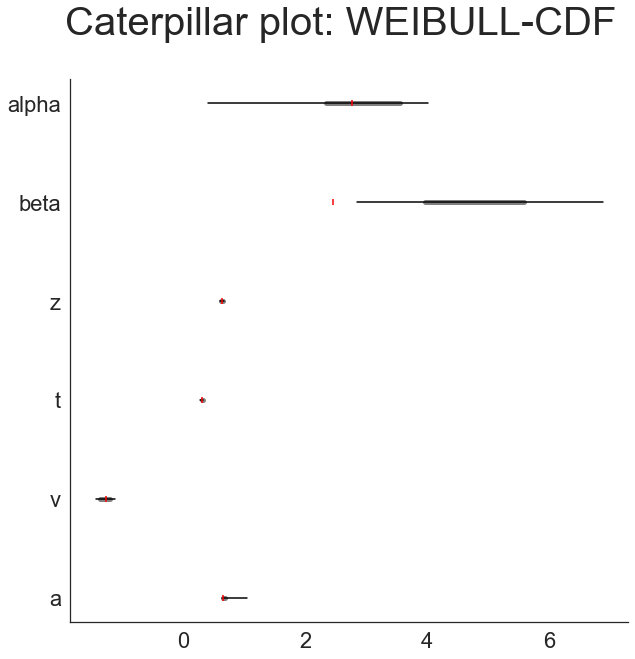

In [5]:
# Caterpillar Plot: (Parameters recovered ok?)
caterpillar_plot(posterior_samples = hddm_model_weibull_single_subject.get_traces(),
                 ground_truths = weibull_params.values[0],
                 model = 'weibull_cdf',
                 datatype = 'single_subject',
                 drop_sd = True)

In [2]:
# Defining a hddm model
hddm_model_weibull_single_subject = hddm.HDDMnn_new(hddm_data_weibull_single_subject, 
                                                    model = 'weibull',
                                                    informative = False, 
                                                    free = False, 
                                                    k = True,
                                                    include = ['z'],
                                                    is_group_model = False)

NameError: name 'hddm_data_weibull_single_subject' is not defined

In [6]:
# Defining a hddm model
hddm_model_weibull_single_subject = hddm.HDDMnn(hddm_data_weibull_single_subject, 
                                                informative = False, 
                                                #free = False, #k = True,
                                                include = ['z'],
                                                is_group_model = False)

In [4]:
nmcmc = 1000
hddm_model_weibull_single_subject.sample(nmcmc, 
                                         burn = 100)

 [-----------------100%-----------------] 1000 of 1000 complete in 80.5 sec

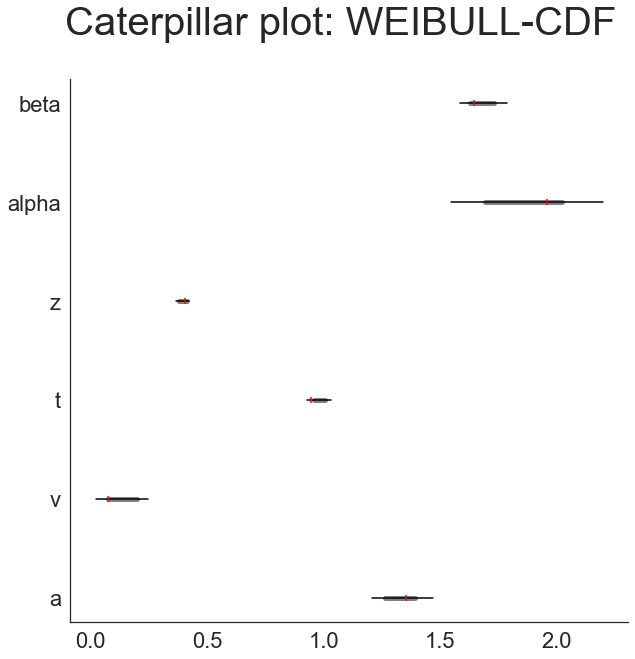

In [7]:
# Caterpillar Plot: (Parameters recovered ok?)
caterpillar_plot(posterior_samples = hddm_model_weibull_single_subject.get_traces(),
                 ground_truths = weibull_params.values[0],
                 model = 'weibull_cdf',
                 datatype = 'single_subject',
                 drop_sd = True)

In [12]:
nmcmc = 5000
hddm_model_weibull_single_subject.sample(nmcmc, 
                                         burn = 1000)

 [-----------------100%-----------------] 5000 of 5000 complete in 203.8 sec

In [ ]:
nmcmc = 500
hddm_model_weibull_single_subject.sample(nmcmc, 
                                         burn = 100)

Now that we have run a fit, we look to find ways to visualised the recovered parameters to make sure the model is performing accurately. A caterpillar plot is a good way to visualise both the precision and accuracy of the task. Here, the red dot represents the ground truth value. The black bars are where the trace lies, with the *thick line* indicating the $10th$ and $90th$ percentile, the *thin line* indicating the $1st$ and $99th$ percentiles of the traces. (You have seen this in one of your previous **hddm tutorials** (?))

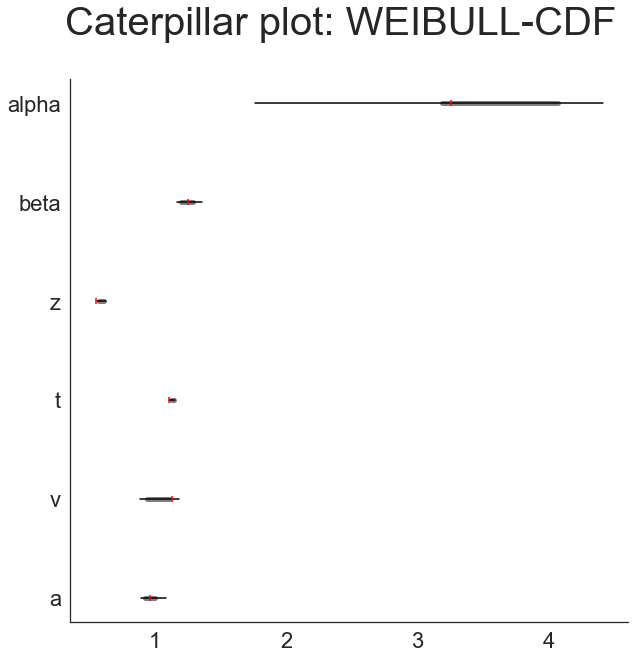

In [10]:
# Caterpillar Plot: (Parameters recovered ok?)
caterpillar_plot(posterior_samples = hddm_model_weibull_single_subject.get_traces(),
                 ground_truths = weibull_params.values[0],
                 model = 'weibull_cdf',
                 datatype = 'single_subject',
                 drop_sd = True)

### Posterior Predictive
Another way to examine whether or not our recovery was satisfactory is to perform posterior predictive checks. Essentially, we are looking to simulate datasets from the trace and check whether it aligns with the ground truth participant data. This answers the question of whether or not these parameters that you recovered can actually reproduce the data. Note that the parameter ``n_post_params`` controls the number of samples drawn from the trace. Here we draw randomly 200 (out of 1200).

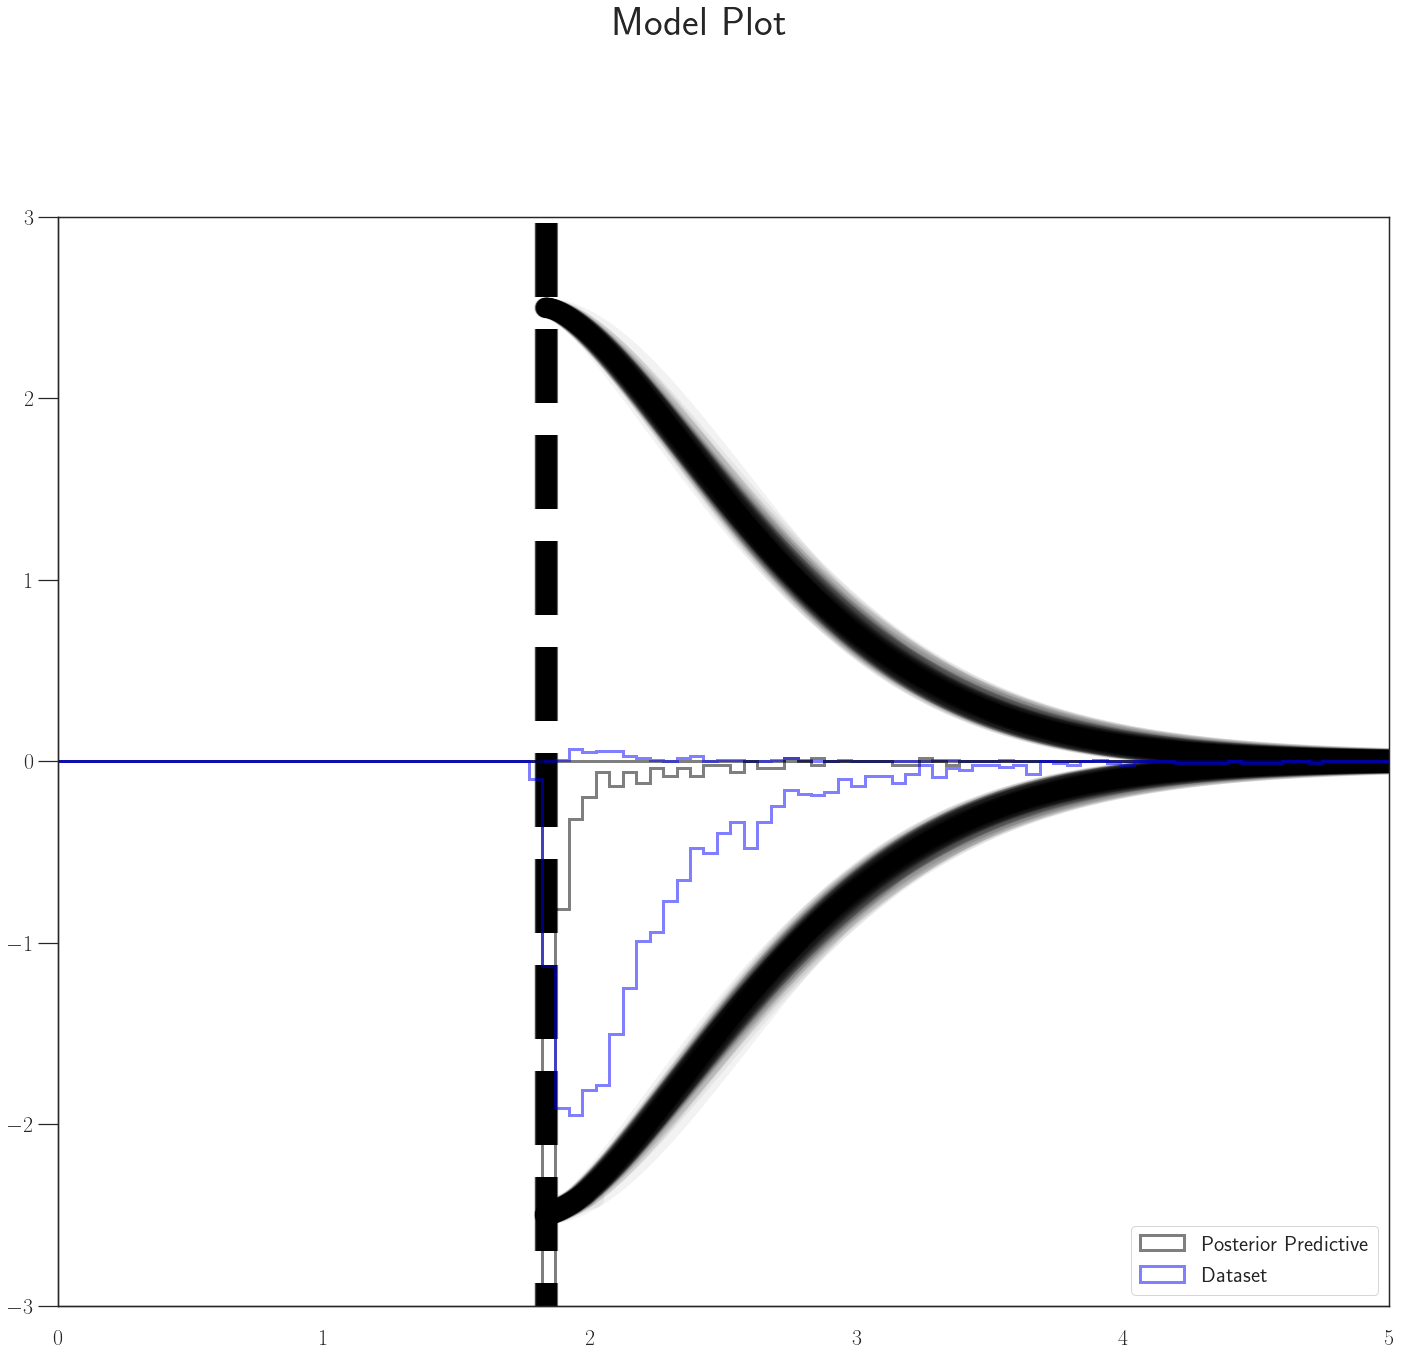

In [50]:
# Posterior Predictive: Do we generate meaningful data from the Posterior Model?
simulations = simulator(theta = weibull_params.values[0],
                        model = 'weibull_cdf', 
                        n_samples = 2000)

model_plot(ground_truths_parameters = None,
           ground_truths_data = np.concatenate([simulations[0], simulations[1]], axis = 1),
           posterior_samples = hddm_model_weibull_single_subject.get_traces(),
           model_gt = None,
           model_fitted = 'weibull_cdf',
           n_post_params = 100,
           cols = 1,
           n_plots = 1,
           max_t = 5, 
           show_model = True,
           input_hddm_trace = True,
           datatype = 'single_subject',
           ylimit = 3,
           posterior_linewidth = 20,
           gt_linewidth = 1,
           hist_linewidth = 3,)

/Users/afengler/opt/miniconda3/envs/hddm_dev/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/afengler/opt/miniconda3/envs/hddm_dev/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


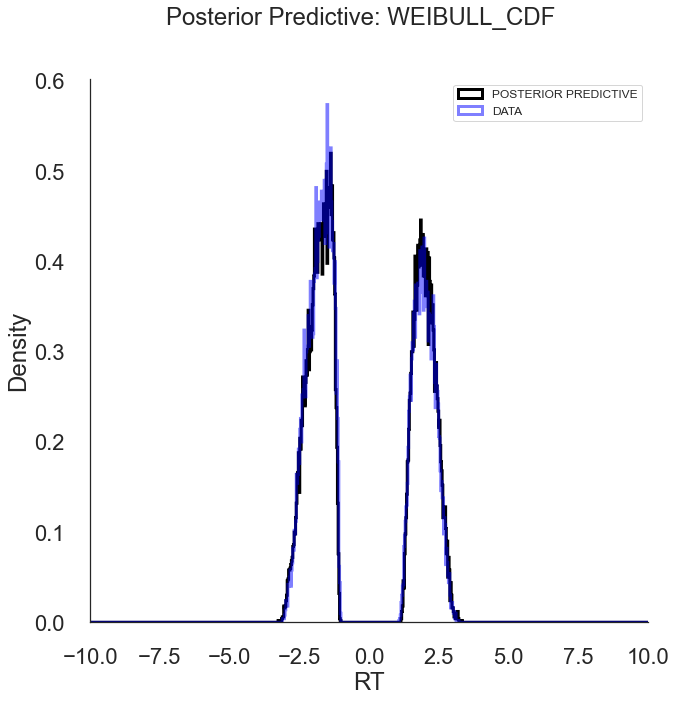

In [11]:
simulations = simulator(theta = weibull_params.values[0],
                        model = 'weibull_cdf', 
                        n_samples = 20000)

posterior_predictive_plot(posterior_samples = hddm_model_weibull_single_subject.get_traces(),
                          ground_truths_parameters = None, #weibull_params.values[0],
                          ground_truths_data = np.concatenate([simulations[0], simulations[1]], axis = 1), # None
                          n_plots = 1,
                          cols = 1,
                          model_fitted = 'weibull_cdf',
                          model_gt = None, #'weibull_cdf',
                          datatype = 'single_subject',
                          n_post_params = 200,
                          samples_by_param = 100,
                          xlimit = 10,
                          bin_size = 0.025, 
                          hist_linewidth = 3)

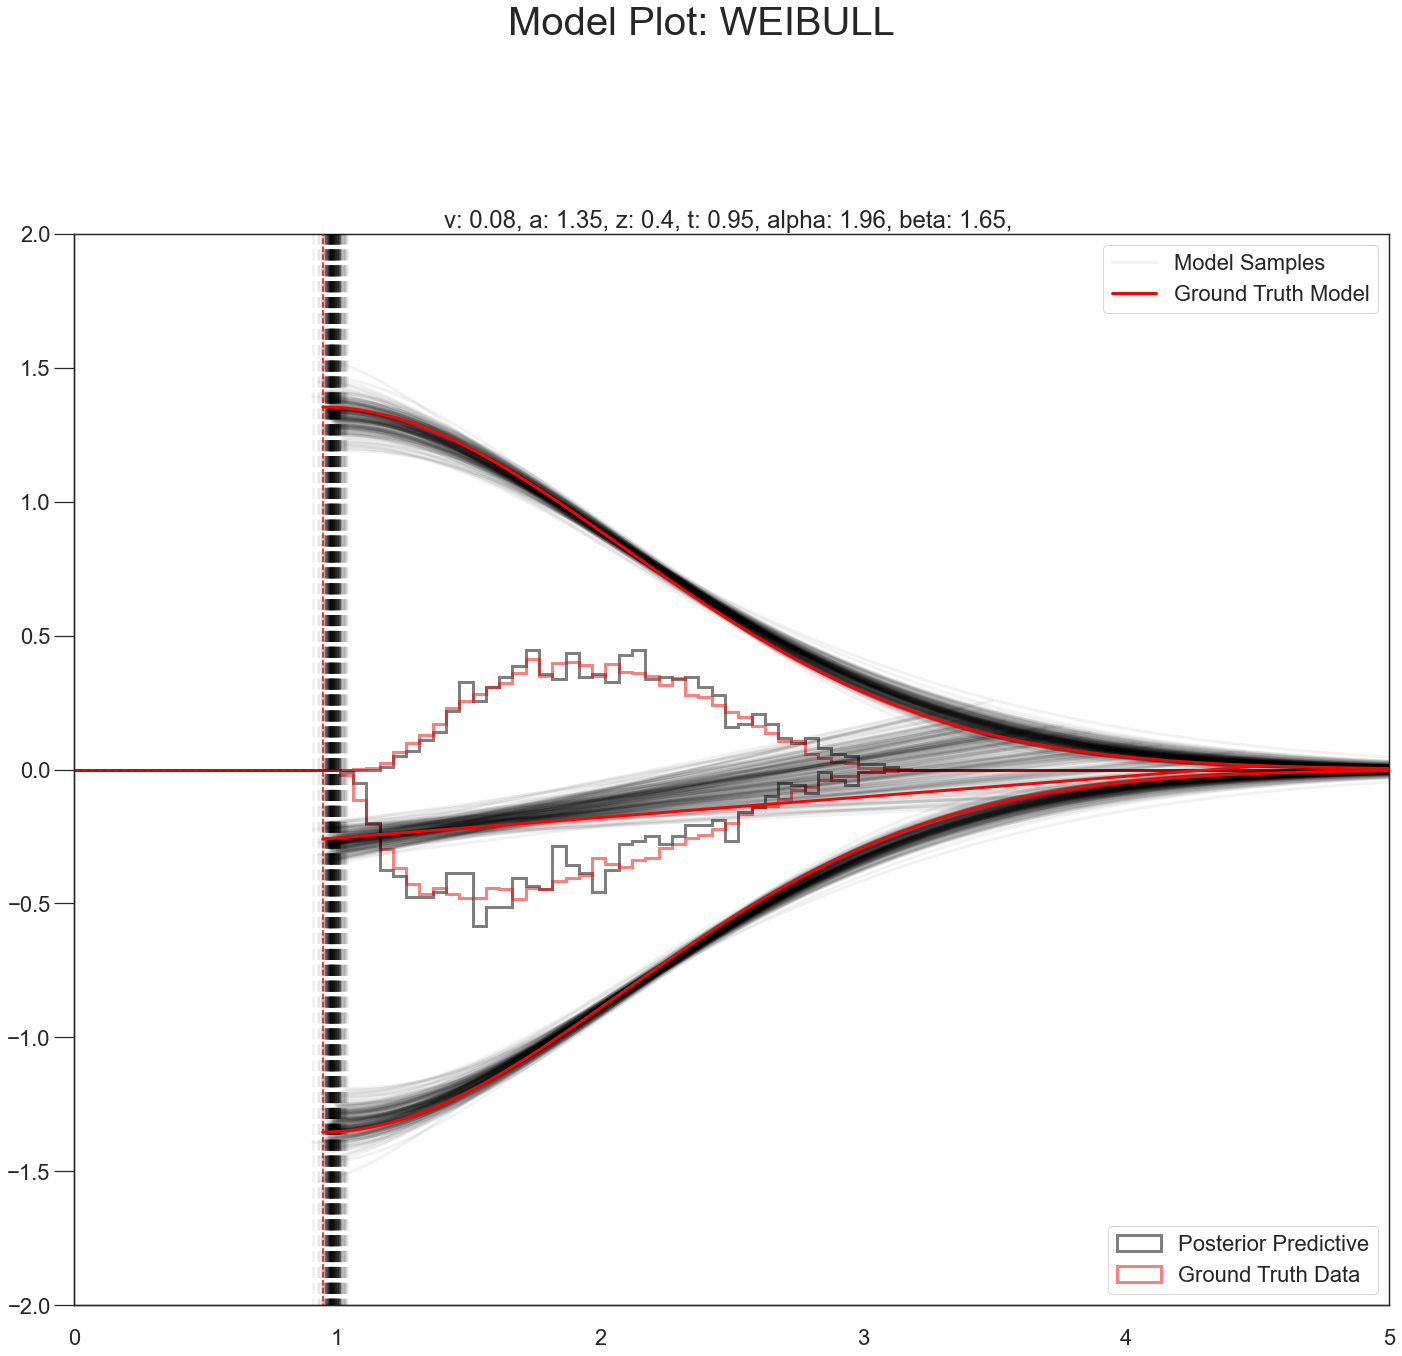

In [10]:
# Posterior Predictive: Do we generate meaningful data from the Posterior Model?
model_plot(ground_truths_parameters = weibull_params.values[0],
           ground_truths_data = None,
           posterior_samples =  hddm_model_weibull_single_subject.get_traces(),
           model_gt = 'weibull_cdf',
           model_fitted = 'weibull_cdf',
           n_post_params = 200,
           cols = 1,
           n_plots = 1,
           max_t = 5, 
           show_model = True,
           input_hddm_trace = True,
           datatype = 'single_subject')

We can also overlay the traces on the previous plot to see whether or not the trace is making sense. Every black line/curve is one trace's parameter. The wider a bundle the curves make, the more variability there is in the trace. The more they form one solid dark line, the less variability.

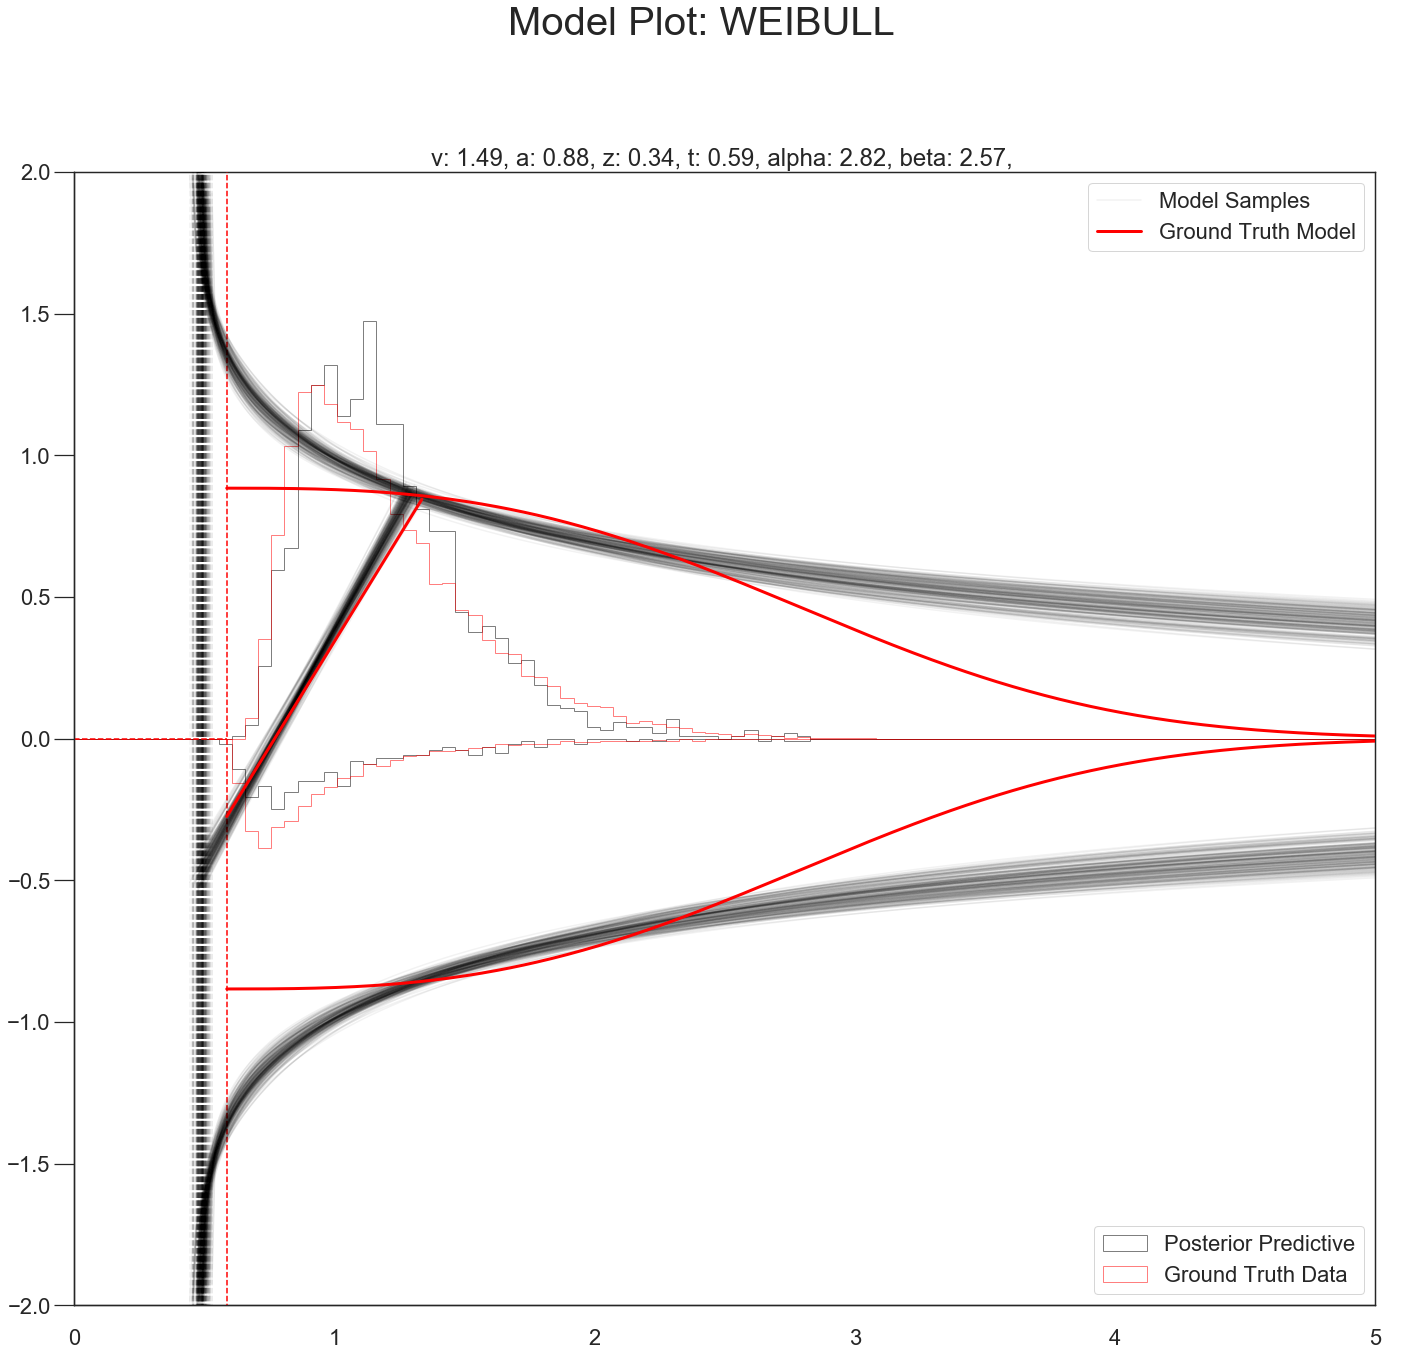

In [11]:
# Posterior Predictive: Do the 'Posterior Models' also make sense?
model_plot(ground_truths_parameters = weibull_params.values[0],
           posterior_samples =  hddm_model_weibull_single_subject.get_traces(),
           model_gt = 'weibull_cdf',
           model_fitted = 'weibull_cdf',
           n_post_params = 200,
           cols = 1,
           n_plots = 1,
           max_t = 5, 
           show_model = True,
           input_hddm_trace = True,
           datatype = 'single_subject')

#### A small note on convergence

Note that the MCMC algorithm requires the chain to converge.There are many heuristics that help you identifying problems with convergence, such as the trace plot, auto correltion plot, and marginal posterior histogram. In the trace plots, there might be a problem if you see large jumps. In the autocorrelation plot, there might be a problem if it does not drop rapidly.

In [ ]:
# TAKING A LOOK AT THE POSTERIOR TRACES
hddm_model_weibull_single_subject.plot_posteriors(['a', 't', 'v', 'z', 'alpha', 'beta'])

In [ ]:
# Pairwise posterior plot
posterior_pair_plot(posterior_samples = hddm_model_weibull_single_subject.get_traces(),
                    height = 10,
                    aspect = 1,
                    n_subsample = 200,
                    ground_truths = weibull_params_s.values[0],
                    model = 'weibull_cdf')

Ideally we would want to simulate a dataset from scratch and fitting it. The code to do so, is commented out above. However, due to time constraints, we will sometimes load in a dataset, its ground truth parameter and its trace. Note that the ``pickle`` is a tuple of:

0. The trace
1. Ground truth parameter
2. Dataset

So instead of running the sampler for every model we show, we will sometime load **pre-computed posteriors** some or all of the times below. Code for loading such datasets is listed below.

In [23]:
# Load in the data
load_in = pickle.load(open('data_storage/single_subject_weibull_n_1000.pickle', 'rb'))

weibull_trace_s = load_in[0]
weibull_params_s = load_in[1]
weibull_dataset_s = load_in[2]

Let us quickly inspect what we have loaded there.

In [ ]:
# The dataset
weibull_dataset_s.head()

In [ ]:
# The groundtruth parameters
weibull_params_s

In [88]:
# The pre-computed trace
weibull_trace_s.head()

a         v         t   z_trans      beta     alpha
0  1.387207 -0.416730  0.422329 -0.371980  2.176990  2.385490
1  1.361826 -0.422416  0.436861 -0.404456  2.187864  2.375570
2  1.346161 -0.446058  0.446897 -0.423029  2.223950  2.379973
3  1.347924 -0.465763  0.452156 -0.433510  2.212851  2.424667
4  1.339708 -0.360379  0.470504 -0.443158  2.184911  2.498354

### ANGLE MODEL

We can do the same thing for the **Angle model**. (Precomputed here)

In [96]:
load_in = pickle.load(open("single_subject_angle_n_1000.pickle", "rb"))
angle_trace_s = load_in[0]
angle_params_s = load_in[1]
angle_dataset_s = load_in[2]

In [97]:
angle_params_s

v         a         z         t     theta
0 -0.973407  0.872892  0.350307  1.499637  0.573077

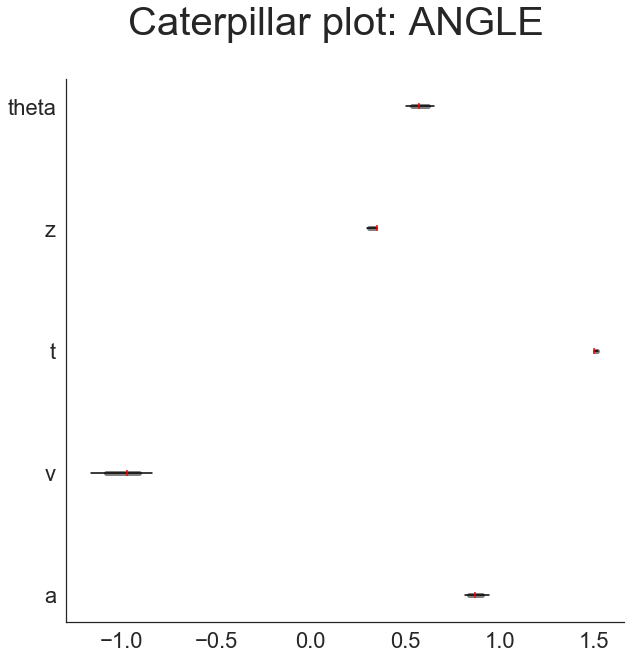

In [99]:
# Caterpillar Plot: 
caterpillar_plot(posterior_samples = angle_trace_s,
                 ground_truths = angle_params_s.values[0],
                 model = 'angle',
                 datatype = 'single_subject',
                 drop_sd = True)

passed through legend part
0
0


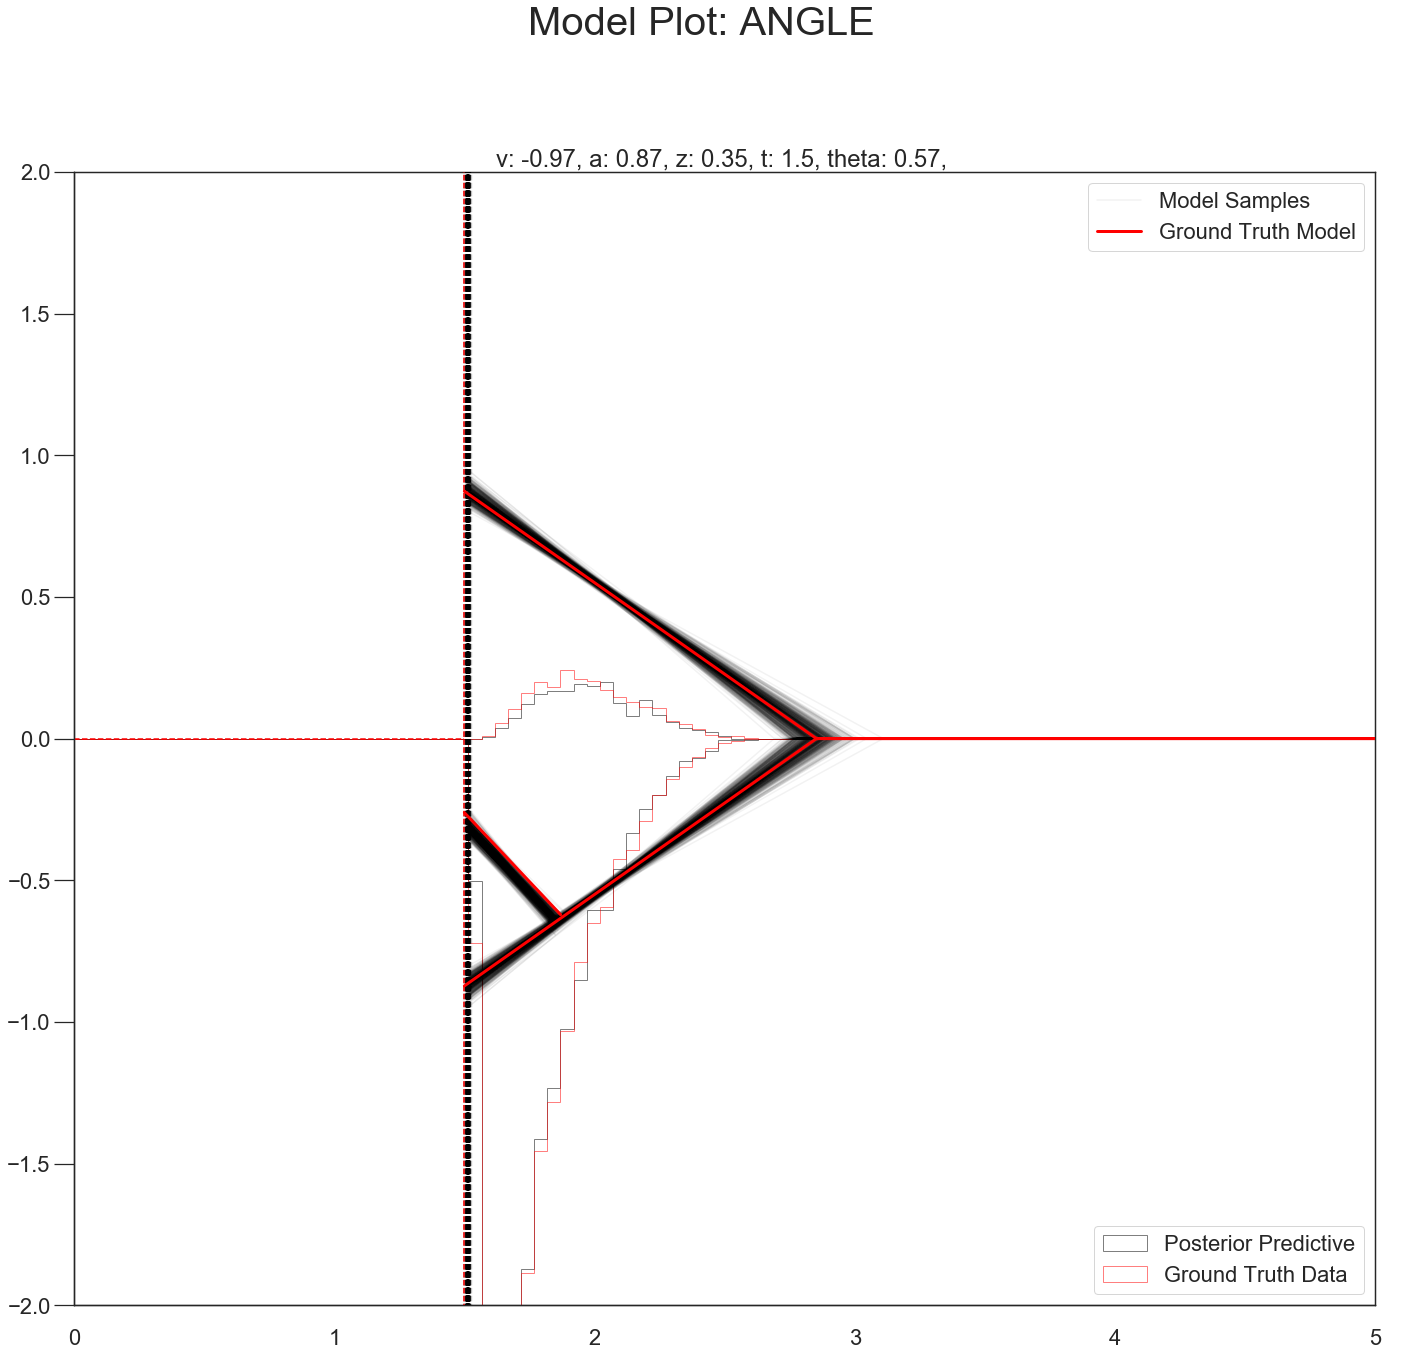

In [101]:
# Posterior Predictive with model line
model_plot(ground_truths_parameters = angle_params_s.values[0],
           posterior_samples = angle_trace_s,
           model_gt = 'angle',
           model_fitted = 'angle',
           n_post_params = 500,
           cols = 1,
           n_plots = 1,
           max_t = 5, 
           show_model = True,
           input_hddm_trace = True,
           datatype = 'single_subject')

In [57]:
hddm_model_single_subject = hddm.HDDMnn_angle(a_process, 
                                              informative = False, 
                                              free = False, 
                                              include = ['z'],
                                              is_group_model = False)

In [58]:
hddm_model_single_subject.sample(1500, burn = 200, dbname = 'traces.db', db = 'pickle')

 [-----------------100%-----------------] 1501 of 1500 complete in 937.6 sec

In [59]:
pickle.dump( (hddm_model_single_subject.get_traces(),
              angle_params,
              a_process), open("single_subject_angle_n_1000.pickle", "wb") )

# Section 3: Fitting hierarchical model

The 'h' in `hddm` stands for hierarchical, so let's do it! If we have data from multiple participants and we assume that the parameters of single participants are drawn from respective **group** or **global** distributions, we can model this explicitly in `hddm` by specifying `is_group_model = True`.

Implicitly we are fitting a model of the following kind,

$$p(\{\theta_j\}, \{\theta_g\} | \mathbf{x}) \propto \left[ \prod_j^{J} \left[ \prod_i^{N_j} p(x_i^j | \theta_j) \right] p(\theta_j | \theta_g) \right] p( \theta_g | \theta_h )$$

where (let's say for the **angle model**),
1. $\theta_j = \{v_j, a_j, z_j, t_j, \theta_j \}$, are the model parameters for **subject j**.

2. $\theta_g = \{v_g^{\mu}, a_g^{\mu}, z_g^{\mu}, t_g^{\mu}, \theta_g^{\mu}, v_g^{\sigma}, a_g^{\sigma}, z_g^{\sigma}, t_g^{\sigma}, \theta_g^{\sigma} \}$ (scary, but for completeness), are the **mean** and **variance** parameters for our group level normal distributions, and $\{ \theta_h \}$ are **fixed hyperparameters**.

3. $x_i^j = \{rt_i^j, c_i^j \}$, are the **choice and reaction time**  of **subject j** during **trial i**.

In words, the right hand side of the equation tells us that we have a **global parameter distribution** with certain **means** and **variances** for each parameter (we want to figure these means and variances out), from which the **subject level parameters** are drawn and finally **subject level datapoints** follow the likelihood distribution of our **ddm / angle / weibull / you name it** mdoels.

### ANGLE MODEL

### Loading a dataset from a hierarchical generating process

Below the code you can run to generate a fit online. We will use a preloaded fit here.

In [6]:
# Simulate data angle
hddm_data_hierarchical, gt_hierarchical, gt_mat_hierarchical = simulator_hierarchical(n_subjects = 10,
                                                                                      model = 'angle',
                                                                                      n_samples_by_subject = 500)

In [7]:
hddm_hierarchical_model_angle = hddm.HDDMnn(hddm_data_hierarchical, 
                                            model = 'angle',
                                            informative = False,
                                            include = ['z', 'theta'],
                                            is_group_model = True)

knodes
OrderedDict([('a', a), ('a_std', a_std), ('a_tau', a_tau), ('a_bottom', a_subj), ('v', v), ('v_std', v_std), ('v_tau', v_tau), ('v_bottom', v_subj), ('t', t), ('t_std', t_std), ('t_tau', t_tau), ('t_bottom', t_subj), ('z_trans', z_trans), ('z', z), ('z_std', z_std), ('z_tau', z_tau), ('z_subj_trans', z_subj_trans), ('z_bottom', z_subj), ('theta', theta), ('theta_std', theta_std), ('theta_tau', theta_tau), ('theta_bottom', theta_subj)])
wfpt parents: 
OrderedDict([('a', a_subj), ('v', v_subj), ('t', t_subj), ('sv', 0), ('sz', 0), ('st', 0), ('z', z_subj), ('p_outlier', 0), ('theta', theta_subj)])


In [8]:
# # Sampling:
nmcmc = 400
hddm_hierarchical_model_angle.sample(nmcmc,
                                     burn = 100)

 [-----------------100%-----------------] 401 of 400 complete in 339.7 sec

In [9]:
hddm_hierarchical_model_angle.get_traces()

a     a_std  a_subj.000  a_subj.001  a_subj.002  a_subj.003  \
0    0.696359  0.117798    0.947937    0.883214    0.652884    0.806019   
1    0.778617  0.126547    0.943061    0.875805    0.660606    0.805393   
2    0.726872  0.117459    0.937603    0.876623    0.673971    0.825365   
3    0.799744  0.153129    0.934354    0.876732    0.678224    0.791806   
4    0.792258  0.161459    0.935813    0.875666    0.675017    0.784124   
..        ...       ...         ...         ...         ...         ...   
295  0.801226  0.157605    1.006016    0.984904    0.675311    0.757082   
296  0.795687  0.152502    1.016274    0.979482    0.692201    0.774535   
297  0.679669  0.204987    1.023859    0.992023    0.693563    0.773832   
298  0.975219  0.262054    1.033620    0.995373    0.740152    0.759982   
299  0.753080  0.237045    0.997839    0.984430    0.745157    0.752762   

     a_subj.004  a_subj.005  a_subj.006  a_subj.007  ...  theta_subj.000  \
0      0.857193    0.678443    0.901499    0.708597  ...        0.910290   
1      0.832199    0.679434    0.907189    0.728868  ...        0.890190   
2      0.888235    0.688373    0.912628    0.706567  ...        0.886354   
3      0.907259    0.679814    0.941545    0.711232  ...        0.880960   
4      0.894418    0.724885    0.940156    0.728631  ...        0.884044   
..          ...         ...         ...         ...  ...             ...   
295    0.914340    0.729492    0.939627    0.747013  ...        0.920509   
296    0.899711    0.738961    0.928870    0.758515  ...        0.936879   
297    0.888590    0.726785    0.944288    0.753750  ...        0.939648   
298    0.889225    0.722261    0.949951    0.755822  ...        0.937927   
299    0.916360    0.712427    0.946473    0.743067  ...        0.927701   

     theta_subj.001  theta_subj.002  theta_subj.003  theta_subj.004  \
0          0.871448        0.762986        0.810313        0.854541   
1          0.867738        0.776173        0.839074        0.826089   
2          0.871807        0.795070        0.841300        0.882753   
3          0.871672        0.765630        0.849052        0.908496   
4          0.867122        0.770135        0.850775        0.879481   
..              ...             ...             ...             ...   
295        0.900951        0.780554        0.792136        0.895213   
296        0.897970        0.773068        0.812659        0.856852   
297        0.911986        0.842224        0.792565        0.859734   
298        0.903408        0.870218        0.786430        0.886130   
299        0.906618        0.858395        0.804469        0.882512   

     theta_subj.005  theta_subj.006  theta_subj.007  theta_subj.008  \
0          0.756471        0.803099        0.712580        0.822622   
1          0.745900        0.827079        0.771686        0.825640   
2          0.736238        0.832901        0.771935        0.840375   
3          0.730995        0.832772        0.729804        0.830392   
4          0.773701        0.842990        0.707790        0.828807   
..              ...             ...             ...             ...   
295        0.805135        0.840822        0.786621        0.779454   
296        0.812464        0.822637        0.805769        0.789823   
297        0.790694        0.827102        0.776236        0.817846   
298        0.789114        0.839794        0.796254        0.784881   
299        0.761488        0.838291        0.766175        0.804769   

     theta_subj.009  
0          0.863589  
1          0.895787  
2          0.821086  
3          0.827539  
4          0.856474  
..              ...  
295        0.914537  
296        0.912850  
297        0.859690  
298        0.883041  
299        0.848824  

[300 rows x 60 columns]

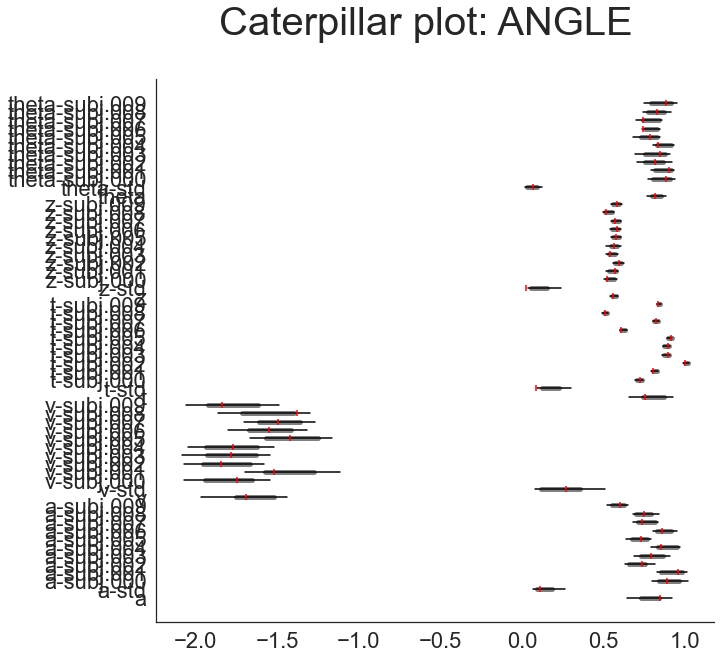

In [10]:
# Caterpillar Plot
caterpillar_plot(posterior_samples = hddm_hierarchical_model_angle.get_traces(),
                 ground_truths = gt_hierarchical,
                 model = 'angle',
                 datatype = 'hierarchical',
                 drop_sd = False,
                 save = False)

In [55]:
# Posterior Predictive
model_plot(ground_truths_parameters = gt_mat_hierarchical,
           posterior_samples = hddm_hierarchical_model_angle.get_traces(),
           ground_truths_data = None,
           input_hddm_trace = True,
           n_post_params = 100,
           samples_by_param = 200,
           cols = 2, 
           model_gt = 'angle',
           model_fitted = 'angle',
           datatype = 'hierarchical',
           n_plots = 10,
           max_t = 5,
           show_model = True,
           save = True)

(10, 3000, 5)


### WEIBULL MODEL

In [75]:
# Simulate data weibull
hddm_data_hierarchical, gt_hierarchical, gt_mat_hierarchical = simulator_hierarchical(n_subjects = 20,
                                                                                      model = 'weibull_cdf',
                                                                                      n_samples_by_subject = 500)

In [76]:
hddm_data_hierarchical

rt  response  nn_response subj_idx
0    1.563122         0           -1      000
1    0.927122         0           -1      000
2    0.799124         0           -1      000
3    1.478118         0           -1      000
4    1.140120         0           -1      000
..        ...       ...          ...      ...
495  0.649885         0           -1      019
496  1.049880         0           -1      019
497  1.138879         0           -1      019
498  1.444877         0           -1      019
499  1.120879         0           -1      019

[10000 rows x 4 columns]

In [77]:
hddm_hierarchical_model_weibull = hddm.HDDMnn(hddm_data_hierarchical,
                                              model = 'weibull',
                                              informative = False,
                                              include = ['z', 'alpha', 'beta'],
                                              is_group_model = True)

knodes
OrderedDict([('a', a), ('a_std', a_std), ('a_tau', a_tau), ('a_bottom', a_subj), ('v', v), ('v_std', v_std), ('v_tau', v_tau), ('v_bottom', v_subj), ('t', t), ('t_std', t_std), ('t_tau', t_tau), ('t_bottom', t_subj), ('z_trans', z_trans), ('z', z), ('z_std', z_std), ('z_tau', z_tau), ('z_subj_trans', z_subj_trans), ('z_bottom', z_subj), ('alpha', alpha), ('alpha_std', alpha_std), ('alpha_tau', alpha_tau), ('alpha_bottom', alpha_subj), ('beta', beta), ('beta_std', beta_std), ('beta_tau', beta_tau), ('beta_bottom', beta_subj)])
wfpt parents: 
OrderedDict([('a', a_subj), ('v', v_subj), ('t', t_subj), ('sv', 0), ('sz', 0), ('st', 0), ('z', z_subj), ('p_outlier', 0), ('alpha', alpha_subj), ('beta', beta_subj)])


In [78]:
nmcmc = 2000
hddm_hierarchical_model_weibull.sample(nmcmc,
                                        burn = 100)

 [-----------------100%-----------------] 2001 of 2000 complete in 3611.9 sec

In [50]:
hddm_hierarchical_model_weibull.gen_stats()[110:130]

Empty DataFrame
Columns: [mean, std, 2.5q, 25q, 50q, 75q, 97.5q, mc err]
Index: []

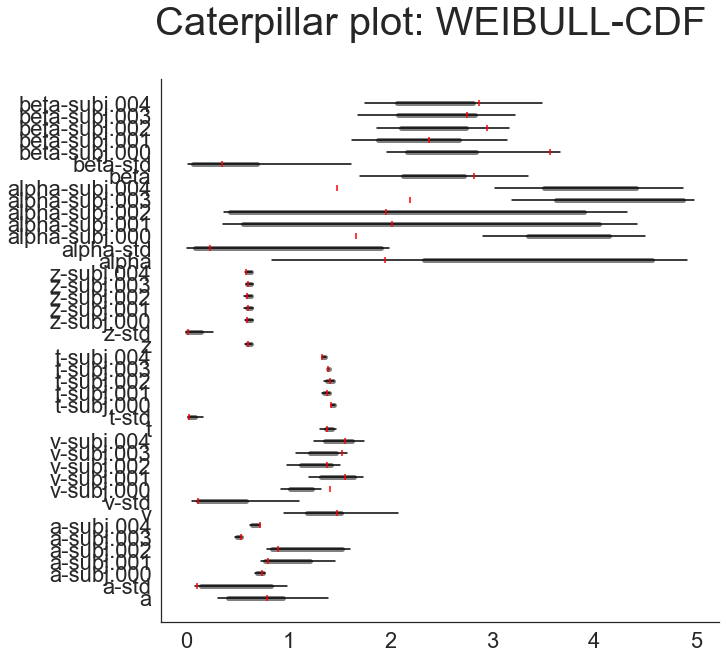

In [57]:
# Caterpillar Plot
caterpillar_plot(posterior_samples = hddm_hierarchical_model_weibull.get_traces(),
                 ground_truths = gt_hierarchical,
                 model = 'weibull_cdf',
                 datatype = 'hierarchical',
                 drop_sd = False,
                 save = False)

(5, 900, 6)


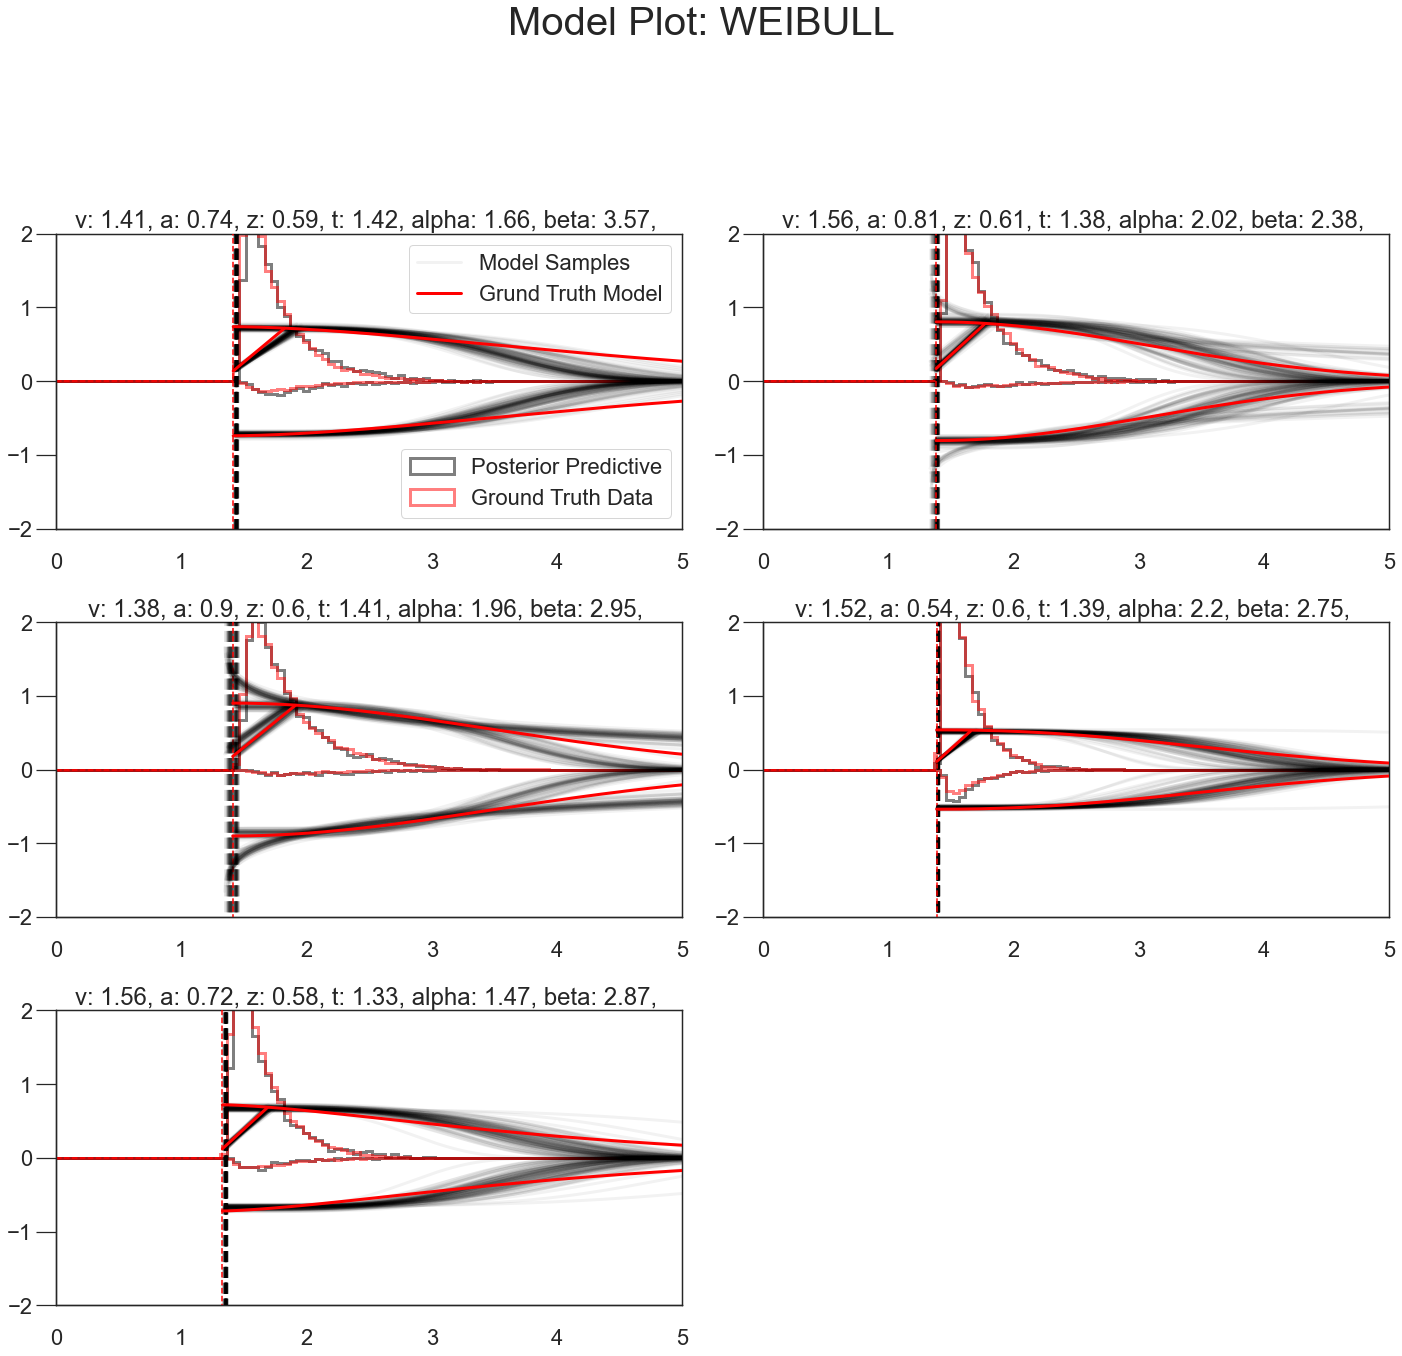

In [58]:
# Posterior Predictive
model_plot(ground_truths_parameters = gt_mat_hierarchical,
           posterior_samples = hddm_hierarchical_model_weibull.get_traces(),
           ground_truths_data = None,
           input_hddm_trace = True,
           n_post_params = 100,
           samples_by_param = 50,
           cols = 2, 
           model_gt = 'weibull_cdf',
           model_fitted = 'weibull_cdf',
           datatype = 'hierarchical',
           n_plots = 10,
           max_t = 5,
           show_model = True,
           save = False)

In [6]:
gt_hierarchical

{'v': 1.0423797195051705,
 'v_std': 0.09910608299203738,
 'a': 1.3119376333301633,
 'a_std': 0.010348023740227575,
 'z': 0.3271285555209222,
 'z_std': 0.02098031138438956,
 't': 0.5975396273133422,
 't_std': 0.11900381878038578,
 'theta': 0.8676542988493168,
 'theta_std': 0.041026248291328775,
 'v_subj.000': 1.0615142583847046,
 'a_subj.000': 1.3231779336929321,
 'z_subj.000': 0.3059881627559662,
 't_subj.000': 0.6012510657310486,
 'theta_subj.000': 0.8262891173362732,
 'v_subj.001': 0.9147017598152161,
 'a_subj.001': 1.3217731714248657,
 'z_subj.001': 0.3662543296813965,
 't_subj.001': 0.6213908195495605,
 'theta_subj.001': 0.849717378616333,
 'v_subj.002': 1.0396729707717896,
 'a_subj.002': 1.3135520219802856,
 'z_subj.002': 0.3550432324409485,
 't_subj.002': 0.7358123064041138,
 'theta_subj.002': 0.9154043793678284,
 'v_subj.003': 0.9835380911827087,
 'a_subj.003': 1.3174878358840942,
 'z_subj.003': 0.31525442004203796,
 't_subj.003': 0.5180774331092834,
 'theta_subj.003': 0.8400936

In [27]:
hddm_hierarchical_model_weibull.gen_stats()

mean        std        2.5q        25q        50q  \
a                 1.06519   0.247456     0.49395    1.00349    1.03842   
a_std             12.3088    25.6079     0.07005  0.0996898   0.126521   
a_subj.000        1.02598  0.0277538    0.973508    1.00677    1.02522   
a_subj.001       0.997986  0.0365034    0.938734   0.974446    0.99442   
a_subj.002        1.21484  0.0373903     1.14533    1.18916    1.21324   
a_subj.003       0.998655  0.0283217    0.944959   0.979221   0.998612   
a_subj.004        1.32552   0.333011     1.09476    1.13902    1.16579   
a_subj.005        1.13085  0.0383961      1.0632    1.10461    1.12839   
a_subj.006       0.911496  0.0279057    0.863466   0.893468    0.90977   
a_subj.007        1.01826  0.0323723    0.961383   0.996307    1.01675   
a_subj.008        1.10312   0.350747    0.883157   0.917098   0.937305   
a_subj.009       0.998778  0.0276935    0.946979   0.979682   0.998085   
v               -0.554116  0.0270653   -0.607951  -0.572229  -0.553842   
v_std           0.0399204  0.0281133  0.00314738  0.0187032  0.0355713   
v_subj.000      -0.524105  0.0438597   -0.597168  -0.554279  -0.529285   
v_subj.001      -0.550848  0.0375537   -0.622269  -0.575008  -0.551703   
v_subj.002      -0.575549  0.0379216   -0.659312  -0.598255  -0.573027   
v_subj.003      -0.568398   0.038506   -0.652188  -0.591646  -0.566327   
v_subj.004      -0.578311  0.0459421   -0.677906  -0.606051  -0.574639   
v_subj.005      -0.568249  0.0372637   -0.650194  -0.590893  -0.565839   
v_subj.006      -0.555375  0.0388635    -0.63225  -0.579801   -0.55517   
v_subj.007      -0.547932  0.0374333   -0.618925  -0.573064  -0.549454   
v_subj.008      -0.538325  0.0428439   -0.614154  -0.566642  -0.542205   
v_subj.009      -0.536661  0.0398916   -0.608212  -0.563515  -0.539674   
t                 1.29862  0.0685534     1.23353    1.28485    1.30294   
t_std            0.549929    5.53888   0.0421331  0.0586276  0.0720321   
t_subj.000        1.28274  0.0160816     1.24951    1.27233    1.28352   
t_subj.001        1.27315  0.0173565     1.23409    1.26304    1.27469   
t_subj.002        1.37817  0.0220066     1.33376    1.36375    1.37864   
t_subj.003        1.26587  0.0150624     1.23519    1.25587     1.2664   
...                   ...        ...         ...        ...        ...   
z_subj.004       0.427503  0.0140723    0.396564   0.419256     0.4284   
z_subj.005       0.433639  0.0105974      0.4124   0.426818    0.43358   
z_subj.006       0.438056  0.0109949     0.41874   0.430551   0.437235   
z_subj.007       0.438992  0.0110631     0.41993   0.431446   0.438155   
z_subj.008       0.434875  0.0133382    0.410634   0.425867   0.433674   
z_subj.009       0.427728  0.0116456    0.402098   0.420985   0.428688   
beta              2.10938    0.23683     1.97127    2.05679    2.09472   
beta_std         0.557141    5.22577   0.0838002    0.12397   0.153754   
beta_subj.000     2.23793   0.074511     2.11315    2.18658    2.23092   
beta_subj.001     1.94609  0.0788668     1.82233    1.89256    1.93531   
beta_subj.002     2.17143  0.0487611     2.08221    2.13728    2.16877   
beta_subj.003     2.13746  0.0946571     2.00963     2.0865    2.13032   
beta_subj.004     2.02584  0.0669655     1.90617    1.98546     2.0214   
beta_subj.005     1.87506  0.0504187     1.78821    1.84099      1.871   
beta_subj.006     2.21295   0.253906     2.02397    2.12036    2.17779   
beta_subj.007     2.05699  0.0919035     1.93612    2.00316    2.04626   
beta_subj.008     2.10174   0.151642     1.65242    2.05499    2.12049   
beta_subj.009     2.22901   0.181966     2.08816     2.1645    2.21089   
alpha             4.47697    1.10494    0.900222    4.86097    4.95125   
alpha_std         10.8606    24.5633  0.00208028  0.0248397  0.0632633   
alpha_subj.000    4.82393   0.325475     3.68998    4.85558     4.9386   
alpha_subj.001    4.59017   0.750886     2.40073    4.78904    4.93355   
alpha_subj.002    4.90654

In [ ]:
gt_mat_hierarchical

In [7]:
gt_mat_hierarchical

array([[-0.23921089,  1.21034598,  0.63846606,  0.86776602,  0.6032657 ],
       [-0.15510732,  1.15070486,  0.61917293,  0.71828097,  0.52269644],
       [-0.22020568,  1.18023336,  0.6334666 ,  0.88593066,  0.59373564],
       [-0.15240714,  1.28296232,  0.63043737,  0.98110789,  0.58957195],
       [-0.17668901,  1.17889369,  0.62838918,  0.75018096,  0.50014699],
       [-0.13619599,  1.16835427,  0.65165728,  0.88833153,  0.50350165],
       [-0.21920118,  1.18832159,  0.65620989,  0.87999868,  0.5055089 ],
       [-0.20238332,  1.15393698,  0.64722109,  0.89613169,  0.51973712],
       [-0.18276727,  1.17673898,  0.67673969,  0.80064285,  0.60020244],
       [-0.17320532,  1.27217317,  0.62711978,  0.78133714,  0.50663179]])

In [22]:
hddm_hierarchical_model_weibull.plot_posteriors()

Plotting a
Plotting a_std
Plotting v
Plotting v_std
Plotting t
Plotting t_std
Plotting z
Plotting z_std
Plotting beta
Plotting beta_std
Plotting alpha
Plotting alpha_std


RuntimeError: dvipng was not able to process the following string:
b''

Here is the full report generated by dvipng:
/Users/afengler/.matplotlib/tex.cache/c3c23a1028fc21b4f857189e40aad5af.dvi: No such file or directory
This is dvipng 1.17 Copyright 2002-2015, 2019 Jan-Ake Larsson




<Figure size 720x432 with 3 Axes>

RuntimeError: latex was not able to process the following string:
b' a_std trace'

Here is the full report generated by latex:
This is pdfTeX, Version 3.14159265-2.6-1.40.21 (TeX Live 2020) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode
(/Users/afengler/.matplotlib/tex.cache/2c1f4385e9b4cdb6466050cfcbb1c9bf.tex
LaTeX2e <2020-02-02> patch level 5
L3 programming layer <2020-03-06>
(/usr/local/texlive/2020/texmf-dist/tex/latex/base/article.cls
Document Class: article 2019/12/20 v1.4l Standard LaTeX document class
(/usr/local/texlive/2020/texmf-dist/tex/latex/base/size10.clo))
(/usr/local/texlive/2020/texmf-dist/tex/latex/type1cm/type1cm.sty)
(/usr/local/texlive/2020/texmf-dist/tex/latex/base/textcomp.sty)
(/usr/local/texlive/2020/texmf-dist/tex/latex/base/inputenc.sty)
(/usr/local/texlive/2020/texmf-dist/tex/latex/geometry/geometry.sty
(/usr/local/texlive/2020/texmf-dist/tex/latex/graphics/keyval.sty)
(/usr/local/texlive/2020/texmf-dist/tex/generic/iftex/ifvtex.sty
(/usr/local/texlive/2020/texmf-dist/tex/generic/iftex/iftex.sty))

Package geometry Warning: Over-specification in `h'-direction.
    `width' (5058.9pt) is ignored.


Package geometry Warning: Over-specification in `v'-direction.
    `height' (5058.9pt) is ignored.

) (/usr/local/texlive/2020/texmf-dist/tex/latex/l3backend/l3backend-dvips.def)
No file 2c1f4385e9b4cdb6466050cfcbb1c9bf.aux.
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
! Missing $ inserted.
<inserted text> 
                $
l.14 \fontsize{19.992000}{24.990000}{\sffamily  a_
                                                  std trace}
No pages of output.
Transcript written on 2c1f4385e9b4cdb6466050cfcbb1c9bf.log.




<Figure size 720x432 with 3 Axes>

RuntimeError: dvipng was not able to process the following string:
b''

Here is the full report generated by dvipng:
/Users/afengler/.matplotlib/tex.cache/c3c23a1028fc21b4f857189e40aad5af.dvi: No such file or directory
This is dvipng 1.17 Copyright 2002-2015, 2019 Jan-Ake Larsson




<Figure size 720x432 with 3 Axes>

RuntimeError: latex was not able to process the following string:
b' v_std trace'

Here is the full report generated by latex:
This is pdfTeX, Version 3.14159265-2.6-1.40.21 (TeX Live 2020) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode
(/Users/afengler/.matplotlib/tex.cache/becc704c9ee3f6b630c95c15bdf0d9f0.tex
LaTeX2e <2020-02-02> patch level 5
L3 programming layer <2020-03-06>
(/usr/local/texlive/2020/texmf-dist/tex/latex/base/article.cls
Document Class: article 2019/12/20 v1.4l Standard LaTeX document class
(/usr/local/texlive/2020/texmf-dist/tex/latex/base/size10.clo))
(/usr/local/texlive/2020/texmf-dist/tex/latex/type1cm/type1cm.sty)
(/usr/local/texlive/2020/texmf-dist/tex/latex/base/textcomp.sty)
(/usr/local/texlive/2020/texmf-dist/tex/latex/base/inputenc.sty)
(/usr/local/texlive/2020/texmf-dist/tex/latex/geometry/geometry.sty
(/usr/local/texlive/2020/texmf-dist/tex/latex/graphics/keyval.sty)
(/usr/local/texlive/2020/texmf-dist/tex/generic/iftex/ifvtex.sty
(/usr/local/texlive/2020/texmf-dist/tex/generic/iftex/iftex.sty))

Package geometry Warning: Over-specification in `h'-direction.
    `width' (5058.9pt) is ignored.


Package geometry Warning: Over-specification in `v'-direction.
    `height' (5058.9pt) is ignored.

) (/usr/local/texlive/2020/texmf-dist/tex/latex/l3backend/l3backend-dvips.def)
No file becc704c9ee3f6b630c95c15bdf0d9f0.aux.
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
! Missing $ inserted.
<inserted text> 
                $
l.14 \fontsize{19.992000}{24.990000}{\sffamily  v_
                                                  std trace}
No pages of output.
Transcript written on becc704c9ee3f6b630c95c15bdf0d9f0.log.




<Figure size 720x432 with 3 Axes>

RuntimeError: dvipng was not able to process the following string:
b''

Here is the full report generated by dvipng:
/Users/afengler/.matplotlib/tex.cache/c3c23a1028fc21b4f857189e40aad5af.dvi: No such file or directory
This is dvipng 1.17 Copyright 2002-2015, 2019 Jan-Ake Larsson




<Figure size 720x432 with 3 Axes>

RuntimeError: latex was not able to process the following string:
b' t_std trace'

Here is the full report generated by latex:
This is pdfTeX, Version 3.14159265-2.6-1.40.21 (TeX Live 2020) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode
(/Users/afengler/.matplotlib/tex.cache/fdd295417ec87c89a28d2fdd35225a95.tex
LaTeX2e <2020-02-02> patch level 5
L3 programming layer <2020-03-06>
(/usr/local/texlive/2020/texmf-dist/tex/latex/base/article.cls
Document Class: article 2019/12/20 v1.4l Standard LaTeX document class
(/usr/local/texlive/2020/texmf-dist/tex/latex/base/size10.clo))
(/usr/local/texlive/2020/texmf-dist/tex/latex/type1cm/type1cm.sty)
(/usr/local/texlive/2020/texmf-dist/tex/latex/base/textcomp.sty)
(/usr/local/texlive/2020/texmf-dist/tex/latex/base/inputenc.sty)
(/usr/local/texlive/2020/texmf-dist/tex/latex/geometry/geometry.sty
(/usr/local/texlive/2020/texmf-dist/tex/latex/graphics/keyval.sty)
(/usr/local/texlive/2020/texmf-dist/tex/generic/iftex/ifvtex.sty
(/usr/local/texlive/2020/texmf-dist/tex/generic/iftex/iftex.sty))

Package geometry Warning: Over-specification in `h'-direction.
    `width' (5058.9pt) is ignored.


Package geometry Warning: Over-specification in `v'-direction.
    `height' (5058.9pt) is ignored.

) (/usr/local/texlive/2020/texmf-dist/tex/latex/l3backend/l3backend-dvips.def)
No file fdd295417ec87c89a28d2fdd35225a95.aux.
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
! Missing $ inserted.
<inserted text> 
                $
l.14 \fontsize{19.992000}{24.990000}{\sffamily  t_
                                                  std trace}
No pages of output.
Transcript written on fdd295417ec87c89a28d2fdd35225a95.log.




<Figure size 720x432 with 3 Axes>

RuntimeError: dvipng was not able to process the following string:
b''

Here is the full report generated by dvipng:
/Users/afengler/.matplotlib/tex.cache/c3c23a1028fc21b4f857189e40aad5af.dvi: No such file or directory
This is dvipng 1.17 Copyright 2002-2015, 2019 Jan-Ake Larsson




<Figure size 720x432 with 3 Axes>

RuntimeError: latex was not able to process the following string:
b' z_std trace'

Here is the full report generated by latex:
This is pdfTeX, Version 3.14159265-2.6-1.40.21 (TeX Live 2020) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode
(/Users/afengler/.matplotlib/tex.cache/3eb004746ec54b988f66146d3746199b.tex
LaTeX2e <2020-02-02> patch level 5
L3 programming layer <2020-03-06>
(/usr/local/texlive/2020/texmf-dist/tex/latex/base/article.cls
Document Class: article 2019/12/20 v1.4l Standard LaTeX document class
(/usr/local/texlive/2020/texmf-dist/tex/latex/base/size10.clo))
(/usr/local/texlive/2020/texmf-dist/tex/latex/type1cm/type1cm.sty)
(/usr/local/texlive/2020/texmf-dist/tex/latex/base/textcomp.sty)
(/usr/local/texlive/2020/texmf-dist/tex/latex/base/inputenc.sty)
(/usr/local/texlive/2020/texmf-dist/tex/latex/geometry/geometry.sty
(/usr/local/texlive/2020/texmf-dist/tex/latex/graphics/keyval.sty)
(/usr/local/texlive/2020/texmf-dist/tex/generic/iftex/ifvtex.sty
(/usr/local/texlive/2020/texmf-dist/tex/generic/iftex/iftex.sty))

Package geometry Warning: Over-specification in `h'-direction.
    `width' (5058.9pt) is ignored.


Package geometry Warning: Over-specification in `v'-direction.
    `height' (5058.9pt) is ignored.

) (/usr/local/texlive/2020/texmf-dist/tex/latex/l3backend/l3backend-dvips.def)
No file 3eb004746ec54b988f66146d3746199b.aux.
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
! Missing $ inserted.
<inserted text> 
                $
l.14 \fontsize{19.992000}{24.990000}{\sffamily  z_
                                                  std trace}
No pages of output.
Transcript written on 3eb004746ec54b988f66146d3746199b.log.




<Figure size 720x432 with 3 Axes>

RuntimeError: dvipng was not able to process the following string:
b''

Here is the full report generated by dvipng:
/Users/afengler/.matplotlib/tex.cache/c3c23a1028fc21b4f857189e40aad5af.dvi: No such file or directory
This is dvipng 1.17 Copyright 2002-2015, 2019 Jan-Ake Larsson




<Figure size 720x432 with 3 Axes>

RuntimeError: latex was not able to process the following string:
b' beta_std trace'

Here is the full report generated by latex:
This is pdfTeX, Version 3.14159265-2.6-1.40.21 (TeX Live 2020) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode
(/Users/afengler/.matplotlib/tex.cache/3bfac34ff686f5167ba6ee70a4fd756a.tex
LaTeX2e <2020-02-02> patch level 5
L3 programming layer <2020-03-06>
(/usr/local/texlive/2020/texmf-dist/tex/latex/base/article.cls
Document Class: article 2019/12/20 v1.4l Standard LaTeX document class
(/usr/local/texlive/2020/texmf-dist/tex/latex/base/size10.clo))
(/usr/local/texlive/2020/texmf-dist/tex/latex/type1cm/type1cm.sty)
(/usr/local/texlive/2020/texmf-dist/tex/latex/base/textcomp.sty)
(/usr/local/texlive/2020/texmf-dist/tex/latex/base/inputenc.sty)
(/usr/local/texlive/2020/texmf-dist/tex/latex/geometry/geometry.sty
(/usr/local/texlive/2020/texmf-dist/tex/latex/graphics/keyval.sty)
(/usr/local/texlive/2020/texmf-dist/tex/generic/iftex/ifvtex.sty
(/usr/local/texlive/2020/texmf-dist/tex/generic/iftex/iftex.sty))

Package geometry Warning: Over-specification in `h'-direction.
    `width' (5058.9pt) is ignored.


Package geometry Warning: Over-specification in `v'-direction.
    `height' (5058.9pt) is ignored.

) (/usr/local/texlive/2020/texmf-dist/tex/latex/l3backend/l3backend-dvips.def)
No file 3bfac34ff686f5167ba6ee70a4fd756a.aux.
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
! Missing $ inserted.
<inserted text> 
                $
l.14 ...ize{19.992000}{24.990000}{\sffamily  beta_
                                                  std trace}
No pages of output.
Transcript written on 3bfac34ff686f5167ba6ee70a4fd756a.log.




<Figure size 720x432 with 3 Axes>

RuntimeError: dvipng was not able to process the following string:
b''

Here is the full report generated by dvipng:
/Users/afengler/.matplotlib/tex.cache/c3c23a1028fc21b4f857189e40aad5af.dvi: No such file or directory
This is dvipng 1.17 Copyright 2002-2015, 2019 Jan-Ake Larsson




<Figure size 720x432 with 3 Axes>

RuntimeError: latex was not able to process the following string:
b' alpha_std trace'

Here is the full report generated by latex:
This is pdfTeX, Version 3.14159265-2.6-1.40.21 (TeX Live 2020) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode
(/Users/afengler/.matplotlib/tex.cache/6211837cb2f431cb80befe26b7ea700d.tex
LaTeX2e <2020-02-02> patch level 5
L3 programming layer <2020-03-06>
(/usr/local/texlive/2020/texmf-dist/tex/latex/base/article.cls
Document Class: article 2019/12/20 v1.4l Standard LaTeX document class
(/usr/local/texlive/2020/texmf-dist/tex/latex/base/size10.clo))
(/usr/local/texlive/2020/texmf-dist/tex/latex/type1cm/type1cm.sty)
(/usr/local/texlive/2020/texmf-dist/tex/latex/base/textcomp.sty)
(/usr/local/texlive/2020/texmf-dist/tex/latex/base/inputenc.sty)
(/usr/local/texlive/2020/texmf-dist/tex/latex/geometry/geometry.sty
(/usr/local/texlive/2020/texmf-dist/tex/latex/graphics/keyval.sty)
(/usr/local/texlive/2020/texmf-dist/tex/generic/iftex/ifvtex.sty
(/usr/local/texlive/2020/texmf-dist/tex/generic/iftex/iftex.sty))

Package geometry Warning: Over-specification in `h'-direction.
    `width' (5058.9pt) is ignored.


Package geometry Warning: Over-specification in `v'-direction.
    `height' (5058.9pt) is ignored.

) (/usr/local/texlive/2020/texmf-dist/tex/latex/l3backend/l3backend-dvips.def)
No file 6211837cb2f431cb80befe26b7ea700d.aux.
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
! Missing $ inserted.
<inserted text> 
                $
l.14 ...ze{19.992000}{24.990000}{\sffamily  alpha_
                                                  std trace}
No pages of output.
Transcript written on 6211837cb2f431cb80befe26b7ea700d.log.




<Figure size 720x432 with 3 Axes>

In [8]:
hddm_hierarchical_model_angle.gen_stats()

mean         std        2.5q        25q        50q  \
a               1.55703   0.0659856     1.42269    1.51189    1.55988   
a_std         0.0548201   0.0380592  0.00302527  0.0248377  0.0511707   
a_subj.0        1.58978   0.0719445     1.45348    1.54003    1.58973   
a_subj.1        1.56473   0.0793395     1.39829    1.51276     1.5721   
a_subj.2        1.56835   0.0677661     1.43483    1.52511    1.57043   
a_subj.3         1.5166   0.0821419      1.3485      1.458    1.52351   
a_subj.4        1.52062   0.0789348     1.35644      1.467    1.52362   
a_subj.5        1.56425   0.0753318     1.39802    1.51485    1.56829   
a_subj.6        1.53513   0.0862099     1.35844    1.48203    1.54042   
a_subj.7        1.57341   0.0706628     1.42795     1.5282    1.57589   
a_subj.8        1.53667   0.0801647      1.3717    1.48607     1.5417   
a_subj.9        1.59316   0.0710498     1.44862    1.54056    1.59435   
v              -1.19387    0.117359    -1.41387   -1.26298   -1.19071   
v_std          0.314845    0.124343    0.173013   0.241589   0.292445   
v_subj.0       -1.30256   0.0965046    -1.49241   -1.36656    -1.3037   
v_subj.1       -1.29682   0.0897545    -1.48865   -1.35173   -1.29458   
v_subj.2       -1.35385   0.0965768    -1.54069   -1.41959   -1.35238   
v_subj.3       -1.34459   0.0889383    -1.52386   -1.40652   -1.34135   
v_subj.4      -0.737481    0.100787   -0.923835  -0.805588  -0.742486   
v_subj.5       -1.27906   0.0951279    -1.47956   -1.34044   -1.27616   
v_subj.6       -1.06999    0.097595    -1.24937   -1.13944   -1.07571   
v_subj.7      -0.739852   0.0955957    -0.92348  -0.803212  -0.738568   
v_subj.8       -1.39406   0.0897781     -1.5683    -1.4545   -1.39379   
v_subj.9       -1.36708   0.0849905     -1.5443   -1.41842   -1.36695   
t               1.09471   0.0179643     1.06336    1.08071    1.09395   
t_std         0.0218898   0.0103187  0.00364791  0.0152556  0.0204432   
t_subj.0        1.11383   0.0185823     1.07725    1.10156    1.11373   
t_subj.1        1.08887    0.020329     1.04843    1.07533    1.08826   
t_subj.2        1.10398   0.0183721     1.07032    1.09124    1.10308   
t_subj.3        1.08012   0.0222272     1.03958     1.0633    1.07968   
t_subj.4        1.09094     0.02142     1.05053    1.07542    1.09072   
t_subj.5        1.09477   0.0206948      1.0541    1.08066    1.09458   
t_subj.6        1.06983   0.0228414     1.02743    1.05422     1.0686   
t_subj.7        1.11702    0.019847      1.0773    1.10437    1.11703   
t_subj.8        1.08992   0.0215667     1.04785     1.0742    1.08986   
t_subj.9        1.09831   0.0197325     1.06097    1.08468    1.09895   
z              0.637835  0.00996457    0.617028   0.631708   0.637921   
z_std          0.101764   0.0406857   0.0393139  0.0737447   0.095578   
z_subj.0       0.644201   0.0129445    0.619594   0.635381   0.644249   
z_subj.1       0.648147   0.0130415    0.623135   0.639712   0.647725   
z_subj.2       0.618103   0.0151023    0.588082    0.60852    0.61829   
z_subj.3       0.647113   0.0128252    0.623136   0.638116     0.6467   
z_subj.4       0.620357   0.0139857    0.590602   0.611533   0.621404   
z_subj.5       0.668551   0.0144064    0.641879   0.658543   0.668522   
z_subj.6        0.61588   0.0139141    0.588786   0.605921    0.61655   
z_subj.7       0.632561   0.0131989    0.606234   0.623628   0.633152   
z_subj.8       0.634347    0.013063    0.608464   0.625795   0.634343   
z_subj.9       0.645295    0.012855    0.620241   0.637148    0.64507   
theta          0.943943   0.0245497    0.893938   0.929958   0.946009   
theta_std     0.0452804    0.017762   0.0235429   0.034139  0.0422197   
theta_subj.0   0.996063    0.021194    0.954421   0.981889   0.995882   
theta_subj.1   0.929606   0.0263686    0.869524   0.914539   0.933145   
theta_subj.2   0.955727   0.0220236    0.907722   0.942559    0.95727   
theta_subj.3   0.902553   0.0287733    0.837637   0.883648   0.906778   
thet

In [30]:
np.max(hddm_hierarchical_model_angle.get_traces(), 0)

a                  1.941886
a_std             93.967192
a_subj.0           1.058291
a_subj.1           1.062134
a_subj.2           1.069136
a_subj.3           1.047039
a_subj.4           1.073426
v                  2.680369
v_std             99.706752
v_subj.0           1.308491
v_subj.1           1.358702
v_subj.2           1.607639
v_subj.3           1.273183
v_subj.4           1.179833
t                  1.996776
t_std             99.833579
t_subj.0           1.745405
t_subj.1           1.689222
t_subj.2           1.660542
t_subj.3           1.724322
t_subj.4           1.677938
z_trans            0.954205
z_std              1.309768
z_subj_trans.0     0.476455
z_subj_trans.1     0.495752
z_subj_trans.2     0.808489
z_subj_trans.3     0.501848
z_subj_trans.4     0.395661
theta              1.199645
theta_std         99.962310
theta_subj.0       0.271661
theta_subj.1       0.400109
theta_subj.2       0.345734
theta_subj.3       0.284604
theta_subj.4       0.296549
dtype: float64

In [31]:
np.min(hddm_hierarchical_model_angle.get_traces(), 0)

a                 0.353908
a_std             0.000117
a_subj.0          0.868059
a_subj.1          0.857215
a_subj.2          0.827208
a_subj.3          0.850115
a_subj.4          0.891617
v                -2.699542
v_std             0.001109
v_subj.0          0.851773
v_subj.1          0.892393
v_subj.2          0.994575
v_subj.3          0.853909
v_subj.4          0.752336
t                 0.010326
t_std             0.012969
t_subj.0          1.673855
t_subj.1          1.615119
t_subj.2          1.593705
t_subj.3          1.642154
t_subj.4          1.594251
z_trans          -0.396692
z_std             0.002590
z_subj_trans.0    0.012717
z_subj_trans.1    0.031604
z_subj_trans.2    0.141544
z_subj_trans.3    0.018344
z_subj_trans.4   -0.058160
theta             0.000330
theta_std         0.000603
theta_subj.0      0.060829
theta_subj.1      0.144105
theta_subj.2      0.087972
theta_subj.3      0.066413
theta_subj.4      0.088418
dtype: float64

In [17]:
gt_hierarchical

{'v': 1.0744981212380296,
 'v_std': 0.1368677749935096,
 'a': 0.9754585931707331,
 'a_std': 0.03227854973880284,
 'z': 0.5685452406241531,
 'z_std': 0.027961166851693163,
 't': 1.611594871906495,
 't_std': 0.07299376192211128,
 'theta': 0.20384003313915317,
 'theta_std': 0.02267012406233898,
 'v_subj.0': 1.0154309272766113,
 'a_subj.0': 0.9993078112602234,
 'z_subj.0': 0.5654190182685852,
 't_subj.0': 1.6820414066314697,
 'theta_subj.0': 0.23146767914295197,
 'v_subj.1': 1.1075282096862793,
 'a_subj.1': 0.9710105061531067,
 'z_subj.1': 0.5604907274246216,
 't_subj.1': 1.636008381843567,
 'theta_subj.1': 0.25827041268348694,
 'v_subj.2': 1.2128725051879883,
 'a_subj.2': 0.944087028503418,
 'z_subj.2': 0.6103049516677856,
 't_subj.2': 1.6211589574813843,
 'theta_subj.2': 0.23735876381397247,
 'v_subj.3': 0.9855458736419678,
 'a_subj.3': 0.9769152998924255,
 'z_subj.3': 0.5581507086753845,
 't_subj.3': 1.6715008020401,
 'theta_subj.3': 0.21152788400650024,
 'v_subj.4': 0.9570721983909607,

In [104]:
# hddm_hierarchical_model_angle = hddm.HDDMnn_angle(hddm_data_hierarchical_angle[0], 
#                                                   free = False,
#                                                   informative = False,
#                                                   include = 'z',
#                                                   is_group_model = True)

In [105]:
# # Sampling:
# nmcmc = 1500
# hddm_hierarchical_model_angle.sample(nmcmc,
#                                burn = 200, 
#                                dbname = 'traces_hierarchical_angle_tutorial.db', 
#                                db = 'pickle')

 [-----------------74%--------          ] 1120 of 1500 complete in 1128.0 secHalting at iteration  1119  of  1500


In [16]:
hddm_data_hierarchical_angle = hddm_preprocess_hierarchical(model = 'angle', 
                                                            datasetid = 0)
load_in = pickle.load(open("data_storage/angle_hierarchical_n_1000.pickle", "rb") )
angle_trace_h = load_in[0]
angle_params_h = load_in[1]
#angle_dataset_h = load_in[2]

NameError: name 'hddm_preprocess_hierarchical' is not defined

In [3]:
angle_trace_h.head()

a     a_std  a_subj.0.0  a_subj.1.0  a_subj.2.0  a_subj.3.0  \
0  1.716604  0.037769    1.750320    1.652669    1.684997    1.732030   
1  1.717259  0.041693    1.729160    1.651659    1.680795    1.732404   
2  1.693787  0.023922    1.732870    1.657853    1.702597    1.703863   
3  1.712336  0.022922    1.740379    1.663974    1.707317    1.711137   
4  1.684828  0.041958    1.714929    1.697442    1.718806    1.724877   

   a_subj.4.0         v     v_std  v_subj.0.0  ...  z_subj_trans.2.0  \
0    1.701668 -1.302093  0.006144   -1.299570  ...          0.455130   
1    1.700607 -1.300873  0.011651   -1.311807  ...          0.438999   
2    1.700516 -1.301621  0.008014   -1.308900  ...          0.445583   
3    1.675497 -1.296244  0.010500   -1.290087  ...          0.465841   
4    1.681763 -1.317468  0.035479   -1.307189  ...          0.461849   

   z_subj_trans.3.0  z_subj_trans.4.0     theta  theta_std  theta_subj.0.0  \
0          0.449286          0.425479  0.971732   0.028788        0.977294   
1          0.437626          0.452643  0.965120   0.029074        0.975520   
2          0.449743          0.443077  1.000506   0.032297        0.975566   
3          0.454171          0.449755  0.971022   0.061220        0.968719   
4          0.449171          0.445113  0.972652   0.022113        0.968455   

   theta_subj.1.0  theta_subj.2.0  theta_subj.3.0  theta_subj.4.0  
0        0.924405        0.950567        1.006755        0.980968  
1        0.918255        0.954315        1.008838        0.967638  
2        0.919025        0.960235        1.007279        0.965765  
3        0.937387        0.962073        0.984512        0.958590  
4        0.930912        0.970234        0.992121        0.961124  

[5 rows x 35 columns]

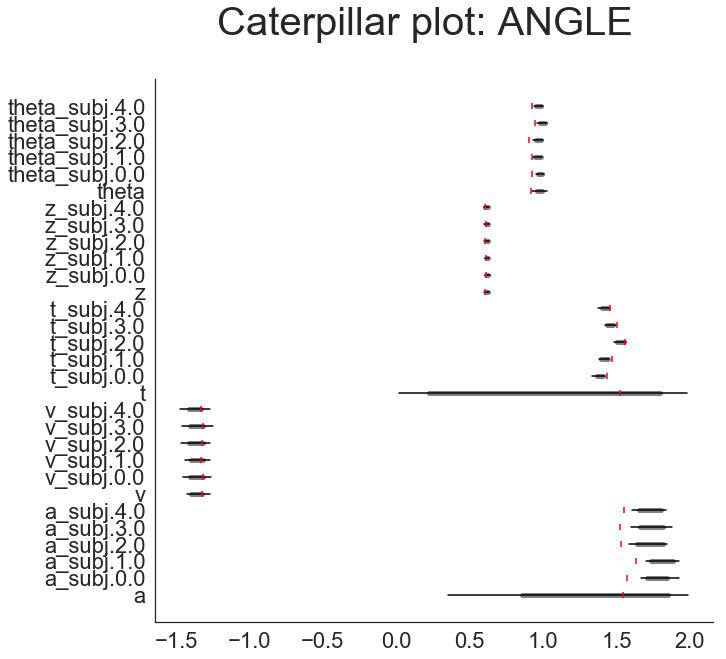

In [4]:
# Caterpillar Plot
caterpillar_plot(posterior_samples = angle_trace_h,
                 ground_truths = hddm_data_hierarchical_angle,
                 model = 'angle',
                 datatype = 'hierarchical',
                 drop_sd = True)

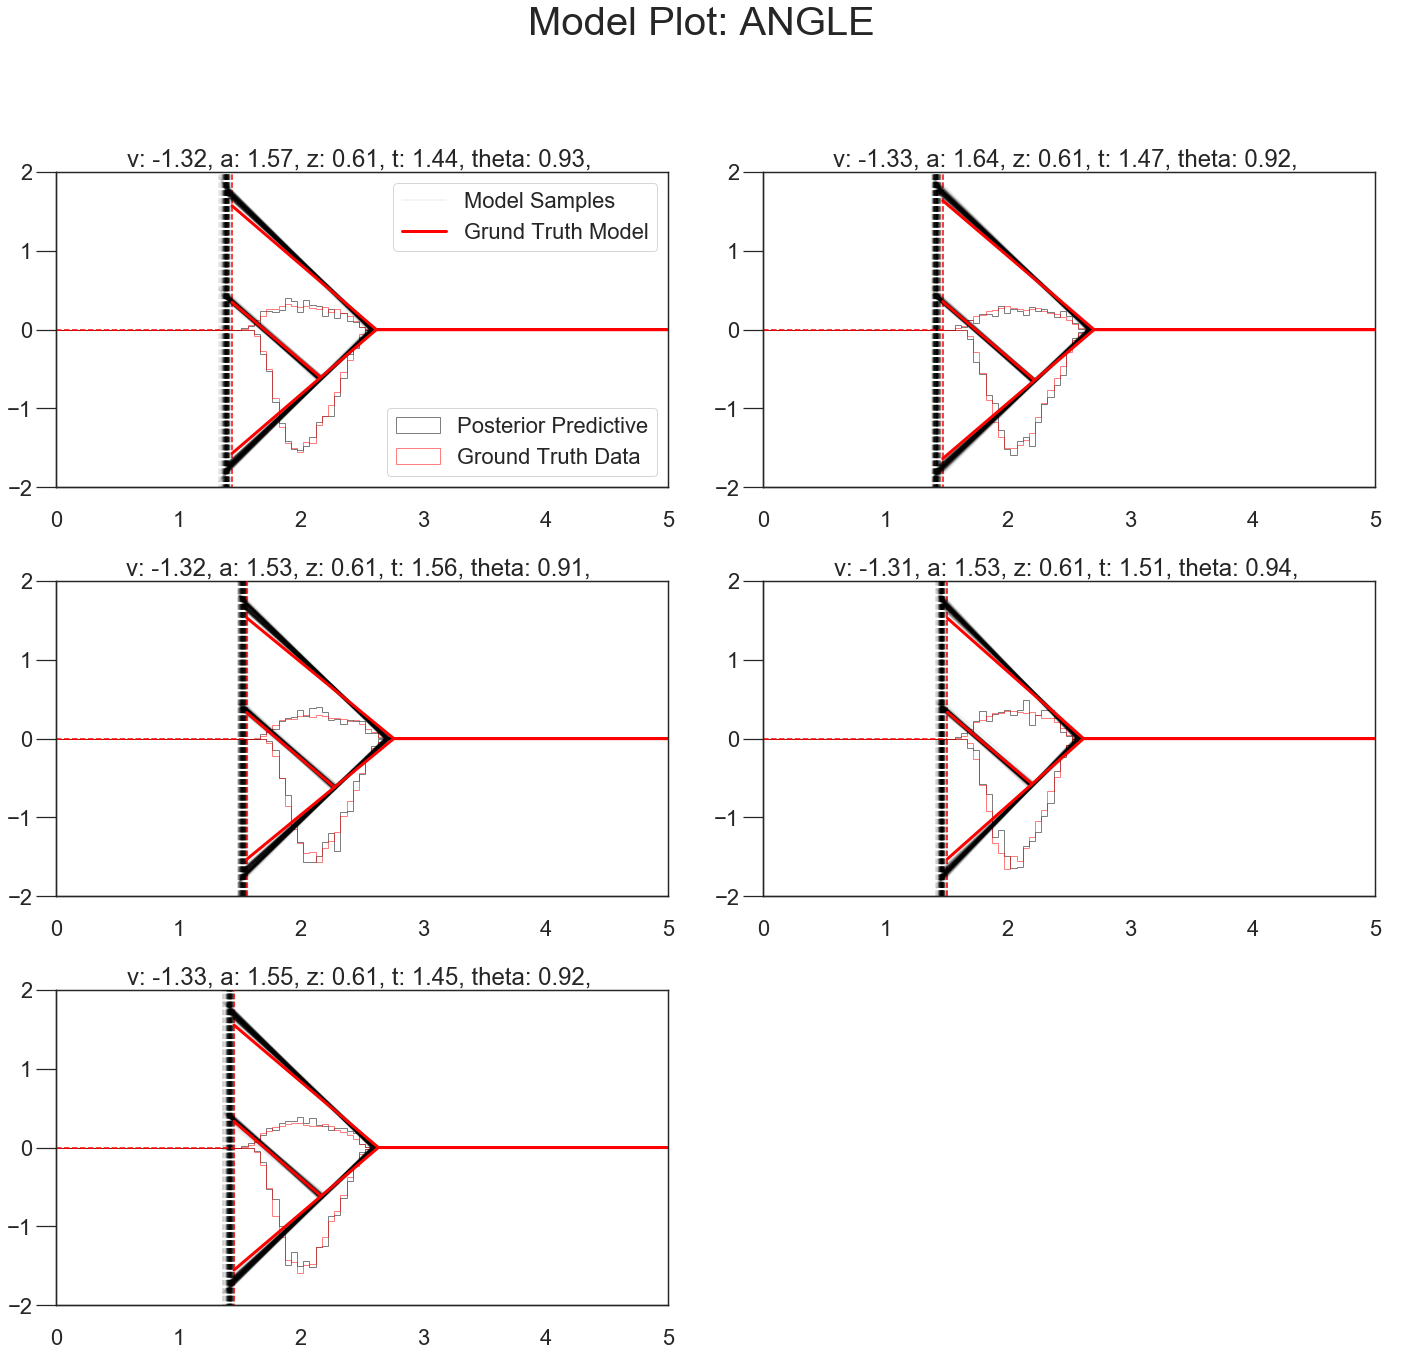

In [6]:
# Posterior Predictive
model_plot(ground_truths_parameters = hddm_data_hierarchical_angle[1].values,
           posterior_samples = angle_trace_h,
           input_hddm_trace = True,
           n_post_params = 200,
           cols = 2, 
           model_gt = 'angle',
           model_fitted = 'angle',
           datatype = 'hierarchical',
           n_plots = 5,
           max_t = 5,
           show_model = True)

### WEIBULL

In [7]:
# WEIBULL
hddm_data_hierarchical_weibull_cdf = hddm_preprocess_hierarchical(model = 'weibull_cdf', 
                                                                  datasetid = 1)


# Loading in data
load_in = pickle.load(open('data_storage/weibull_hierarchical_n_1000.pickle', 'rb'))
weibull_trace_h = load_in[0]

In [8]:
hddm_data_hierarchical_weibull_cdf[0].head()

response        rt  subj_idx  nn_response
0       1.0  2.125856       0.0          1.0
1       1.0  1.877859       0.0          1.0
2       0.0  2.042857       0.0         -1.0
3       0.0  2.124856       0.0         -1.0
4       1.0  2.590876       0.0          1.0

In [32]:
weibull_trace_h

NameError: name 'weibull_trace_h' is not defined

In [11]:
# hddm_hierarchical_model_weibull_cdf = hddm.HDDMnn_weibull(hddm_data_hierarchical_weibull_cdf[0], 
#                                                          free = False,  
#                                                          informative = False, 
#                                                          include = 'z',
#                                                          k = True,
#                                                          is_group_model = True)

In [12]:
# nmcmc = 1500
# hddm_hierarchical_model_weibull_cdf.sample(nmcmc, burn = 500)

 [-----------------100%-----------------] 1501 of 1500 complete in 1026.3 sec

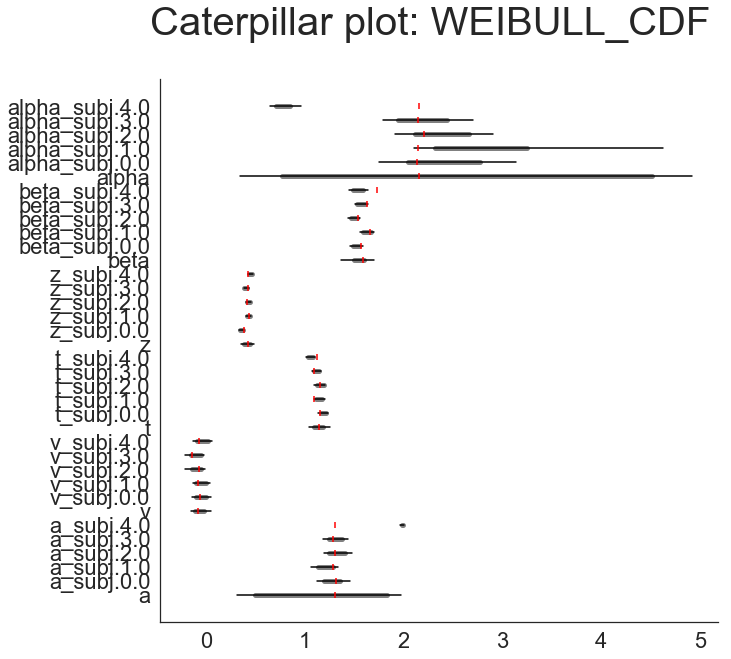

In [9]:
# Caterpillar Plot
caterpillar_plot(posterior_samples = weibull_trace_h,
                 ground_truths = hddm_data_hierarchical_weibull_cdf,
                 model = 'weibull_cdf',
                 datatype = 'hierarchical',
                 drop_sd = True)

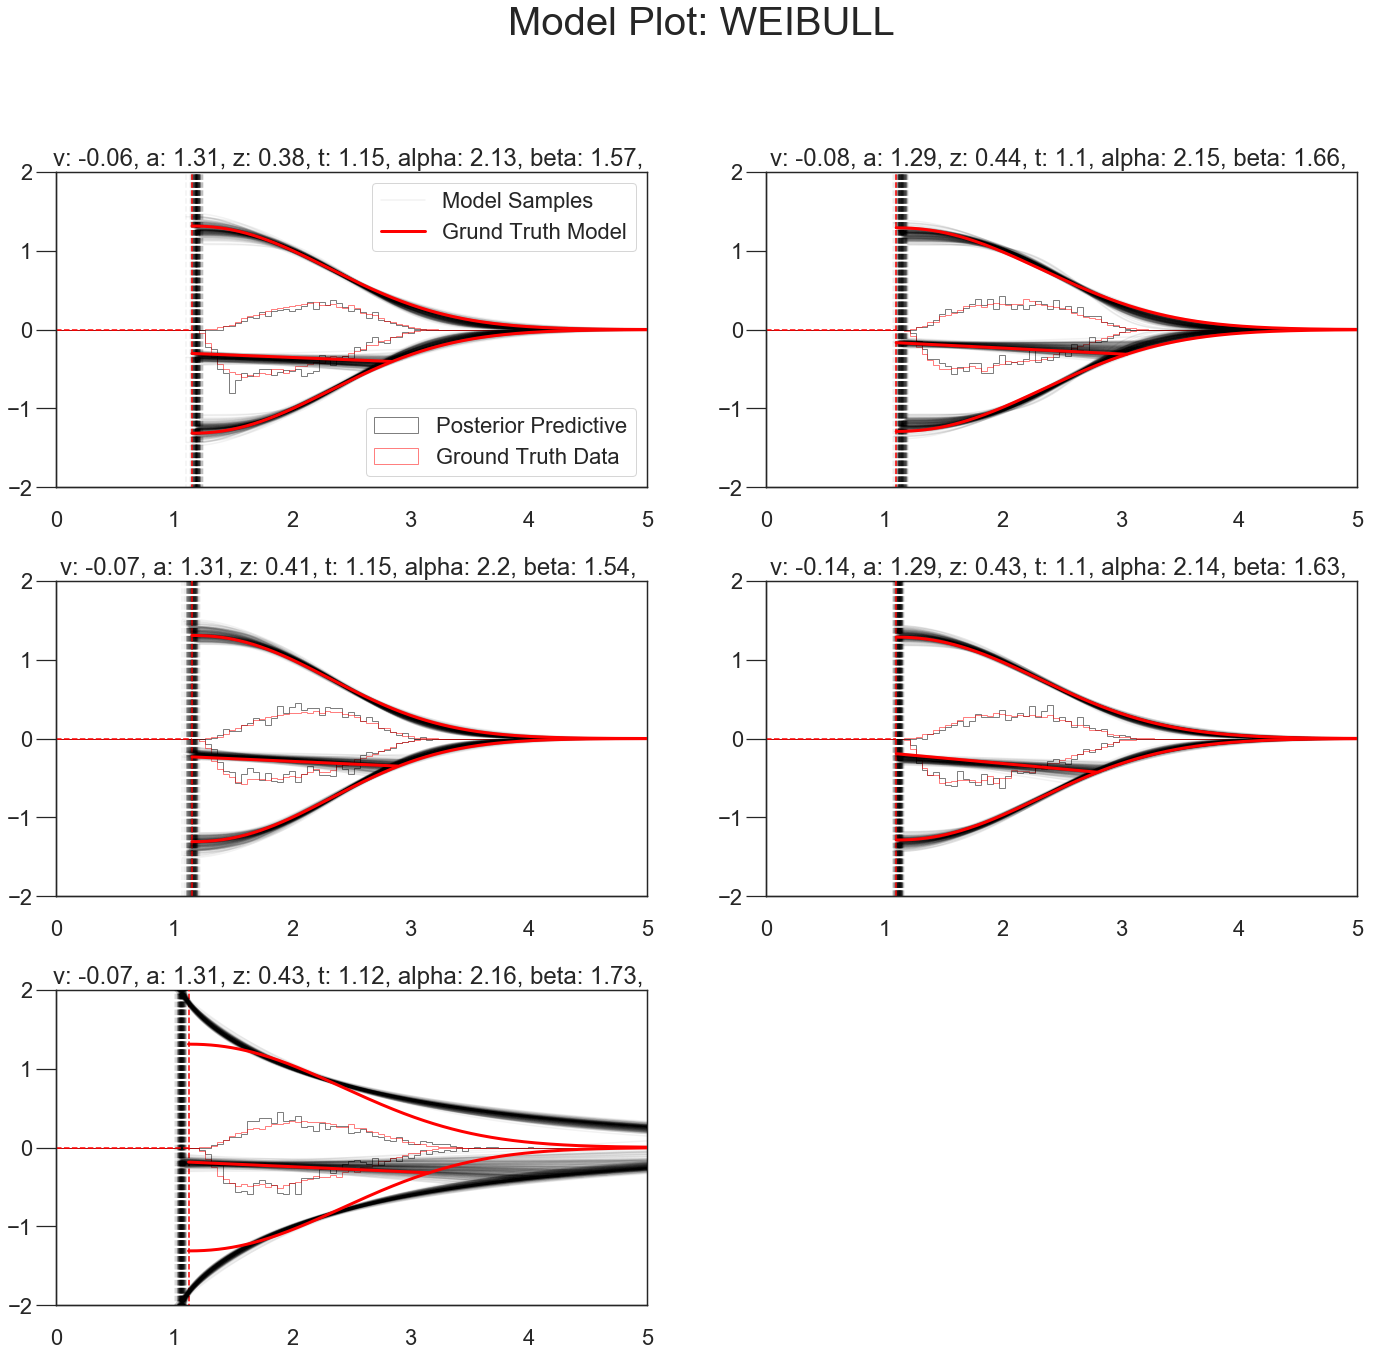

In [11]:
# Posterior Predictive
model_plot(ground_truths_parameters = hddm_data_hierarchical_weibull_cdf[1].values,
           posterior_samples = weibull_trace_h,
           input_hddm_trace = True,
           n_post_params = 200,
           cols = 2, 
           model_gt = 'weibull_cdf',
           model_fitted = 'weibull_cdf',
           datatype = 'hierarchical',
           n_plots = 5,
           max_t = 5,
           show_model = True)

# SECTION 4: PARAMETER VARIES BY CONDITION

An important aspect of these posterior analysis, is the consideration of experiment design.
We may have an experiment in which subject are exposed to a variety of conditions, 
such as for example different degrees of difficulty of the same task

It is often reasonable to assume that all but the conceptually relevant parameters are common across conditions.

As a by-product, such experiment designs can help us with the recovery of the constant parameters, by probing those static aspects of the model across varying kinds of datasets (driven by targeted manipulation of variable aspects of the model).

Implicitly we fit the following kind of model,

$$p( \{\theta_c \}, \theta | \mathbf{x} ) \propto  \left[ \prod_c^C  \left[ \prod_i^{N_i} p( x_i^c | \theta_c, \theta ) \right] p(\theta_c)  \right] p(\theta)$$


Where $\theta_c$ is the condition dependent part of the parameter space, and $\theta$ forms the portion of parameters which remain constant across condtions. 

To give a more concrete example involving the **weibull model** (executed below), consider a dataset for a single participant, who went through four conditions of an experiment. Think of the conditions as manipulating the payoff structure of the experiment to incentivize / disincentivize accuracy in favor of speed. We operationalize this by treating the $a$ parameter, the initial boundary separation, as affected by the manipulation, while the rest of the parameters are constant across all experiment conditions.

The resulting model would be of the form, 

$$ p( {a_c}, v, z, t, \alpha, \beta | x ) \propto \left[ \prod_c^C  \left[ \prod_i^{N_c} p( x_i^c | a_c, v, z, t, \alpha, \beta)  \right] p(a_c) \right]  p(v, z, t, \alpha, \beta)$$ 

### WEIBULL

Again we comment out the sampling code, to save some time. 
You can uncomment and run this code if you like.

In [12]:
# Generating some data
# We generate data such that only one parameter varies by condition (in this case 'a' --> the initial boundary separation)
# hddm_data_condition, gt_condition, gt_mat_condition = simulator_condition_effects(n_conditions = 4, 
#                                                                                   n_samples_by_condition = 1000,
#                                                                                   condition_effect_on_param = ['a'], 
#                                                                                   model = 'weibull_cdf',
#                                                                                   )

In [13]:
# hddm_data_condition.head()

rt  response  nn_response  condition
0  2.436835       0.0           -1          0
1  1.409824       0.0           -1          0
2  2.963859       0.0           -1          0
3  2.346830       0.0           -1          0
4  1.346825       0.0           -1          0

In [156]:
# gt_condition

{'a(0)': 0.8605307694017392,
 'a(1)': 0.9798105987677244,
 'a(2)': 1.2973403356591042,
 'a(3)': 0.8919618353411207,
 'v': -0.3982804686782764,
 'z': 0.6419385027703207,
 't': 1.5702078579162195,
 'alpha': 2.5885596546844916,
 'beta': 5.477381879900294}

In [157]:
# hddm_model_condition = hddm.HDDMnn_weibull(hddm_data_condition, 
#                                            informative = False, 
#                                            free = False, 
#                                            k = True,
#                                            include = ['z'],
#                                            is_group_model = False, 
#                                            depends_on = {'a': 'condition'})

In [158]:
# ncmcm  = 1000
# hddm_model_condition.sample(nmcmc, burn = 200)

 [-----------------100%-----------------] 1500 of 1500 complete in 359.4 sec

In [15]:
# Again we use preloaded data
load_in = pickle.load(open('data_storage/condition_weibull_n_1000.pickle', 'rb'))

weibull_trace_c = load_in[0]
weibull_gt_c = load_in[1]
weibull_gt_mat_c = load_in[2]
weibull_data_c = load_in[3]

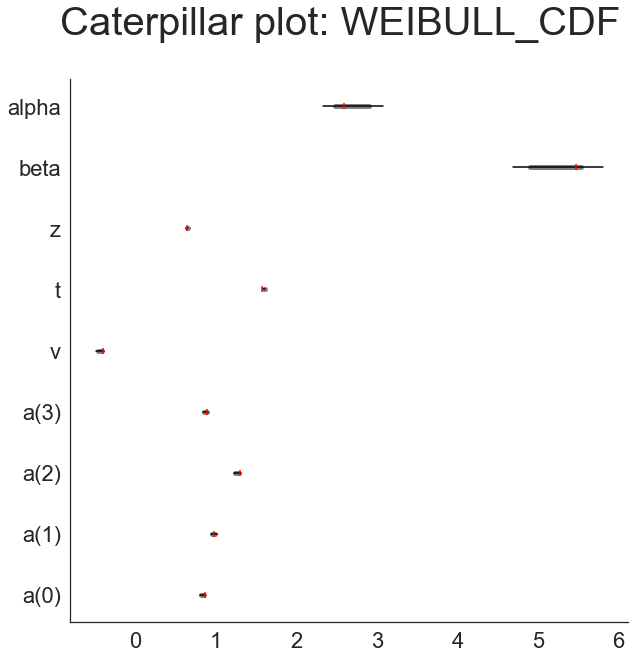

In [16]:
caterpillar_plot(posterior_samples = weibull_trace_c,
                 ground_truths = weibull_gt_c,
                 model = 'weibull_cdf',
                 datatype = 'condition',
                 drop_sd = True)

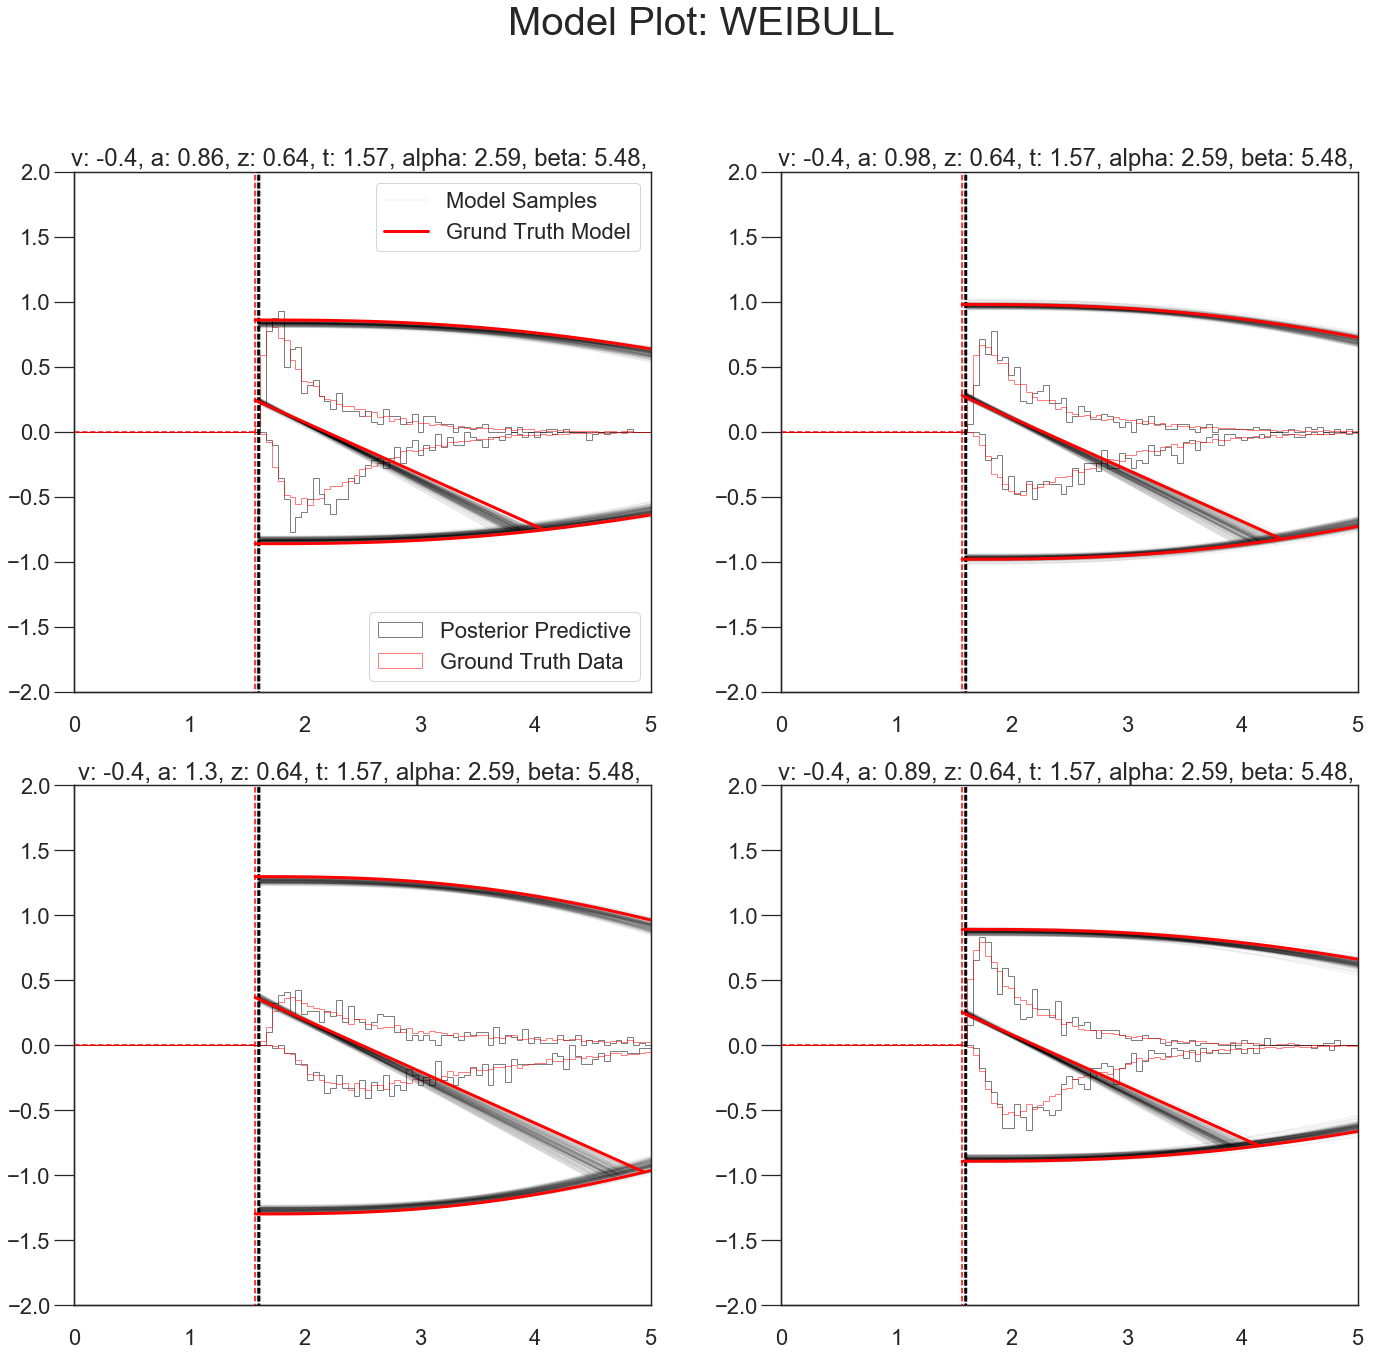

In [17]:
model_plot(posterior_samples = weibull_trace_c,
           ground_truths_parameters = weibull_gt_mat_c,
           model_gt = 'weibull_cdf',
           model_fitted = 'weibull_cdf',
           datatype = 'condition',
           input_hddm_trace = True,
           n_post_params = 100,
           n_plots = 1,
           cols = 2,
           show_model = True)

# SECTION 5: MODEL RECOVERY

Lastly we are going to look at model recovery, because it is tempting now that we have three kinds of models at our hands ( **ddm / angle / weibull **). 

For the little model recovery study we conduct here, we generate data from the **weibull** model and fit the data once each to the  **weibull**, **angle** and **ddm** models.

We inspect the fits visually and then use the *DIC* (Deviance information criterion, lower is better :)), to check if we can recover the **true** model. 

In [173]:
# Let's generate data from one of our three models
weibull_params = make_parameter_sets(model = 'weibull_cdf',
                                     n_parameter_sets = 1)

simulations = simulator(theta = weibull_params.values[0],
                        model = 'weibull_cdf', 
                        n_samples = 1000)

hddm_data_single_subject_weibull = hddm_preprocess(simulations)

In [174]:
# Now we fit for each model:
hddm_model_single_subject_weibull = hddm.HDDMnn_weibull(hddm_data_single_subject_weibull, 
                                                informative = False, 
                                                free = False, 
                                                k = True,
                                                include = ['z'],
                                                is_group_model = False)

hddm_model_single_subject_angle = hddm.HDDMnn_angle(hddm_data_single_subject_weibull, 
                                                    informative = False, 
                                                    free = False,
                                                    include = ['z'],
                                                    is_group_model = False)

hddm_model_single_subject_ddm = hddm.HDDMnn(hddm_data_single_subject_weibull, 
                                            informative = False, 
                                            #free = False,
                                            include = ['z'],
                                            is_group_model = False)

In [176]:
nmcmc = 500
hddm_model_single_subject_weibull.sample(nmcmc, 
                                         burn = 200)

hddm_model_single_subject_angle.sample(nmcmc, 
                                       burn = 200)

hddm_model_single_subject_ddm.sample(nmcmc, 
                                     burn = 200)

 [-----------------100%-----------------] 500 of 500 complete in 18.6 sec

### CHECKING THE MODEL FITS VISUALLY

passed through legend part
0
0


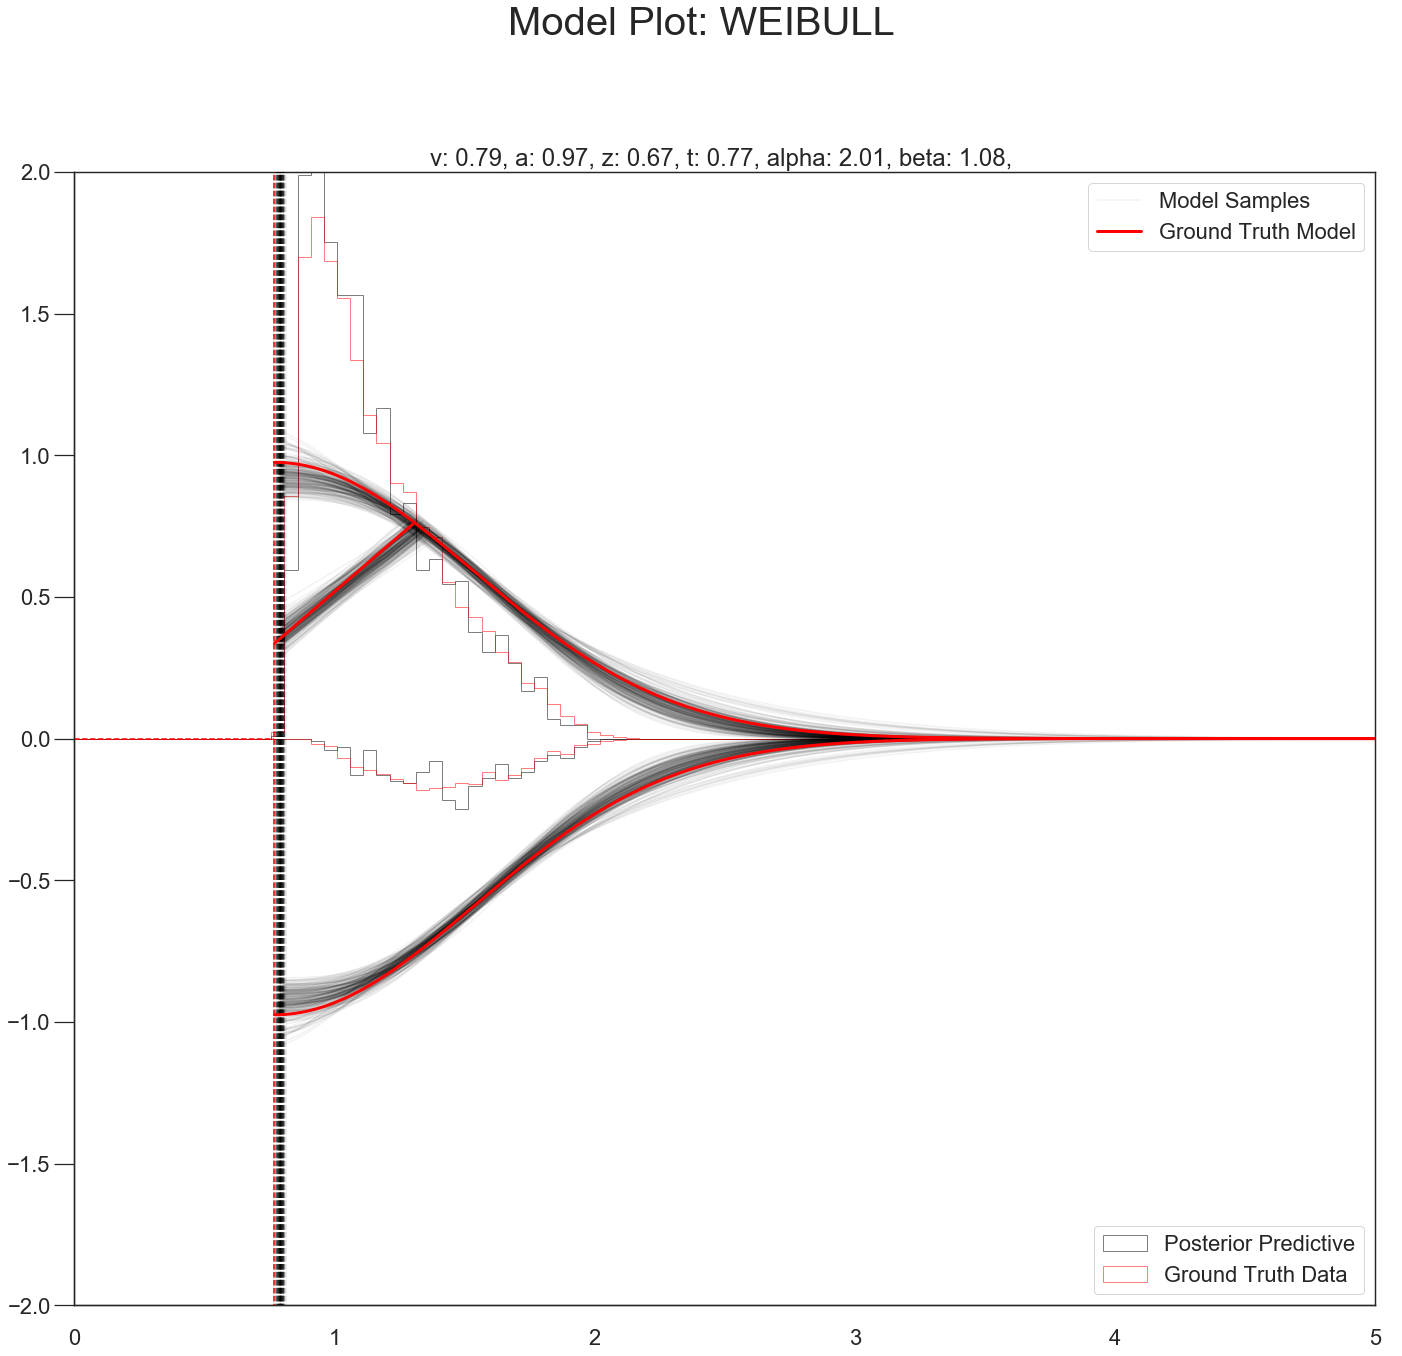

In [177]:
# Posterior Predictive: Do the 'Posterior Models' also make sense?
model_plot(ground_truths_parameters = weibull_params.values[0],
           posterior_samples = hddm_model_single_subject_weibull.get_traces(),
           model_gt = 'weibull_cdf',
           model_fitted = 'weibull_cdf',
           n_post_params = 200,
           cols = 1,
           n_plots = 1,
           max_t = 5,
           show_model = True,
           input_hddm_trace = True,
           datatype = 'single_subject')

passed through legend part
0
0


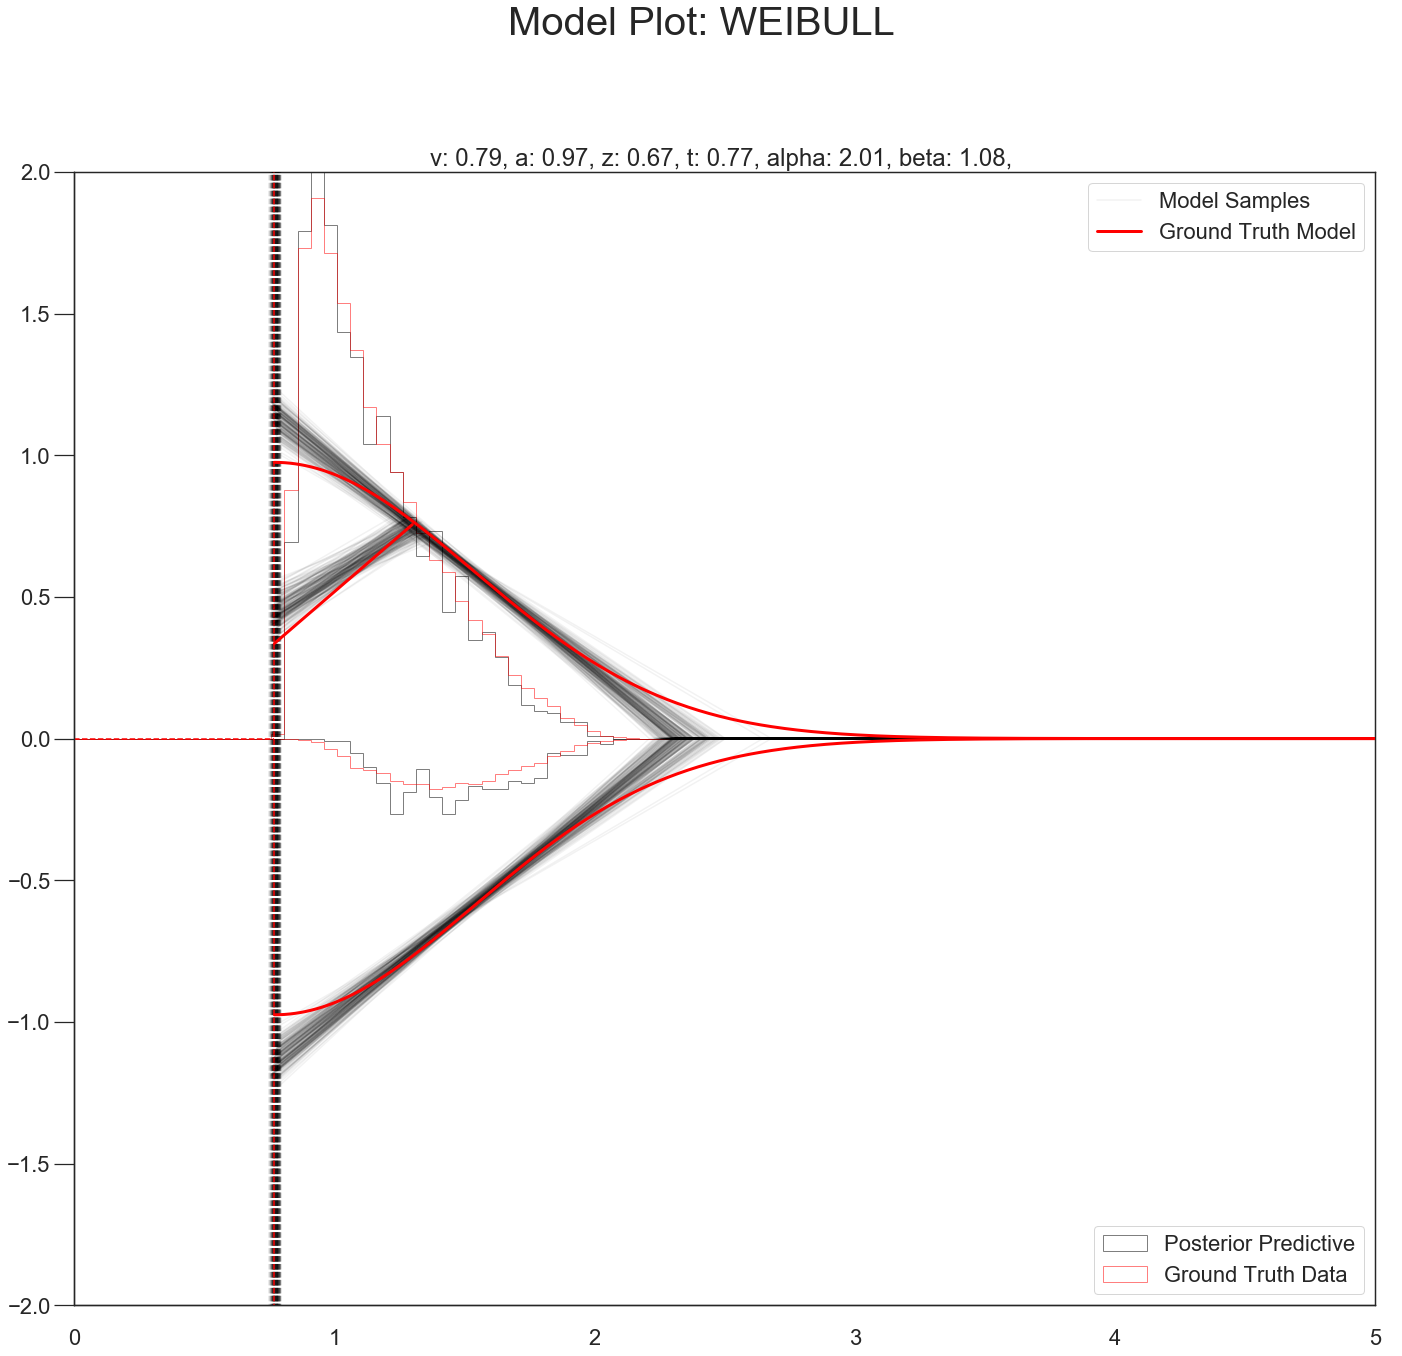

In [178]:
# Posterior Predictive: Do the 'Posterior Models' also make sense?
model_plot(ground_truths_parameters = weibull_params.values[0],
           posterior_samples = hddm_model_single_subject_angle.get_traces(),
           model_gt = 'weibull_cdf',
           model_fitted = 'angle',
           n_post_params = 200,
           cols = 1,
           n_plots = 1,
           max_t = 5,
           show_model = True,
           input_hddm_trace = True,
           datatype = 'single_subject')

passed through legend part
0
0


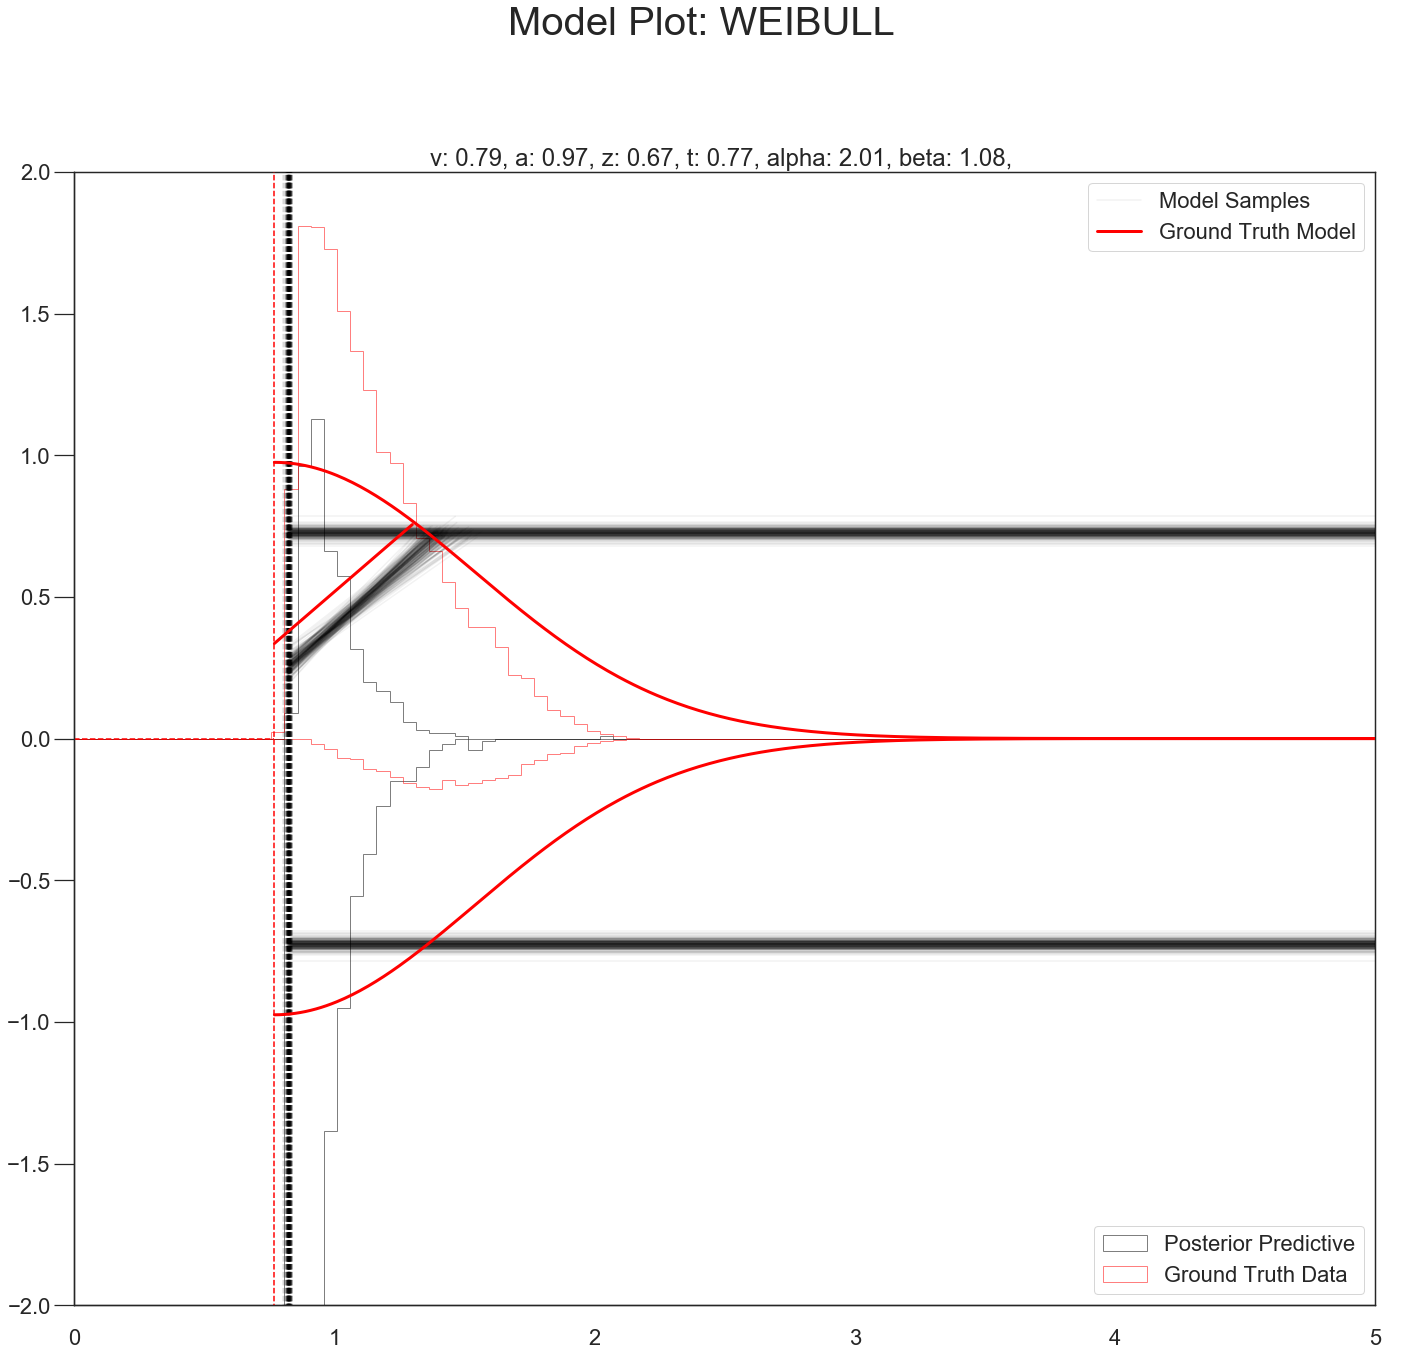

In [179]:
# Posterior Predictive: Do the 'Posterior Models' also make sense?
model_plot(ground_truths_parameters = weibull_params.values[0],
           posterior_samples = hddm_model_single_subject_ddm.get_traces(),
           model_gt = 'weibull_cdf',
           model_fitted = 'ddm',
           n_post_params = 200,
           cols = 1,
           n_plots = 1,
           max_t = 5,
           show_model = True,
           input_hddm_trace = True,
           datatype = 'single_subject')

### Let's compare the DIC's 

In [180]:
hddm_model_single_subject_weibull.dic

504.89051493326826

In [181]:
hddm_model_single_subject_angle.dic

531.1499723307293

In [182]:
hddm_model_single_subject_ddm.dic

681.0696756998698

**Fingers crossed** (this was a random run after all), the DIC usually gives us a result that conforms with the intuition we get from looking at the model plots. 

## Thank you and good luck with your modeling challenge. 

Get in touch with us if you are interested in using the **HDDM neural network extension** for this purpose. 

In [14]:
# pickle.dump([hddm_model_condition.get_traces(), 
#              gt_condition, gt_mat_condition, 
#              hddm_data_condition], 
#              open('condition_weibull_n_1000.pickle', 'wb'))